# Background

While antiSMASH is as of now considered the gold standard of BGC discovery and annotation, it relies heavily on assembled contigs or complete genomes. This can not necessarily be guaranteed from low coverage environmental sequencing experiments. Even though the raw reads from an environmental sequencing experiment could individually be of high quality, they might not lead to a high enough coverage for assembling them into contiguous genomic regions long enough for a high quality assembly suitable for antiSMASH. However, there is valuable information for mining in these reads that can be harnessed. This is not a new idea and has been attempted e.g. with metaBGC, but also other methods in the past. 

MetaBGC centered on building novel profile hmms, specific to 30aa long subsets of a protein, that were then used to search translated (meta)genomic reads with. The build process requires careful curation of starting genomes to generate metagenomes from. Models were very specific to this sub-sequence and were ultimately based on a collection of 140 synthetic metagenomes generated from a collection of 150 input genomes. Depending on the gene of interest that a model was built from, the building process can take multiple days and take upwards of 5TB of temporary storage space to accomodate the synthetic metagenomes an their translations. 5TB being the default storage limit of locally available computing clusters, only one model could be built at any one time, and the outcome was not guaranteed to be usable. The initial curation of genomes, positive and negative for the gene of interest could in itself take multiple days. At the same time, a lot of the genetic information in the input genomes was discarded by pre-filtering them by positive/negative for the gene of interest.

Instead of building segmented profile hmms, in this approach I use the already available, full-length hmms that are at the core of antiSMASH (but it could be any hmm, really) and search them against a sequence database consisting of unassembled sequencing reads. Read translation, which is a bottleneck of this approach, is still necessary, as there is currently no blastx equivalent of hmmsearch. After translating, searching the currently 297 antiSMASH hmms against a synthetic metagenome of ~70Mbp, generated as described in Sugimoto et al. only takes in the order of hours with no single hmm search taking more than 20min. 

Another method that straddles the advantages of both of the aforementioned approaches is to download as many complete genomes as possible as a higher number of input genomes will lead to a larger quantity and variety of biosynthetic genes being present in the input data. At the time of writing, refseq contained approximately 30000 complete bacterial and archaeal genomes. While using all of these genomes as input genomes for generating artificial metagenomes in the sugimoto style would be computationally prohibitive, one artificial metagenome can be made by concatenating the coding sequences of all of these genomes. As opposed to translating them ORF-wise, which is the most time-intensive step when using sugimoto style metagenomes, the peptide sequences can be parsed out directly from the genbank files, and these can then be fragmented into a length of amino acids that corresponds to the length of a quality filtered and trimmed sequencing read by using a sliding-window approach. 

As opposed to the approach that metaBGC takes of splitting the source genome into positive and negative based on the presence/absence of a particular (biosynthetic) gene of interest for the generation of each model, this distinction is not made ab initio with our method. As a result, the separation between a usable and non-usable result has to be made at the end. However, a big advantage of this method is that it is not limited to building one model at a time, but instead builds up to as many models as hmms are used in the search step. At the same time, less disc space is required, and with skipping the translation step, less time is required.


### Files and directories provided

- input_gbk_files/
- input_fna_files/
- AS_genomes/ 
    (antismash output generated by passing files in input_fna_files)
- hmmsearch_results
    (output files of hmmsearch)
- mapped_reads/
- antismash_hmms/
    (Directory containing a collection of .hmm files)
- testing_hmm_output
    (Contains subdirectory metagenome_1 with hmmsearch results generated from a synthetic metagenome)
- validation_hmmsearch_results/
    (Contains subdirectories for hmmsearch results against synthetic metagenomes based on generated coverage tables)
    
    
- AS_out_files/
    (directory present with bowtie indices)

### Directories generated

- ORF_extractions
- hmm_hit_reads
- merged
- biosynthetic_reads
- coverage_tables
- validation_biosynthetic_reads
- validation_joined_hits
- biosynthetic_reads

- AS_out_files
    (Directory initially provided, but fasta fils and biosynthetic_capacity.csv are generated as part of this notebook)

In [1]:
import os
import re
from Bio import SeqIO, AlignIO, SearchIO
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import scipy
import scipy.stats as stats

In [2]:
# Change the path in the chdir command to the file path to the shortcut_tutorial_dir
os.chdir('/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir')

set_wd = os.getcwd()
print('working_directory is:', set_wd)

working_directory is: /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir


## Extracting and segmenting ORFs from input genomes
The cell below extracts all coding sequences 'CDS' from a directory of files in genbank format.


### Tutorial:

#### Required inputs:
A directory containing .gbk files (.gbff extension when downloaded from refseq), specified with the gbk_path variable in the cell below.

Input files were downloaded from refseq using the ncbi-genome-download tool, available here:
https://github.com/kblin/ncbi-genome-download


#### Generated outputs:
Outputs are saved in a new directory, specified under the output_dir variable below

- complete_ORFs.fasta, a multifasta file containing amino acid sequences of all annotated 'CDS' in all input files. Information in the fasta header is as in the following example:
>\>GCF_002393525.1_WP_024095563.1_chromosomal_replication_initiator_protein_DnaA_1
    - Sample accession ID: GCF_002393525.1
    - Protein ID: WP_024095563.1
    - Protein product name: chromosomal_replication_initiator_protein_DnaA
    - Counting number that increments when there are duplicate protein IDs in the same genome: 1
    
    
- nucleotide_equivalents.fasta, a multifasta file containing all the nucleotide sequences corresponding to the amino acid sequences above. Information in the fasta header is as in the following example:
>\>GCF_002393525.1_WP_024095563.1_chromosomal_replication_initiator_protein_DnaA
    - Sample accession ID: GCF_002393525.1
    - Protein ID: WP_024095563.1
    - Protein product name: chromosomal_replication_initiator_protein_DnaA


- subset_ORFs.fasta, a multifasta file containing segmented amino acid sequences of the length specified by the aa_len variable in the cell below and an offset specified by the step_size variable. With the default setting of aa_len=44 and step_size=34, the overlap between consecutive sequences is 10aa.  Information in the fasta header is as in the following example:
>\>GCF_002393525.1_WP_024095563.1_chromosomal_replication_initiator_protein_DnaA_1_1-44
    - Sample accession ID: GCF_002393525.1
    - Protein ID: WP_024095563.1
    - Protein product name: chromosomal_replication_initiator_protein_DnaA
    - Counting number that increments when there are duplicate protein IDs in the same genome: 1
    - amino acid start and end positions with respect to the full length protein: 1-44
    
    
- subset_nucleotide.fasta, a multifasta file containing segmented nucleotide sequences of the length specified by the aa_len variable in the cell below multiplied by 3 and an offset specified by the step_size variable, multiplied by 3. With the default setting of aa_len=44 and step_size=34, the overlap between consecutive sequences is 30bp. This corresponds to the length of a fairly typical illumina read. Information in the fasta header is as in the following example:
>\>GCF_002393525.1_WP_024095563.1_chromosomal_replication_initiator_protein_DnaA_1-132
    - Sample accession ID: GCF_002393525.1
    - Protein ID: WP_024095563.1
    - Protein product name: chromosomal_replication_initiator_protein_DnaA
    - nucleotide start and end positions with respect to the full length gene: 1-132

### Full scale:

Use the script large_scale_ORF_extraction.py that's called via the slurm script with the same name. It's the same script as in the cell below but adjusted su that the paths point towards all refseq gbks downloaded.

In [3]:
%%time
# Wall time: 51.7 s

gbk_path=set_wd+'/input_gbk_files'
output_dir=set_wd+'/ORF_extractions'

if os.path.isdir(output_dir):
    print(output_dir,'exists already')
else:
    print('Making', output_dir)
    os.mkdir(output_dir)

    
aa_len = 44
step_size = 34
    
    
os.chdir(gbk_path)

# This loop generates one multifasta files with all ORFs of all genomes in the directory
fasta_dict = {}
for gbk_file in os.listdir(gbk_path):
    if re.findall('.gbff', gbk_file):
        file = open(gbk_file, 'r')
        assembly_acc = '_'.join(gbk_file.split('_')[0:2])
        print('\n', 'Processing', gbk_file)
        for record in SeqIO.parse(gbk_file, 'genbank'):
            for feature in record.features:
                if feature.type == 'CDS':
                    if 'translation' in feature.qualifiers:
                        fasta_header = '>'+assembly_acc+'_'+feature.qualifiers['protein_id'][0]+'_'+feature.qualifiers['product'][0].replace(' ','_')
                        gene_start = str(feature.location).split(':')[0].strip('[')
                        gene_end = str(feature.location).split(':')[1].strip('](+)').strip('](-)')
                        
                        # This is not an ideal solution. The gene_start/gene_end line is different in the CDS that 
                        # have an annotated ribosomal slippage.
                        # With the try/except loop, I completely ignore these, even though they are in the aa-file
                        with open(output_dir+'/'+'nucleotide_equivalents.fasta', 'a') as nt_fasta:
                            try:
                                nt_fasta.write(fasta_header+'\n'+str(record.seq[int(gene_start):int(gene_end)])+'\n')
                            except ValueError:
                                continue
                
                        # Some genomes have multiple identical genes. Add a sequential number to these
                        # to avoid errors cause by duplicates downstream.
                        with open(output_dir+'/'+'complete_ORFs.fasta', 'a') as aa_fasta:
                        
                            if fasta_header not in fasta_dict.keys():
                                fasta_dict[fasta_header] = 1
                                aa_fasta.write(fasta_header+'_'+str(fasta_dict[fasta_header])+'\n'+feature.qualifiers['translation'][0]+'\n')
                            else:
                                fasta_dict[fasta_header] += 1
                                aa_fasta.write(fasta_header+'_'+str(fasta_dict[fasta_header])+'\n'+feature.qualifiers['translation'][0]+'\n')
    
    
def sliding_window(seq, header, window_size, step):
    residue_counter = 0
    while len(seq) >= window_size:
        f.write(header+'_'+str(residue_counter+1)+'-'+str(residue_counter+window_size)+'\n'+str(seq[:window_size])+'\n')
        residue_counter += step
        seq = seq[step:]

    f.write(header+'_'+str(residue_counter)+'-'+str(residue_counter+len(seq))+'\n'+str(seq)+'\n')

    
# setting the step to 10aa less than the window size ensures that the minimum output read size is 10, which 
# corresponds to the length of the shortest phmms in the antismash hmm collection
print('Subsetting aa-fasta')
for record in SeqIO.parse(output_dir+'/complete_ORFs.fasta', 'fasta'):
    with open(output_dir+'/'+'subset_ORFs.fasta', 'a') as f:
        sliding_window(record.seq, '>'+record.name, window_size=aa_len, step=step_size)

# Same but for nucleotide file, multiplied by 3
print('Subsetting nt-fasta')
for record in SeqIO.parse(output_dir+'/nucleotide_equivalents.fasta', 'fasta'):
    with open(output_dir+'/'+'subset_nucleotide.fasta', 'a') as f:
        sliding_window(record.seq, '>'+record.name, window_size=aa_len*3, step=step_size*3)

/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/ORF_extractions exists already

 Processing GCF_000005825.2_ASM582v2_genomic.gbff

 Processing GCF_000009785.1_ASM978v1_genomic.gbff

 Processing GCF_000010105.1_ASM1010v1_genomic.gbff

 Processing GCF_000012805.1_ASM1280v1_genomic.gbff

 Processing GCF_000018365.1_ASM1836v1_genomic.gbff

 Processing GCF_000021885.1_ASM2188v1_genomic.gbff

 Processing GCF_000023065.1_ASM2306v1_genomic.gbff

 Processing GCF_000070605.1_ASM7060v1_genomic.gbff

 Processing GCF_000092105.1_ASM9210v1_genomic.gbff

 Processing GCF_000092205.1_ASM9220v1_genomic.gbff

 Processing GCF_000092465.1_ASM9246v1_genomic.gbff

 Processing GCF_002243515.1_ASM224351v1_genomic.gbff

 Processing GCF_002393525.1_ASM239352v1_genomic.gbff

 Processing GCF_002285795.1_ASM228579v1_genomic.gbff

 Processing GCF_003660185.1_ASM366018v1_genomic.gbff
Subsetting aa-fasta
Subsetting nt-fasta
CPU times: user 39.7 s, sys: 6.69 s, total: 46.3 s
Wall time: 55.1 s


# Analysis stream 1: Map reads to antiSMASH BGCs

### AntiSMASH

In parallel, run an up to date or available version of antiSMASH on all the input genomes (requires .fna files of the same genomes as above). AntiSMASH is compatible with archived (.gz) files, so if working with a larger database of input genomes, I would recommend not unpacking the archives. For the sake of this tutorial, the antiSMASH output has been provided.

#### required inputs:
directory containing nucleotide fasta files or .gz archives of all desired input genomes

#### command:
>antismash --cpus 12 --allow-long-headers --skip-zip-file --genefinding-tool prodigal --verbose --minlength 5000 --output-dir /media/locblankma\@vuw.ac.nz/RP/shortcut_tutorial_dir/AS_genomes/ /media/locblankma\@vuw.ac.nz/RP/shortcut_tutorial_dir/genome_file_name.fna

#### generated outputs:
The antiSMASH output is saved in the path pointed at under the --output-dir flag in the command above. The output directory contains one subdirectory with results for each genomes that was in the input directory.



## Parsing antiSMASH output
The cell below parses the antiSMASH output directories, and specifically the .gbk files within.
Outputs are saved in the directory specified under the output_dir variable below, and are:

### Tutorial:


#### required inputs:
The antiSMASH output directory containing a subdirectory for each input genome as described in the antiSMASH cell above.

#### generated outputs:

- AS_core_ORFs.fasta, a multifasta file containing sequences of all genes annotated by antiSMASH as core biosynthetic genes. Information in the fasta header is as in the following example:
    >\>GCF_002243515.1_ASM224351v1_genomic_NZ_CP022657.1.region012_s19575_e43962_1_ctg1_2065_Condensation__AMP-binding
    - input genome name: GCF_002243515.1_ASM224351v1_genomic
    - region name: NZ_CP022657.1.region012
    - sequence start and end position with respect to BGC annotation (not genome annotation): s19575_e43962
    - locus tag: ctg1_2065
    - list of hmms antiSMASH used to annotate this gene, separated by __ : Condensation__AMP-binding
    
    
- AS_BGC_seqs.fasta, a multifasta file containing the sequences of full length BGCs as annotated by antiSMASH. This is currently unused but kept as a potentially alternative approach for downstream processing. Information in the fasta header is as in the following example:
    >\>GCF_002243515.1_ASM224351v1_genomic_NZ_CP022657.1.region012['NRPS', 'T1PKS', 'T1PKS']
    - input genome name: GCF_002243515.1_ASM224351v1_genomic
    - region name: NZ_CP022657.1.region012
    - list of protocluster types annotated in this region: ['NRPS', 'T1PKS', 'T1PKS']
    
    
- biosynthetic_capacity.csv, a comma separated table listing information on each genome about how much of it is dedicated to biosynthetic gene clusters. This table contains one row per input genome and the following headers:
    - sample: e.g. GCF_002243515.1_ASM224351v1_genomic
    - total_BGC_length: sum of lengths of all regions annotated in this genome by antiSMASH as containing BGCs (a region containing multiple BGCs is still only counted once)
    - amount_BGCs: total amount of regions in which BGCs were found in this genome (a region containing multiple BGCs is still only counted once)
    - primary BGCs: amount of BGC regions annotated in the largest genomic entity, i.e. the 'chromosome'
    - plasmid BGCs: amount of BGC regions annotated in all other genomic entities
    - total_genome_length: length of genome in bp
    - amount_chromosomes: amount of genomic entities in this genome
    - biosynthetic_capacity: total_BGC_length/total_genome_length, i.e. the proportion that the respective genome dedicates to BGCs as annotated by antiSMASH
    - Now also produces indiv_hmms_biosynthetic_capacity.csv, a table similar to biosynthetic capacity, but with additional columns recording the presence/absence and count for particular hmms. The columns are named after the particular hmm name and the amount of additional columns depends on the input data. Up to a maximum of 297 additional columns (current amount of antismash hmms) will be generated.
    
    
### Full scale:

Run pipeline1_generate_bt_indices.sl slurm script that calls the python script in the cell below.
The output is in the AS_genomes_parsed directory

In [4]:
%%time
# Wall time: 8.97 s

gbk_path=set_wd+'/AS_genomes/'
output_dir=set_wd+'/AS_out_files/'

if os.path.isdir(output_dir):
    print(output_dir,'exists already')
else:
    print('Making', output_dir)
    os.mkdir(output_dir)



os.chdir(gbk_path)
sample_dirs = os.listdir(gbk_path)
sample_path_list = []
for file in sample_dirs:
    sample_path_list.append(gbk_path+file)

    
# Define an hmm name lookup dict to account for the discrepancy in filename and hmm name in the AS hmms
hmm_name_lookup_dict = {}
for hmm_filename in os.listdir(set_wd+'/antismash_hmms/'):
    if re.findall('.hmm', hmm_filename):
        filename = hmm_filename.split('.')[0]
        with open(set_wd+'/antismash_hmms/'+hmm_filename) as f:
            for line in f:
                if line.startswith('NAME'):
                    hmm_name_lookup_dict[filename] = line.split(' ')[-1].strip('\n')
                    
                    
biosyn_cap_dict = {}
for sample_path in sample_path_list:
    hmm_dict = {}
    os.chdir(sample_path)
    sample_name = sample_path.split('/')[-1]
    print('Processing file:', sample_name)
    
    BGC_len_counter = 0
    BGC_amount_counter = 0
    record_id_list = []
    for file in os.listdir(sample_path):
        if re.findall('\.region', file): # region0 ?
            BGC_amount_counter += 1
#             print('\n', 'Processing BGC:', file)
            for record in SeqIO.parse(file, 'genbank'):
                record_id_list.append(record.id)
                BGC_len_counter += len(record.seq)
                
                # for extracting the full length sequence of a BGC
                protocluster_list = []
                for feature in record.features:
                    if feature.type == 'protocluster':
                        protocluster_list.append(feature.qualifiers.get('product')[0])
                        
                with open(output_dir+'/'+'AS_BGC_seqs.fasta', 'a') as f:
                    f.write('>'+sample_name+'_'+file.strip('.gbk')+str(protocluster_list)+'\n'+str(record.seq)+'\n')
            
                # for extracting all ORFs individually
                for feature in record.features:
                    if feature.type == 'CDS':
                            gene_start = str(feature.location).split(':')[0].strip('[')
                            gene_end = str(feature.location).split(':')[1].strip('](+)').strip('](-)')
                            locus_tag = str(feature.qualifiers['locus_tag'][0])
                            strand = str(feature.strand)
                            hmm_list = []
                            if feature.qualifiers.get('gene_functions'):
                                for hmm in feature.qualifiers.get('gene_functions'):
                                    if hmm.startswith('biosynthetic (rule-based-clusters)'):
                                        hmm_list.append('_'+hmm.split(':')[1].strip(' '))
                                        
                            # Only extract core genes
                            if len(hmm_list) >= 1:
                                with open(output_dir+'/'+'AS_core_ORFs.fasta', 'a') as f:
                                    f.write('>'+sample_name+'_'+file.strip('.gbk')+'_s'+gene_start+'_e'+gene_end+'_'+strand+'_'+locus_tag+'_'.join(hmm_list)+'\n'+str(record.seq[int(gene_start):int(gene_end)])+'\n')
                                
                                # populates dict with hmm_names as keys and counter as values
                                for i in hmm_list:
                                    if i.lstrip('_') not in hmm_dict:
                                        hmm_dict[i.lstrip('_')] = 1
                                    else:
                                        hmm_dict[i.lstrip('_')] += 1

    # populating the biosynthetic_capacity table
    for file in os.listdir(sample_path):
        if re.findall('^GCF_.*\.gbk', file):
            genome_len_count = 0
            genome_entity_count = 0
            genome_entity_list = []
            primary_BGCs_counter = 0
            plasmid_BGCs_counter = 0
            
            for record in SeqIO.parse(file, 'genbank'):
                genome_len_count += len(record.seq)
                genome_entity_count +=1    
            
            for record in SeqIO.parse(file, 'genbank'):
                genome_entity_list.append(record.id)
            primary_chromosome = genome_entity_list[0]

            for entry in record_id_list:
                if entry == primary_chromosome:
                    primary_BGCs_counter +=1
                else:
                    plasmid_BGCs_counter +=1
    
    biosyn_cap_dict[sample_name] = BGC_len_counter, BGC_amount_counter, primary_BGCs_counter, plasmid_BGCs_counter, genome_len_count, genome_entity_count, hmm_dict
    

biosyn_cap_df = pd.DataFrame.from_dict(biosyn_cap_dict, orient='index', columns=['total_BGC_length', 'amount_BGCs', 'primary_BGCs', 'plasmid_BGCs', 'total_genome_length', 'amount_chromosomes', 'hmm_dict'])
indiv_hmms_df = biosyn_cap_df.copy() # make a copy to reain the OG version
biosyn_cap_df = biosyn_cap_df.reset_index().rename(columns={"index": "sample"})
biosyn_cap_df['biosynthetic_capacity'] = biosyn_cap_df.apply(lambda row: row.total_BGC_length/row.total_genome_length, axis=1)
biosyn_cap_df = biosyn_cap_df.drop('hmm_dict', axis=1)
biosyn_cap_df.to_csv(output_dir+'og_biosynthetic_capacity.csv', index=None)

# To generate a biosynthetic_capacity.csv resolved to individual hmms
indiv_hmms_df['biosynthetic_capacity'] = indiv_hmms_df.apply(lambda row: row.total_BGC_length/row.total_genome_length, axis=1)
for sample_id in indiv_hmms_df.index:
    for i, count in indiv_hmms_df.loc[sample_id,'hmm_dict'].items():
        indiv_hmms_df.loc[sample_id,i] = count

indiv_hmms_df = indiv_hmms_df.reset_index().rename(columns={"index": "sample"})
indiv_hmms_df = indiv_hmms_df.drop('hmm_dict', axis=1)
indiv_hmms_df.to_csv(output_dir+'indiv_hmms_biosynthetic_capacity.csv', index=None)


print('Done')

/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/AS_out_files/ exists already
Processing file: GCF_000009785.1_ASM978v1_genomic
Processing file: GCF_000010105.1_ASM1010v1_genomic
Processing file: GCF_000012805.1_ASM1280v1_genomic
Processing file: GCF_000018365.1_ASM1836v1_genomic
Processing file: GCF_000021885.1_ASM2188v1_genomic
Processing file: GCF_000023065.1_ASM2306v1_genomic
Processing file: GCF_000070605.1_ASM7060v1_genomic
Processing file: GCF_000092105.1_ASM9210v1_genomic
Processing file: GCF_000092205.1_ASM9220v1_genomic
Processing file: GCF_000092465.1_ASM9246v1_genomic
Processing file: GCF_002393525.1_ASM239352v1_genomic
Processing file: GCF_002285795.1_ASM228579v1_genomic
Processing file: GCF_002243515.1_ASM224351v1_genomic
Processing file: GCF_000005825.2_ASM582v2_genomic
Processing file: GCF_003660185.1_ASM366018v1_genomic
Done
CPU times: user 7.96 s, sys: 113 ms, total: 8.08 s
Wall time: 9.47 s


### Bowtie2 - index building
For this tutorial, the bowtie2 outputs are provided. Use the output of this above cell as an input to bowtie2 for generating an index. The purpose of this cell is to generate an index of all core genes extracted from antiSMASH output of all input genomes. This index is then used to map reads against.

#### Requirements:
- bowtie2/2.3.5.1
- samtools/1.10

#### Required inputs:
AS_core_ORFs.fasta file generated by cell above

#### Commands:

Generate bowtie index:

>bowtie2-build /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/AS_out_files/AS_core_ORFs.fasta /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/AS_out_files/AS_core_ORFs

Index fasta file:

>samtools faidx /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/AS_out_files/AS_core_ORFs.fasta -o /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/AS_out_files/AS_core_ORFs

#### Generated outputs:
Bowtie2 indices:
- AS_core_ORFs.1.bt2
- AS_core_ORFs.2.bt2
- AS_core_ORFs.3.bt2
- AS_core_ORFs.4.bt2
- AS_core_ORFs.rev.1.bt2
- AS_core_ORFs.rev.2.bt2

Indexed fasta:
- AS_core_ORFs.fasta.fai

### Bowtie2 - mapping
For this tutorial, the mapped reads are also provided. The 'reads' mapped to the antiSMASH core gene index are the subset nucleotides generated in the beginning. While these sequences are of the length of a read, they are not de facto reads, generated with a subsampling tool such as ART. The subset_nucleotide_reads.tsv output file is one of the two critical pieces to this puzzle.

#### Requirements:
- bowtie2/2.3.5.1
- samtools/1.10

#### Required inputs:
- subset_nucleotide.fasta file from cell 'Extracting and segmenting ORFs from input genomes'. This file, containing nucleotide sequences of length 132 (or less if from the end of a gene) is treated as single-end reads that are mapped to the index consisting of antiSMASH core genes.
- Bowtie2 index files built as described in the cell above

#### Commands:

Map 'reads' to bowtie index:

>mkdir -p mapped_reads; bowtie2 --threads 12 --very-sensitive --end-to-end -N 0 --mp 10000 --np 10000 --rdg 10000 --rfg 10000 -f -x /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/AS_out_files/AS_core_ORFs -U /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/ORF_extractions/subset_nucleotide.fasta -S /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/mapped_reads/subset_nucleotide_bt_out.sam


Generate a bam file + index for space reasons:

>samtools sort -o /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/mapped_reads/subset_nucleotide_bt_out.bam /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/mapped_reads/subset_nucleotide_bt_out.sam

>samtools index /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/mapped_reads/subset_nucleotide_bt_out.bam


Extract IDs of mapped reads and their corresponding mapping location:

>samtools view -F 4 /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/mapped_reads/subset_nucleotide_bt_out.sam | cut -f1,3 -d $'\t' | sort | uniq > /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/mapped_reads/subset_nucleotide_reads.tsv


Remove .sam file in order to save some space:

>rm /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/mapped_reads/subset_nucleotide_bt_out.sam


#### Generated outputs:
- subset_nucleotide_bt_out.bam
- subset_nucleotide_bt_out.bam.bai
- subset_nucleotide_reads.tsv

# Analysis stream 2: hmmsearch of read database

### HMM search
This side of the analysis uses the corresponding amino acid sequences extracted during the 'Extracting and segmenting ORFs from input genomes' step. These amino acid sequences constitute a sequence database of 'raw reads' that a collection of hmm profiles are searched against. In this case, I use the currently 297 hmms that underpin antiSMASH. The output of this search is provided in the 

#### Requirements
- hmmer/3.2.1

#### Required inputs
- Directory containing the antiSMASH .hmm files (found here: https://github.com/antismash/antismash/tree/master/antismash/detection/hmm_detection/data)
- subset_ORFs.fasta file from Extracting and segmenting ORFs step

#### Commands
The command below is an example for the AfsA.hmm. The same command has to be used for each hmm, so a loop is recommended.

>hmmsearch --tblout /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/hmmsearch_results/AfsA.tbl -o /dev/null -A /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/hmmsearch_results/AfsA.aln -E 0.01 /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/antismash_hmms/AfsA.hmm /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/ORF_extractions/subset_ORFs.fasta

#### Generated outputs
The outputs are again examples for AfsA.hmm, but a pair of files is in principle generated for each input hmm.

- AfsA.aln, an alignment between hmm profile and hit reads in stockholm format
- AfsA.tbl, a (space separated?) table listing the same hits as well as corresponding e-values and bitscores

## Parsing hmmsearch output

### Tutorial:

The cell below parses both hmmsearch output files. The alignment position with respect to the full length hmm profile are extracted from the .aln file, and combined with the e-value and bitscore from the respective .tbl file. Information is combined in a dataframe.

#### Required inputs
A directory containing the hmmsearch outputs in both stockholm format (.aln file) and tabular format (.tbl)


#### Generated outputs
A new directory is generated as specified in the output_dir variable in the cell below. In the directory the dataframe containing the combined information of the hmmsearch output is saved as a .csv file, unique_aln_df_out.csv. The table has the following columns:
- read_id: read name as described in 'Extracting and segmenting ORFs', e.g. GCF_002393525.1_WP_024095563.1_chromosomal_replication_initiator_protein_DnaA_1_1-44
- hmm: The hmm that generated a hit with this particular read
- start: The start position of the alignment of the read against the hmm profile
- end: The end position of the alignment of the read against the hmm profile
- e-value: Full sequence e-value extracted from the hmm tabular output
- bitscore: Full sequence bitscore extracted from the hmm tabular output

In cases where the same read_id generates hits with multiple hmm profiles, only the row with the highest respective bitscore is kept, and the rest of the reads are discarded.


### Full Scale:
generate_hmm_df_shortcut.py called through generate_hmm_df.sl slurm script. Output is in ORF_extractions/hmm_aln_dfs directory.

In [5]:
%%time
# Wall time: 11 s

# Script on raapoi: generate_hmm_df_shortcut.py called through generate_hmm_df.sl slurm scrips

hmm_in_path=set_wd+'/hmmsearch_results'
output_dir=set_wd+'/hmm_hit_reads'

# make an output dir
if os.path.isdir(output_dir):
    print(output_dir,'exists already')
else:
    print('Making', output_dir)
    os.mkdir(output_dir)
            
        
hmm_hit_dict = {}
for hmm_out_file in os.listdir(hmm_in_path):
    
    if re.findall('.aln', hmm_out_file):
        print('\n'+'Parsing hmms in', hmm_out_file)
        hmm_file = hmm_in_path+'/'+hmm_out_file
        
        # Extracting information about start and end position of alignment from the .aln file
        try:
            aln_file = AlignIO.read(hmm_file, "stockholm")
            counter = 0
            for record in aln_file:
                read_id = '/'.join(record.id.split('/')[0:-1])
                seq = str(record.seq) # sequence with gaps. length with len()
                start = len(seq) - len(seq.lstrip('-'))
                end = len(seq.rstrip('-')) - 1
                
                # Assign a combination of read_id and hmm file name as dictionary key to retain information of 
                # what hmm generated a hit with this read. The '---' delimiter is later used to split the columns.
                hmm_hit_dict[read_id+'---'+hmm_out_file.split('.')[0]] = [hmm_out_file.split('.')[0], start, end] # OG line


            # Extracting the remaining information from the .tbl file
            # This will fail if there are duplicate fasta headers, which is why above the counting number was inserted
            with open(hmm_in_path+'/'+hmm_out_file.split('.')[0]+'.tbl') as handle:
                for queryresult in SearchIO.parse(handle, 'hmmer3-tab'):
                    for hit in queryresult.hits:
                        
                        # strangely, some reads are in the aln file, but not listed on the table...
                        try:
                            hmm_hit_dict[hit.id+'---'+hmm_out_file.split('.')[0]].append(hit.evalue)
                            hmm_hit_dict[hit.id+'---'+hmm_out_file.split('.')[0]].append(hit.bitscore)
                        except KeyError:
                            print('Read in aln but not in table for:', hmm_out_file, 'read', hit.id)
                            pass
                        
        except ValueError:
            print('No records found in aln file:', hmm_out_file)


            
hmm_hit_df = pd.DataFrame.from_dict(hmm_hit_dict, orient='index', columns=['hmm', 'start', 'end', 'evalue', 'bitscore'])
temp_df = hmm_hit_df.reset_index().rename(columns={"index": "read_id"})
temp_df['read_id'] = temp_df.apply(lambda row: row.read_id.split('---')[0], axis=1)
temp_df.sort_values(by=['read_id', 'bitscore'], inplace=True)
temp_df.drop_duplicates(subset=['read_id'], keep='last', inplace=True)
temp_df.to_csv(output_dir+'/'+'unique_aln_df_out.tsv', sep='\t', index = None)


print('Done')

/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/hmm_hit_reads exists already

Parsing hmms in TIGR03795.aln
No records found in aln file: TIGR03795.aln

Parsing hmms in MA-2PEPA.aln
No records found in aln file: MA-2PEPA.aln

Parsing hmms in botH.aln

Parsing hmms in BacteriocIIc_cy.aln
No records found in aln file: BacteriocIIc_cy.aln

Parsing hmms in TIGR04424.aln
No records found in aln file: TIGR04424.aln

Parsing hmms in terpene_cyclase.aln

Parsing hmms in spcDK_like_cou.aln

Parsing hmms in PF01943.aln

Parsing hmms in neoL_like.aln
No records found in aln file: neoL_like.aln

Parsing hmms in RREFam009.aln
No records found in aln file: RREFam009.aln

Parsing hmms in TIGR03731.aln

Parsing hmms in micJ25.aln
No records found in aln file: micJ25.aln

Parsing hmms in itr_KS.aln

Parsing hmms in mvd_mst.aln
No records found in aln file: mvd_mst.aln

Parsing hmms in PF04345.aln

Parsing hmms in RREFam007.aln

Parsing hmms in mitE.aln

Parsing hmms in PF04055.aln

Parsing hmms in


Parsing hmms in PoyD.aln
No records found in aln file: PoyD.aln

Parsing hmms in PF01326.aln

Parsing hmms in Glycos_transf_1.aln

Parsing hmms in spcDK_like_glyc.aln

Parsing hmms in hglE.aln

Parsing hmms in PF13575.aln

Parsing hmms in DOIS.aln

Parsing hmms in TIGR01193.aln

Parsing hmms in RREFam002.aln
No records found in aln file: RREFam002.aln

Parsing hmms in TIGR03975.aln

Parsing hmms in thiostrepton.aln
No records found in aln file: thiostrepton.aln

Parsing hmms in LE-MER+2PEP.aln
No records found in aln file: LE-MER+2PEP.aln

Parsing hmms in PF16715.aln
No records found in aln file: PF16715.aln

Parsing hmms in mod_KS.aln

Parsing hmms in subtilosin.aln

Parsing hmms in LE-LAC481.aln
No records found in aln file: LE-LAC481.aln

Parsing hmms in ToyB.aln

Parsing hmms in PF04101.aln

Parsing hmms in t2ks.aln

Parsing hmms in PF02350.aln

Parsing hmms in PF03171.aln

Parsing hmms in PF00953.aln

Parsing hmms in PF02163.aln

Parsing hmms in LmbU.aln
No records found in aln f

# Merging analysis streams 1 and 2

#### Merging dataframes originating from mapping and hmmsearch
Both analysis streams assessed different, yet related concepts, using the same initial input sequences. The input sequences differed in the sense that for analysis stream 1, nucleotide sequences were used, whereas in analysis stream 2, the respectively translated amino acid sequences were used.

Analysis stream 1 used the nucleotide sequences and mapped them back to core genes of BGCs present in the input genomes. In a 'real world' scenario, this approach would require assembly of full genomes and annotation of the BGCs in these genomes. As in my scenario this isn't feasible, the goal is to use another, assembly-free approach, i.e. analysis stream 2, to identify the same, or at least a large proportion of the same reads.

Based on this background, the reads are classified as follows:
- True positive (TP): Reads that are both mapping against a BGC and are found by hmmsearch.
- False positive (FP): Reads that are found by hmmsearch, but are not among the collection of mapped reads
- False negative (FN): Reads that map, but are not found by hmmsearch
- True negative (TN): Reads that are neither mapping not are found by hmmsearch. True negative reads include reads that are not part of a BGC, or are part of a BGC, but not a core gene.

#### Generated outputs:


### Full scale:
merge_hmm_bt2_dfs.py called via merge_dfs.sl slurm script. Output in 'merged' directory.
The merge_hmm_bt2_df2_dfs.py script also includes the cell below, subsetting the merged df by hmms.

In [6]:
%%time
# Wall time: 10.7 s

# Script on raapoi: merge_hmm_bt2_dfs.py called via merge_dfs.sl slurm script

hmm_hit_dir=set_wd+'/hmm_hit_reads'
mapping_hit_dir=set_wd+'/mapped_reads'
output_dir=set_wd+'/merged'


# make an output dir
if os.path.isdir(output_dir):
    print(output_dir,'exists already')
else:
    print('Making', output_dir)
    os.mkdir(output_dir)
            

# Define custom indicator for renaming the values in the occurrence column
custom_indicator={"left_only":'FP', "right_only":'FN', "both":'TP'}

# Define an hmm name lookup dict to account for the discrepancy in filename and hmm name in the AS hmms
hmm_name_lookup_dict = {}
for hmm_filename in os.listdir(set_wd+'/antismash_hmms/'):
    if re.findall('.hmm', hmm_filename):
        filename = hmm_filename.split('.')[0]
        with open(set_wd+'/antismash_hmms/'+hmm_filename) as f:
            for line in f:
                if line.startswith('NAME'):
                    hmm_name_lookup_dict[filename] = line.split(' ')[-1].strip('\n')

# generate a new dict with unique hmm values per sample for downstream stats
unique_hmm_dict = {}



# The initial merging is also not necessary. concatenated_df IS hmm_aln_df
hmm_hit_df = pd.read_csv(hmm_hit_dir+'/unique_aln_df_out.tsv', sep='\t')
hmm_hit_df.sort_values(by=['read_id', 'bitscore'], inplace=True)

# split position out of read_id. Read_id still needs to be the same for mapping, so perhaps do that after
# These few lines of code make sure that the results coming from the hmm parsing side of things (aa-seq)
# Match the results coming from the mapping side of things (nt-seq).
# The original read_id contains sequences as counted in amino acids, and also have an extra numerical tag
# in case of duplicate proteins in individual genomes. The shuffling below makes sure that these are all
# recorded and accounted for in individual columns, and the hmm based read id matches tha mapping based read id
hmm_hit_df['duplicate_count'] = hmm_hit_df.apply(lambda row: re.split('_([0-9]+)_([0-9]+)-([0-9]+)$', row.read_id)[1], axis=1)
hmm_hit_df['start_nt_position'] = hmm_hit_df.apply(lambda row: (int(re.split('_([0-9]+)_([0-9]+)-([0-9]+)$', row.read_id)[2]))*3-2, axis=1)
hmm_hit_df['end_nt_position'] = hmm_hit_df.apply(lambda row: (int(re.split('_([0-9]+)_([0-9]+)-([0-9]+)$', row.read_id)[3]))*3, axis=1)
hmm_hit_df['read_id'] = hmm_hit_df.apply(lambda row: re.split('_([0-9]+)_([0-9]+-[0-9]+)$', row.read_id)[0]+'_'+str(row.start_nt_position)+'-'+str(row.end_nt_position), axis=1)

mapping_df = pd.read_csv(mapping_hit_dir+'/subset_nucleotide_reads.tsv', names = ['read_id', 'mapping_seq'], sep='\t')
result = pd.merge(hmm_hit_df,
                 mapping_df,
                 on='read_id',
                 how='outer',
                 left_index=False,
                 right_index=False,
                 indicator='occurrence')
result = result[['read_id', 'duplicate_count', 'start_nt_position', 'end_nt_position', 'hmm', 'start', 'end', 'evalue', 'bitscore', 'mapping_seq', 'occurrence']]
# The next 2 lines are for renaming values in the occurrence and hmm columns
result['occurrence'] = result['occurrence'].map(custom_indicator)
result['hmm'] = result['hmm'].map(hmm_name_lookup_dict)
# Dictionary format is a bit redundant with just one file, but makes working downstream easier as the scripts
# were initially set up for working with multiple files.
extract_hmm_df = result[result['occurrence'].isin(['FP', 'TP'])]
unique_hmm_dict['merged_hit_df'] = set(list(extract_hmm_df['hmm']))
# print(result)
result.to_csv(output_dir+'/merged_hit_df.tsv', index=None, sep='\t')


/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/merged exists already
CPU times: user 1.12 s, sys: 12.1 ms, total: 1.13 s
Wall time: 1.83 s


### Subset merged dataframe by hmm

The cell below will split the merged_hit_df.tsv file from the previous cell based on the value in the cells in the hmm column, and produce a separate .tsv file for each hmm.

#### Generated outputs:



In [7]:
%%time
# Wall time: 2.15 s

# Subset dataframes into multiple sub-frames based on unique values in the hmm columns
merged_dir=set_wd+'/merged'
output_dir=set_wd+'/merged/subset_dfs'


# make an output dir
if os.path.isdir(output_dir):
    print(output_dir,'exists already')
else:
    print('Making', output_dir)
    os.mkdir(output_dir)

# loop over set of hmm column to get df for all possible hmms for each sample
# This now also includes false negatives individually for each sample
for sample_name, v in unique_hmm_dict.items():
    working_df = pd.read_csv(merged_dir+'/'+sample_name+'.tsv', sep='\t', dtype={"read_id": str, "duplicate_count": 'Int64', "start_nt_position": 'Int64', "end_nt_position": 'Int64', "hmm": str, "start": 'Int64', "end": 'Int64', "evalue": np.float64, "bitscore": np.float64, "mapping_seq": str, "occurrence": str})
    for value in v:
        print('processing', value)
        subset_df = working_df[ (working_df["hmm"] == value) | (working_df['mapping_seq'].str.contains(value, na=False)) ]
        sorted_df = subset_df.sort_values(by=['start'], inplace=False)
        sorted_df.to_csv(output_dir+'/'+sample_name+'_'+value+'.csv', sep=',', index=None)

# Need to integrate the stats below in the loop to do this for all hmms for all samples

/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/merged/subset_dfs exists already
processing pur10
processing DOIS
processing DUF692
processing hglE
processing ksIII
processing PF00881
processing novI
processing Glyco_transf_28
processing TIGR03966
processing hyb_KS
processing LipM
processing Pkinase
processing A-OX
processing Lanthipeptide_LanB_RRE
processing t2clf
processing ThiF
processing FabF
processing salQ
processing DarB
processing Peptidase_M50
processing Glyco_tran_28_C
processing Bacteriocin_IId
processing LANC_like
processing SpcDK_cou
processing TIGR03793
processing LipV
processing MGT
processing YcaO
processing SpcDK_glyc
processing phytoene_synt
processing PF00561
processing DXP_synthase_N
processing Abhydrolase_6
processing phosphonates
processing 2OG-FeII_Oxy
processing Trp_halogenase
processing dTDP_sugar_isom
processing PF04055
processing Flavoprotein
processing goadsporin_like
processing frbD
processing Glycos_transf_2
processing Peptidase_M42
processing APH
pro

### Assessing True/False Positives/Negatives and calculating precision.

The goal of the cell below is to assess whether there are any regions in an hmm that more reliably identify whether a read is biosynthetic or not. It also works based on a sliding window approach, checking over the start column comming from the hmmsearch .aln output. I.e. a dataframe for a particular hmm is split up based on its length with adjustable window and step sizes. Currently, the window size is 9 and the step size is 10. For each of these regions, the amount of true positives and false positives are counted, and are defined as follows

- True positive (TP): Reads that are both mapping against a BGC and are found by hmmsearch. As opposed to the TP definition in the merging step, I also check whether the mapping is against a region that was found by the same hmm. In the previous definition, the same hit could have been found with a different hmm (i.e. hmmsearch identifies LanC, mapping is to a PKS), and it would still be considered a false positive.
- False positive (FP): Reads that are found by hmmsearch, but are not among the collection of mapped reads. In addition, FPs are also counted when a hmmsearch hit is found, but the mapping sequence pertains to a different hmm. These reads would formerly have been considered TP.

FNs and TNs are not strictly necessary for calculating the precision, but are included as a matter of completeness
- False negative (FN): Reads that map, but are not found by hmmsearch. These include instances in which a read is found to be mapping against a particular hmm, but is identified by a non-matching hmm.
- True negative (TN): Reads that are neither mapping not are found by hmmsearch. True negative reads include reads that are not part of a BGC, or are part of a BGC, but not a core gene. These are all remaining reads

Initially, an individual dataframe is generated for each interval (count_df, not saved or returned as part of this script). Each interval is defined bounded by 0 and the length of the respective hmm to be assessed and has a step-size that can be adjusted in the step variable in the sliding_window function (default 10).
Within each interval, the count_df gets one row per full integer bitscore, ranging from the lowest bitscore in this interval to the highest. For each bitscore, the TP, FP, and FN count are counted and added to the dataframe.

Count_df is then used to calculate the precision for each row with precision being defined as the quotient of TP/(TP+FP). The new dataframe precision_df is generated in which at most one row per count_df is added. The row added corresponds to the lowest bitscore in the count_df in which the precision exceeds the threshold set in the sliding_window function under the variable cutoff (default = 0.95). Precision_df is exported as a csv file, and also as a lineplot with the interval on the x-axis and the minimum bitscore at which precision exceeds threshold on the y-axis.

(I think there is still some work to be done, and I don't think FN should be disregarded)


### Full scale:

At this point, the precision cutoff can be adjusted.

generate_precision_dfs.py script on raapoi called via generate_precision_dfs.sl slurm script

/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/merged/precision_dfs_70 exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/merged/precision_plots_70 exists already
processing merged_hit_df_mod_KS.csv mod_KS
processing merged_hit_df_LANC_like.csv LANC_like
processing merged_hit_df_TIGR03966.csv TIGR03966
processing merged_hit_df_Peptidase_M16_C.csv Peptidase_M16_C
processing merged_hit_df_novH.csv novH
processing merged_hit_df_Thiopeptide_F_RRE.csv Thiopeptide_F_RRE
processing merged_hit_df_PF00881.csv PF00881
processing merged_hit_df_Condensation.csv Condensation
processing merged_hit_df_TIGR04103.csv TIGR04103
processing merged_hit_df_tabtoxin.csv tabtoxin
processing merged_hit_df_TIGR03793.csv TIGR03793
processing merged_hit_df_terpene_cyclase.csv terpene_cyclase
processing merged_hit_df_TIGR03604.csv TIGR03604
processing merged_hit_df_Abi.csv Abi
processing merged_hit_df_adh_short_C2.csv adh_short_C2
processing merged_hit_df_CBM_48.csv CBM_48
processing merged_

/home/locblankma/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


processing merged_hit_df_ectoine_synt.csv ectoine_synt
processing merged_hit_df_Glycos_transf_4.csv Glycos_transf_4
processing merged_hit_df_PKS_KS.csv PKS_KS
processing merged_hit_df_itr_KS.csv itr_KS
processing merged_hit_df_Mycofactocin_RRE.csv Mycofactocin_RRE
processing merged_hit_df_Alpha-amylase_C.csv Alpha-amylase_C
processing merged_hit_df_nikO.csv nikO
processing merged_hit_df_Peptidase_S9.csv Peptidase_S9
processing merged_hit_df_PPDK_N.csv PPDK_N
processing merged_hit_df_adh_short.csv adh_short
processing merged_hit_df_RmlD_sub_bind.csv RmlD_sub_bind
processing merged_hit_df_DUF4135.csv DUF4135
processing merged_hit_df_DUF1205.csv DUF1205
processing merged_hit_df_TIGR03106.csv TIGR03106
processing merged_hit_df_PF06968.csv PF06968
processing merged_hit_df_ladderane.csv ladderane
processing merged_hit_df_GST_N_3.csv GST_N_3
processing merged_hit_df_ustH.csv ustH
processing merged_hit_df_PpyS.csv PpyS
processing merged_hit_df_TIGR03731.csv TIGR03731
processing merged_hit_df_T

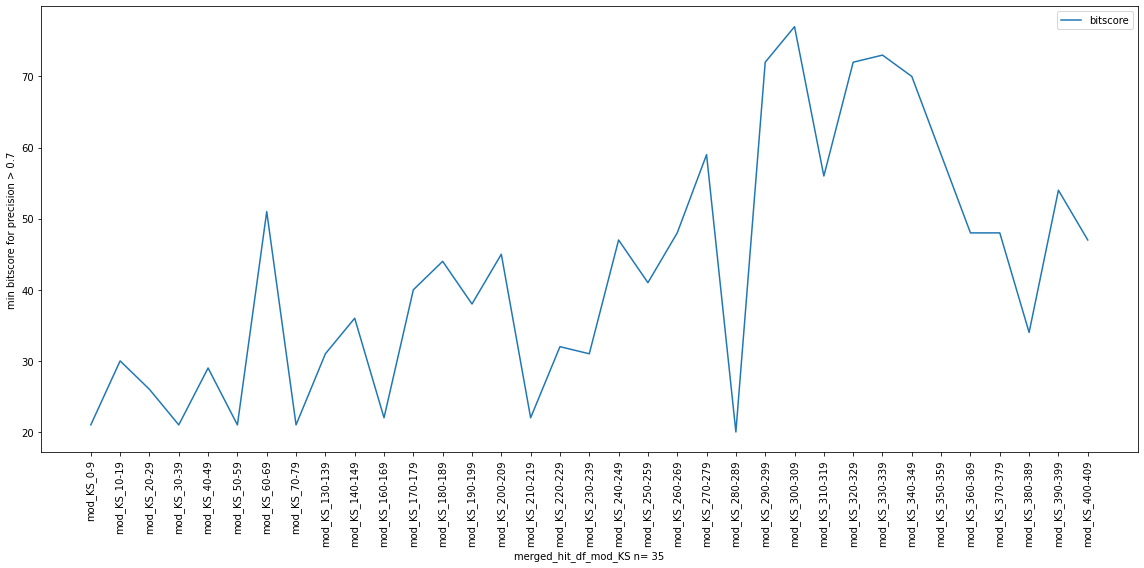

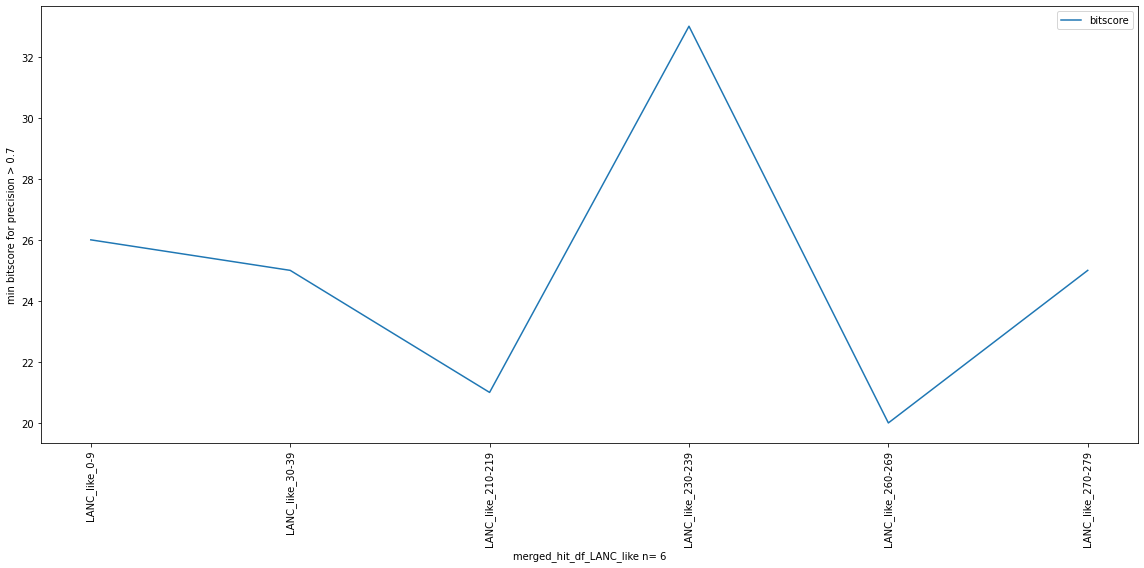

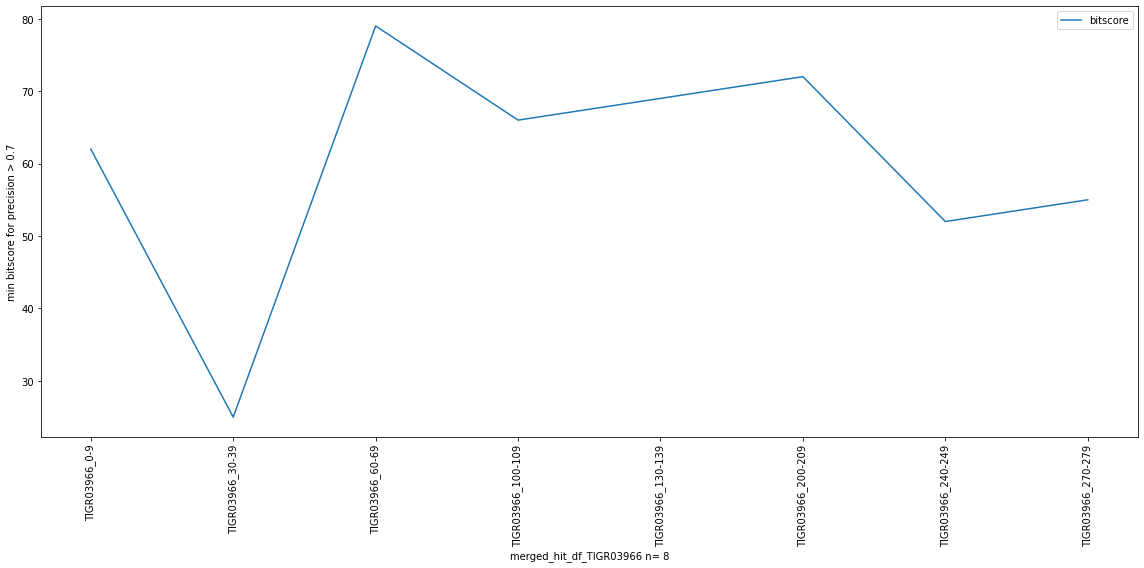

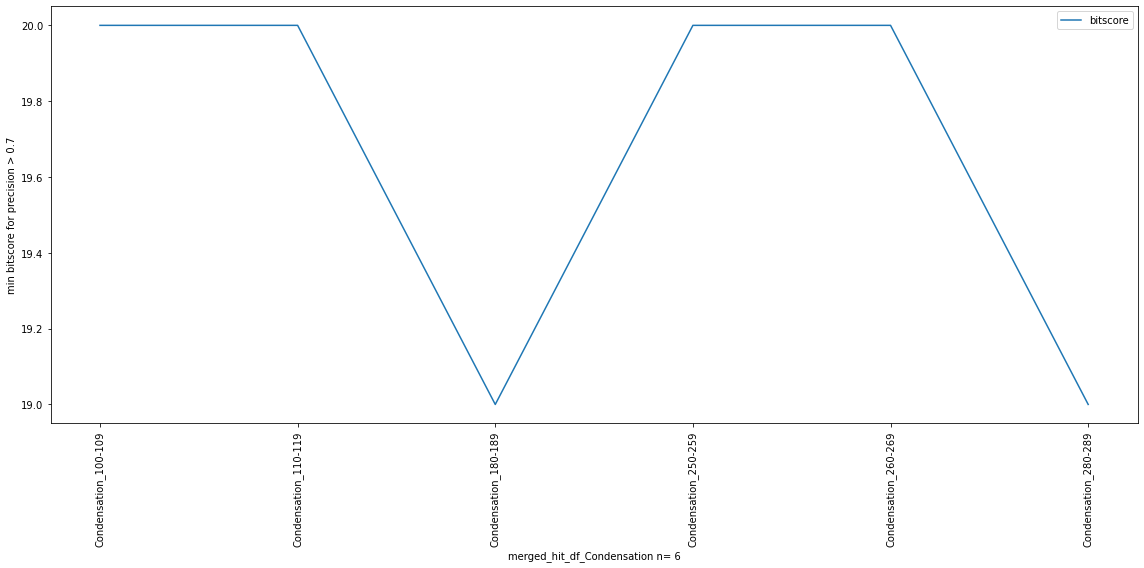

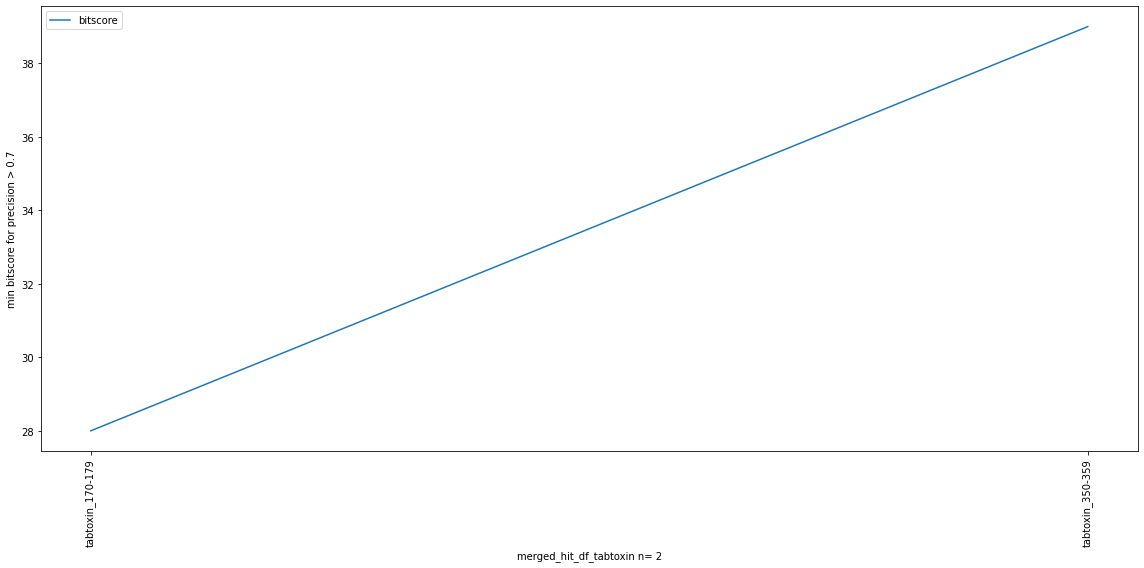

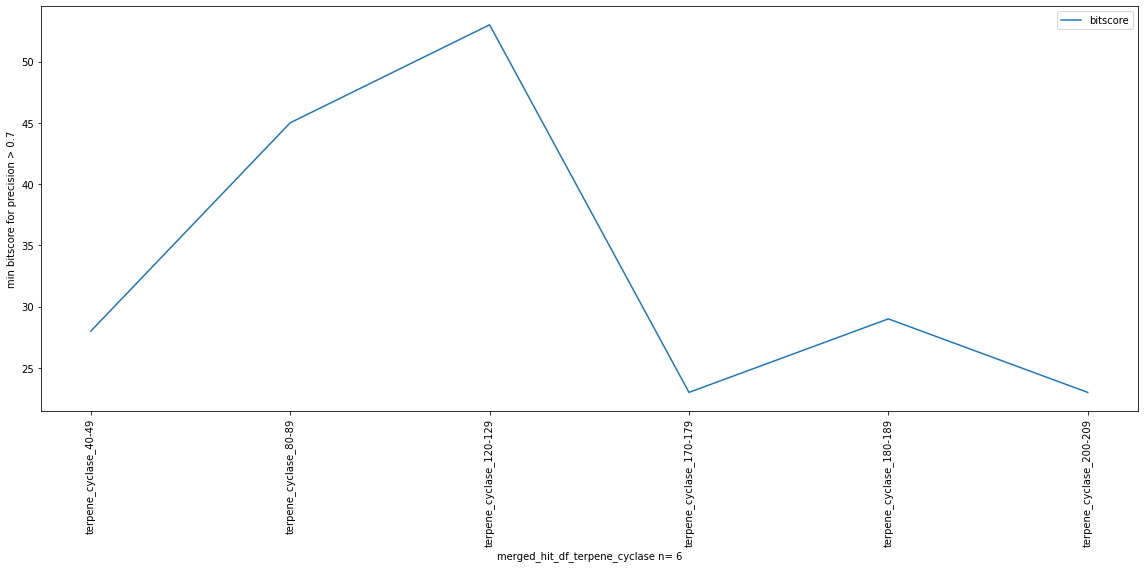

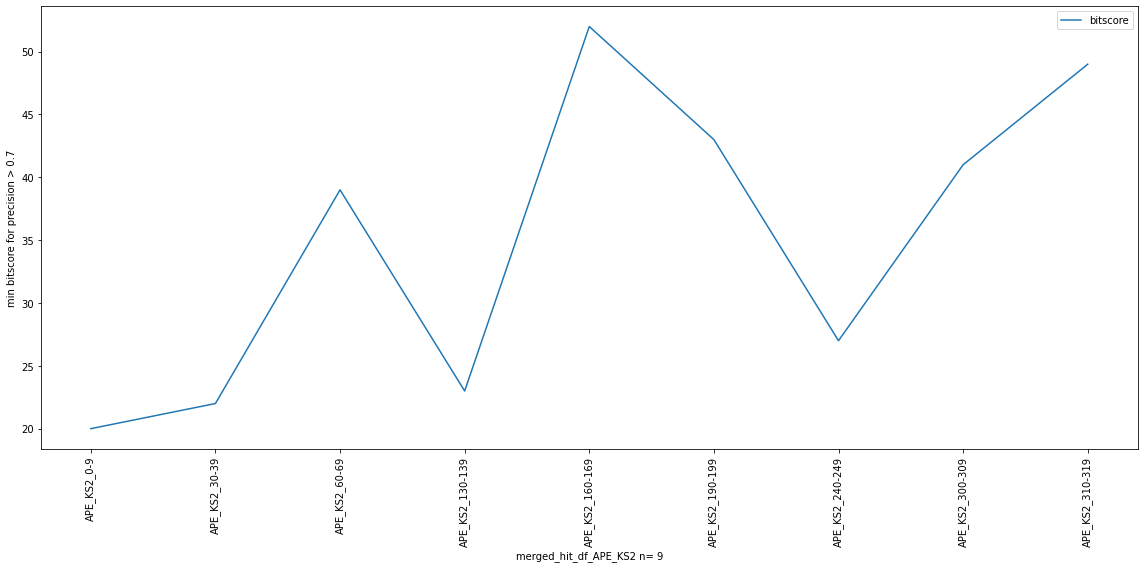

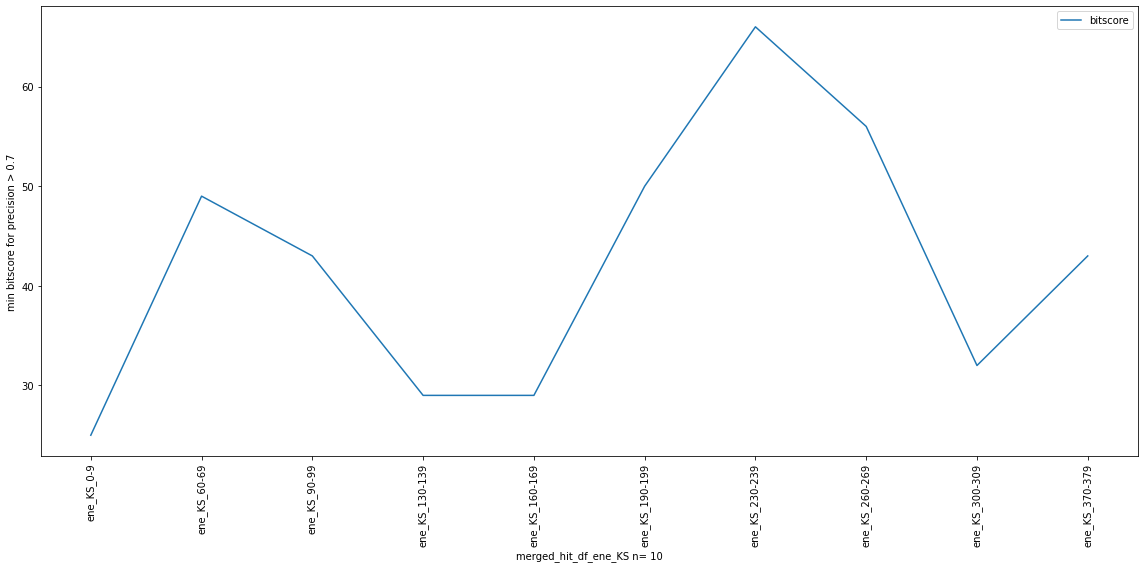

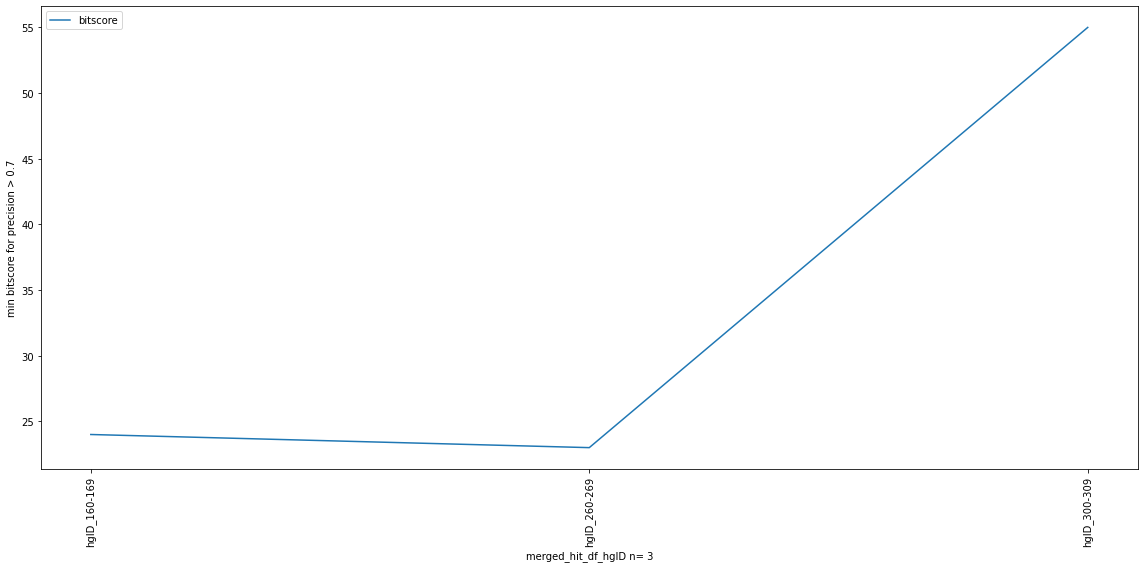

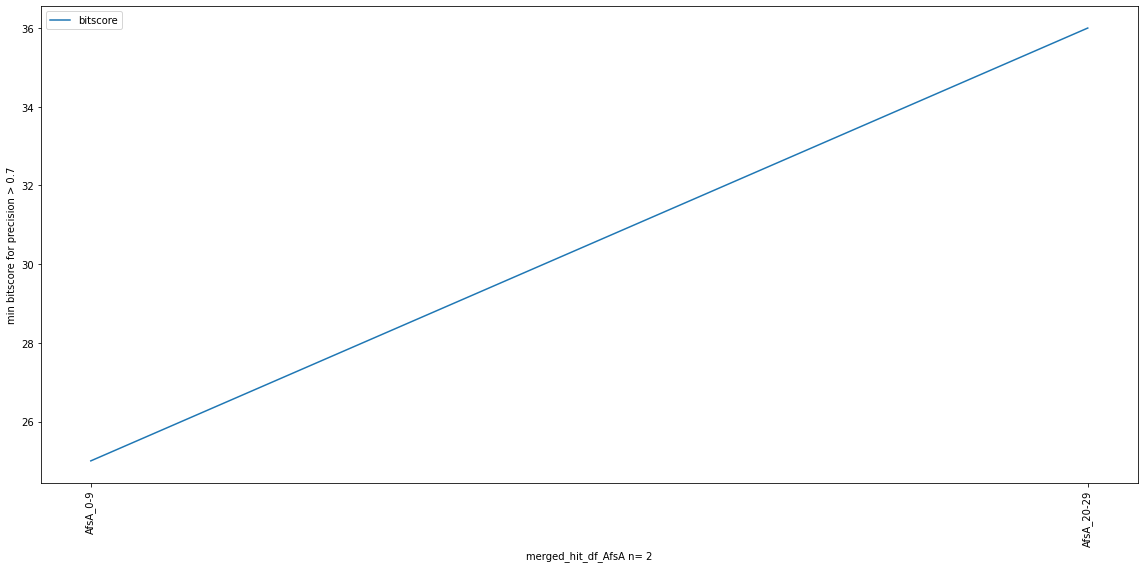

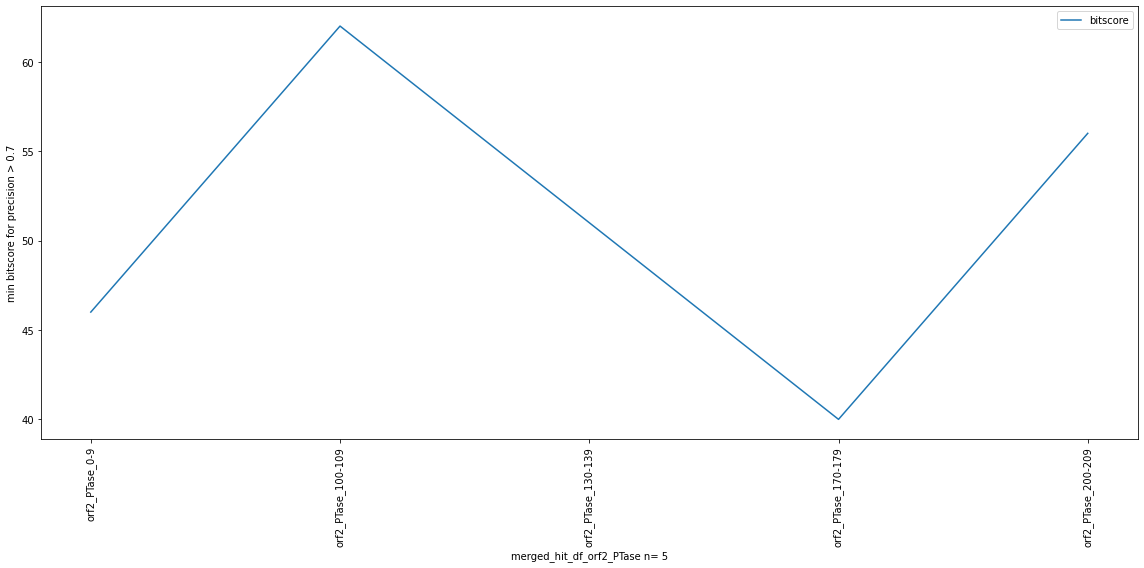

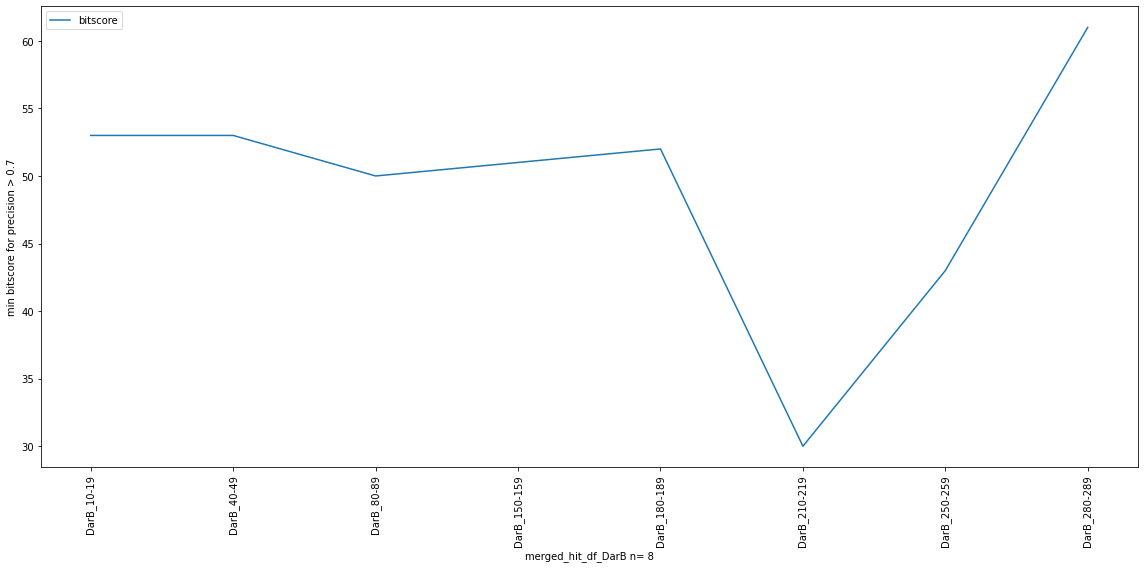

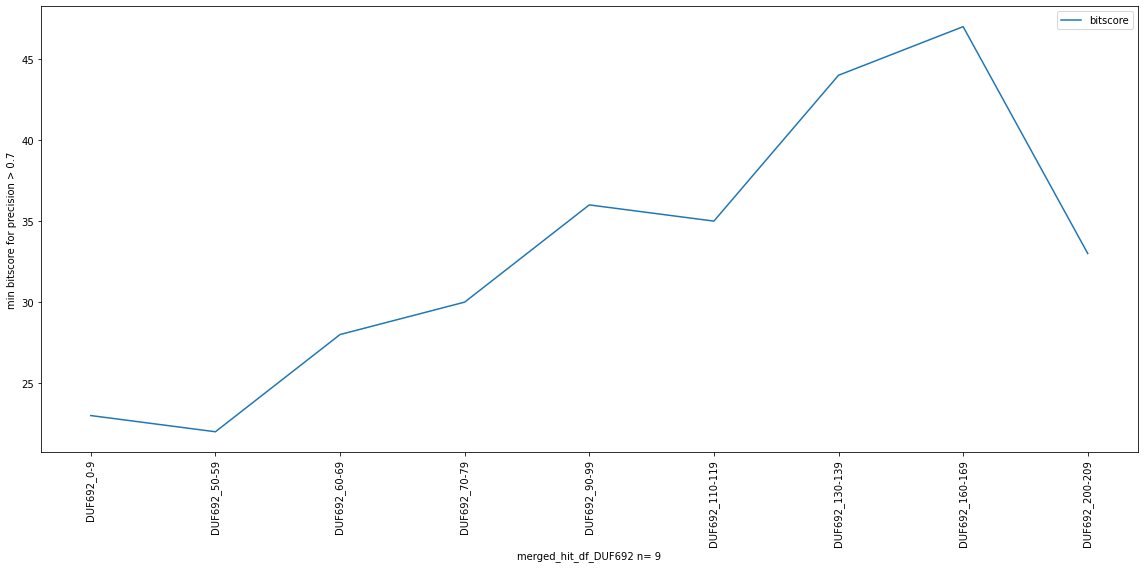

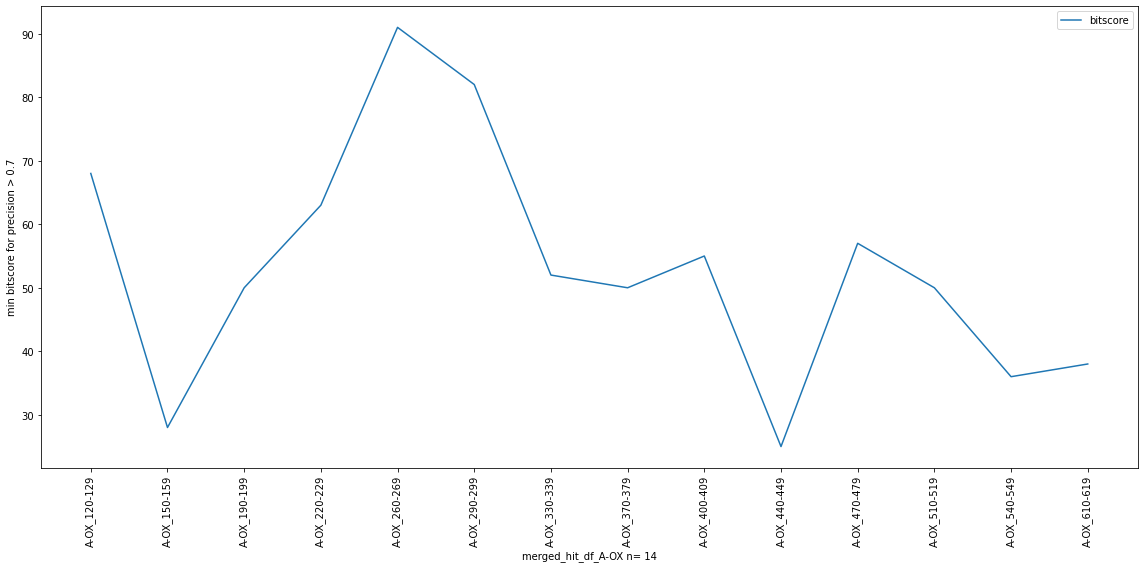

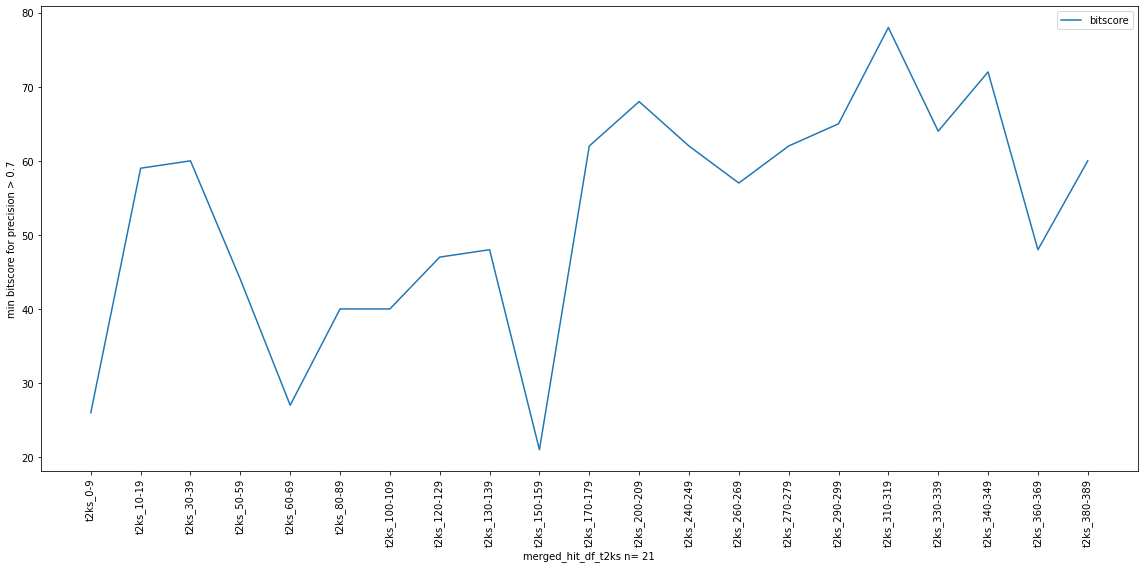

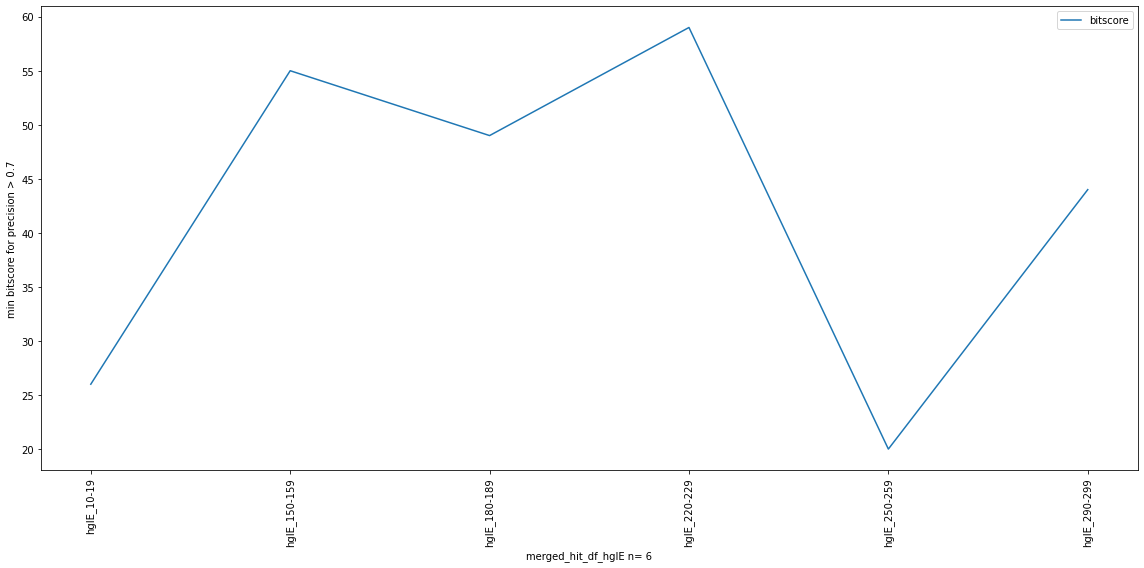

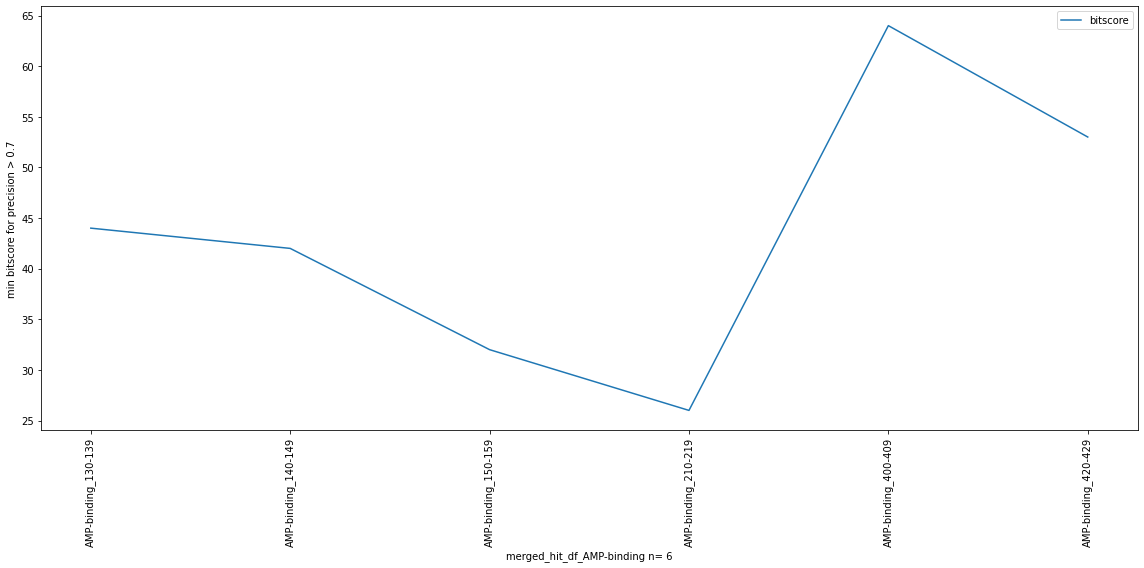

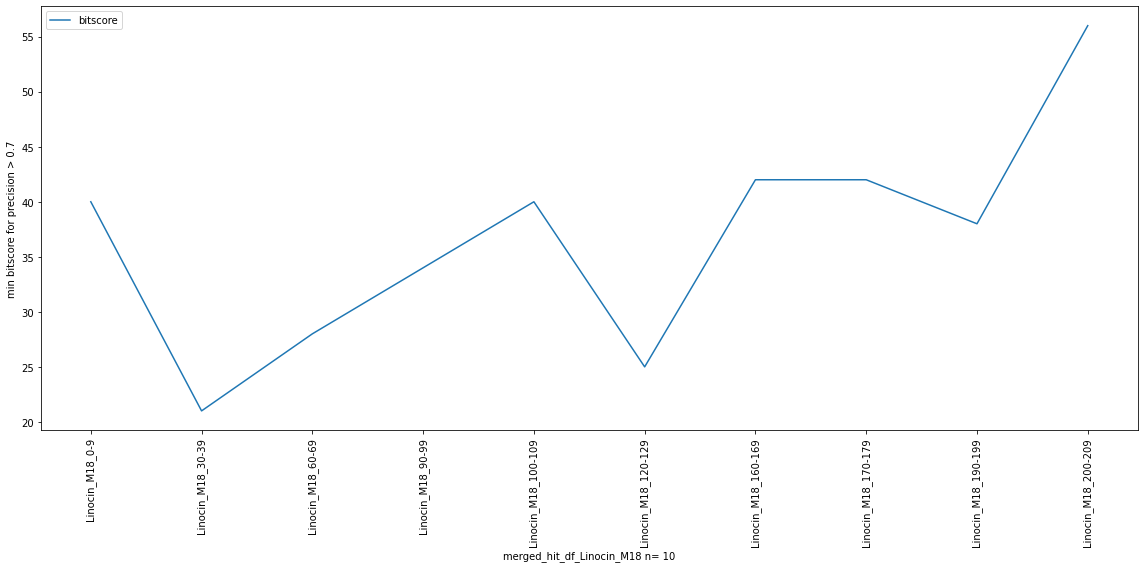

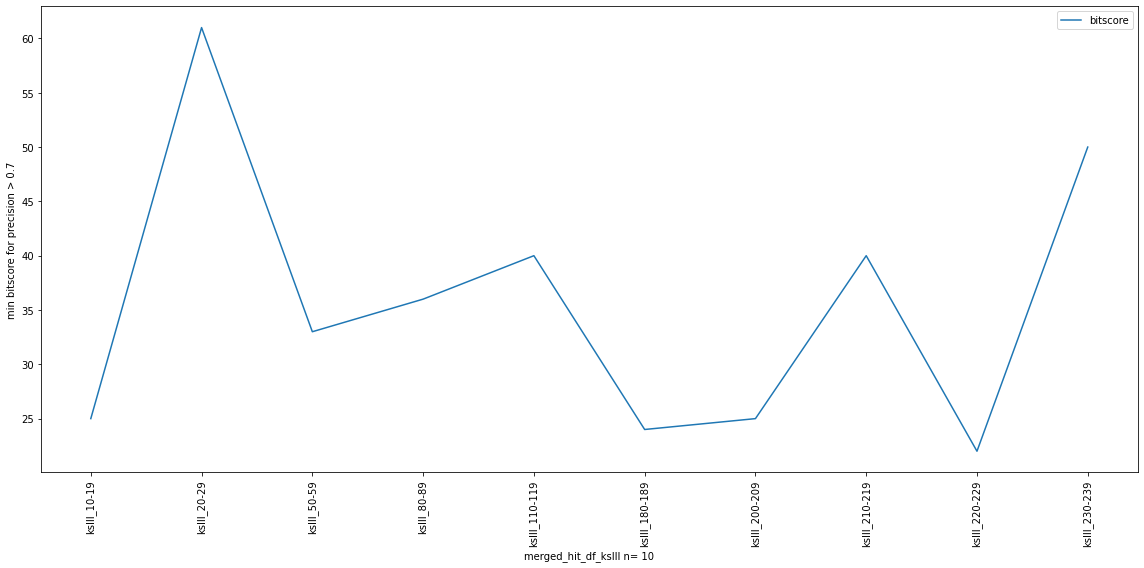

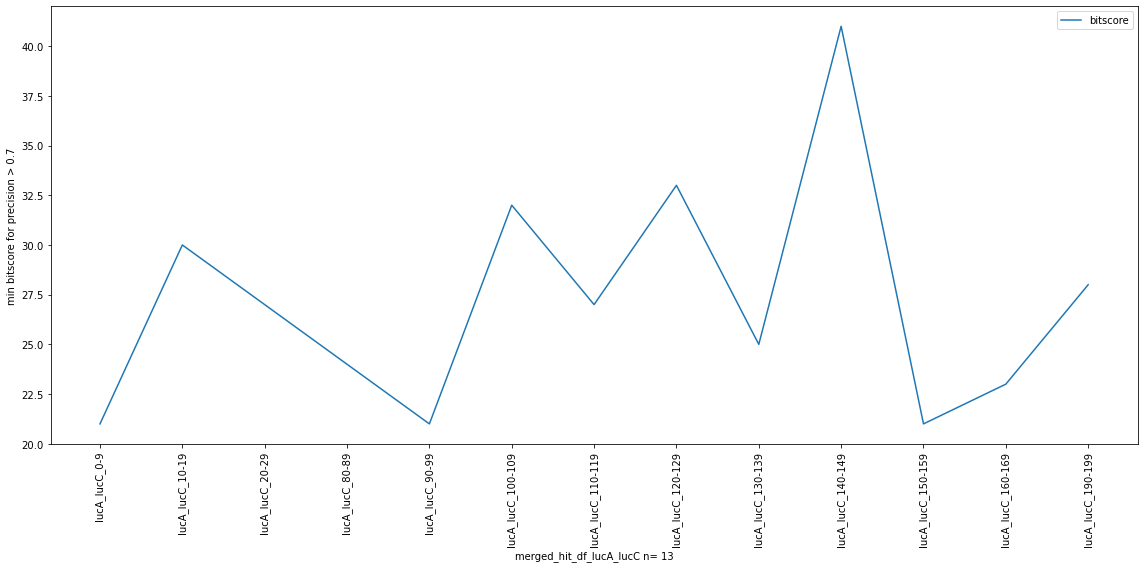

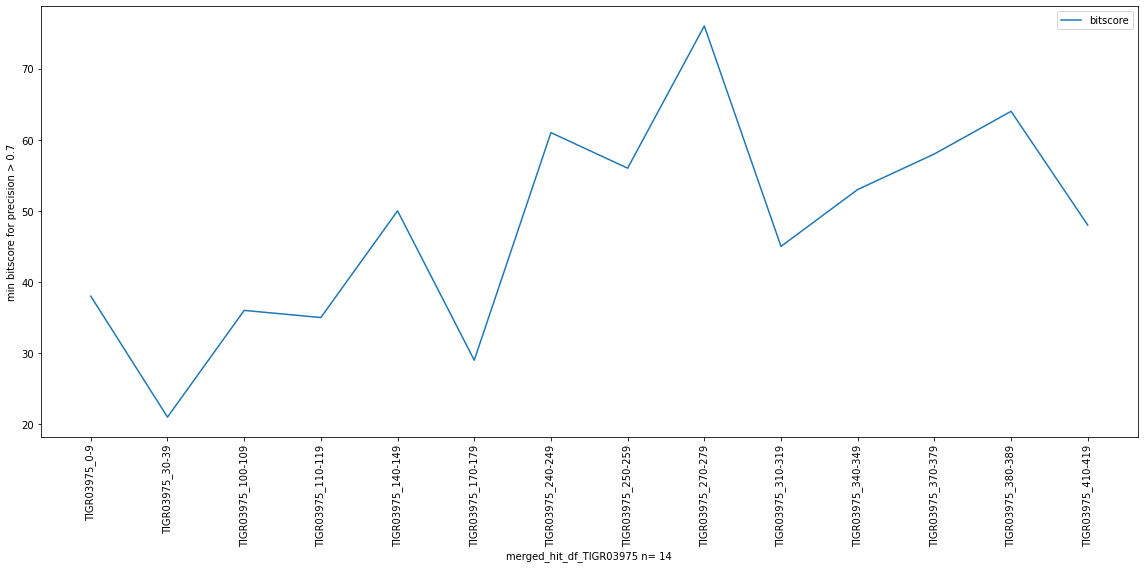

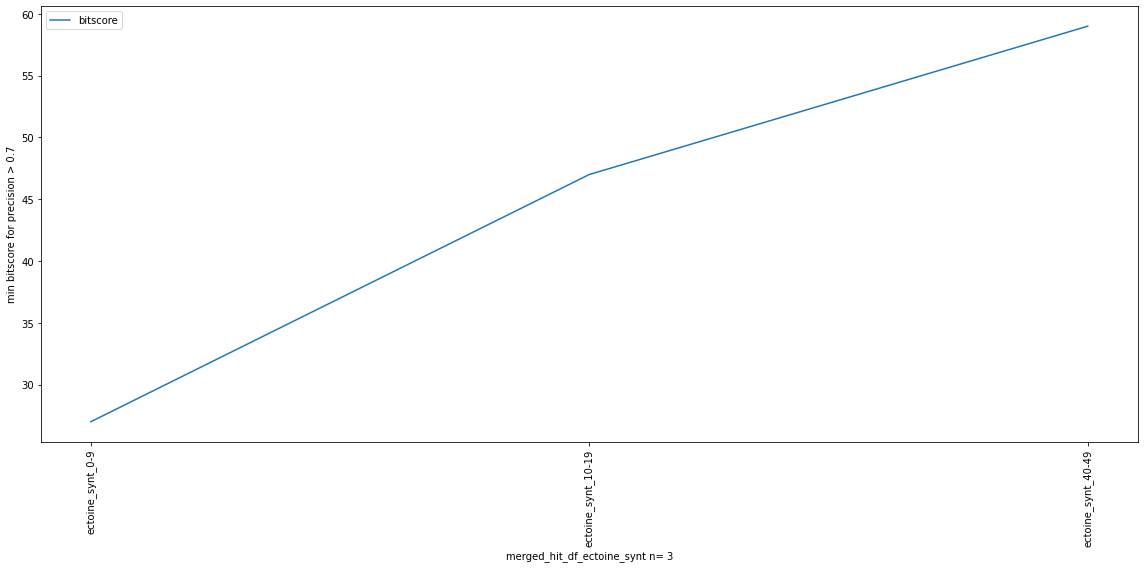

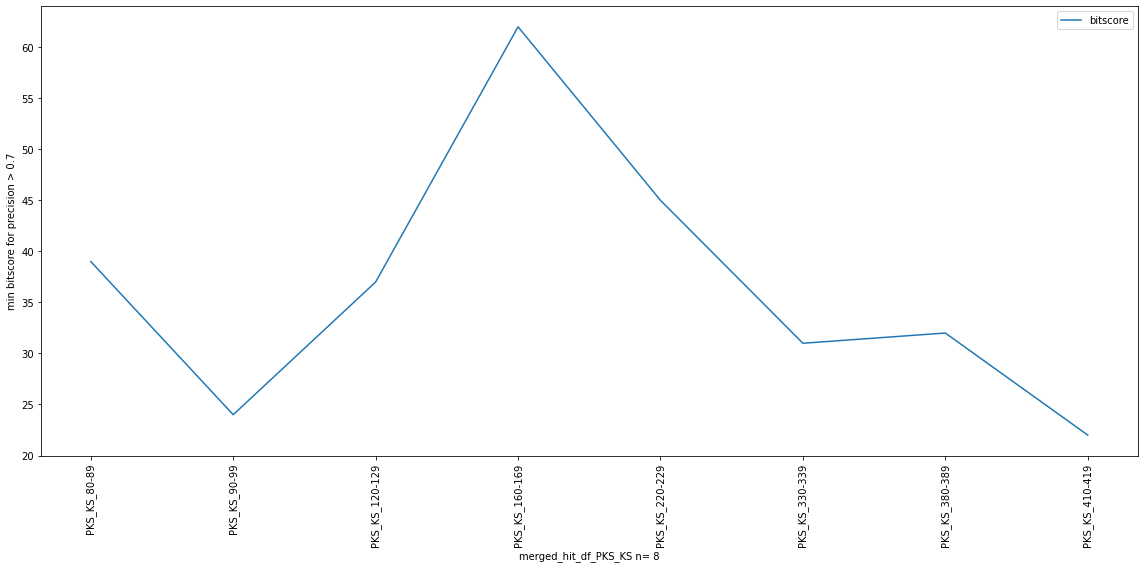

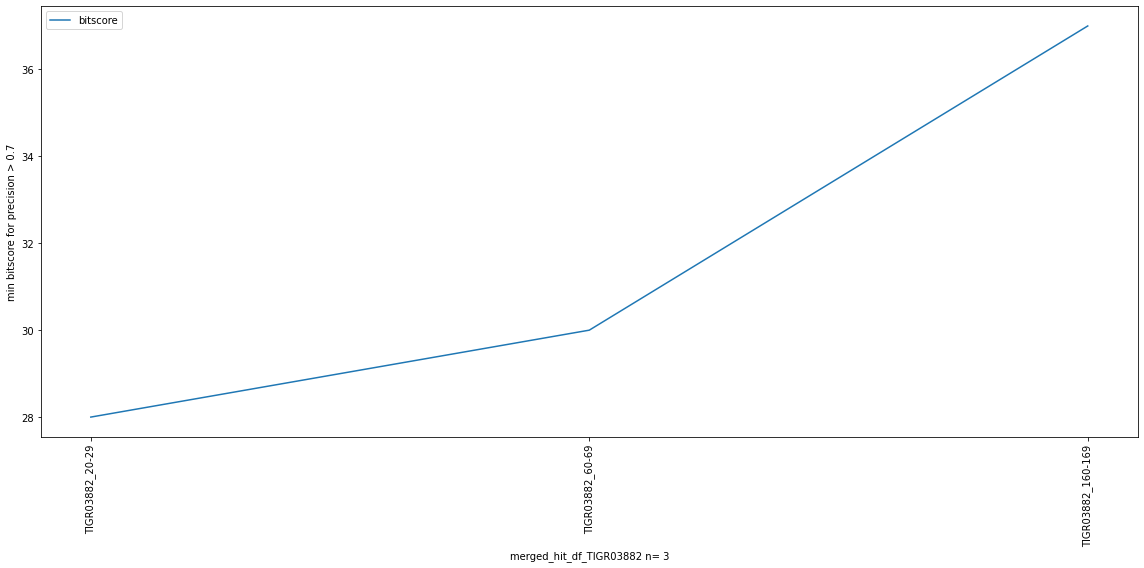

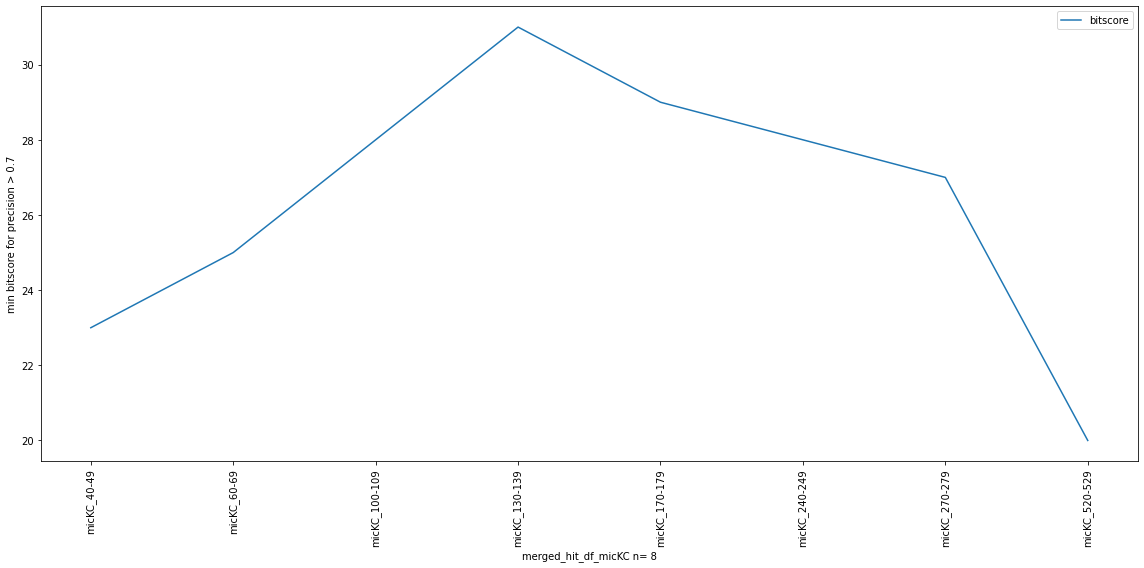

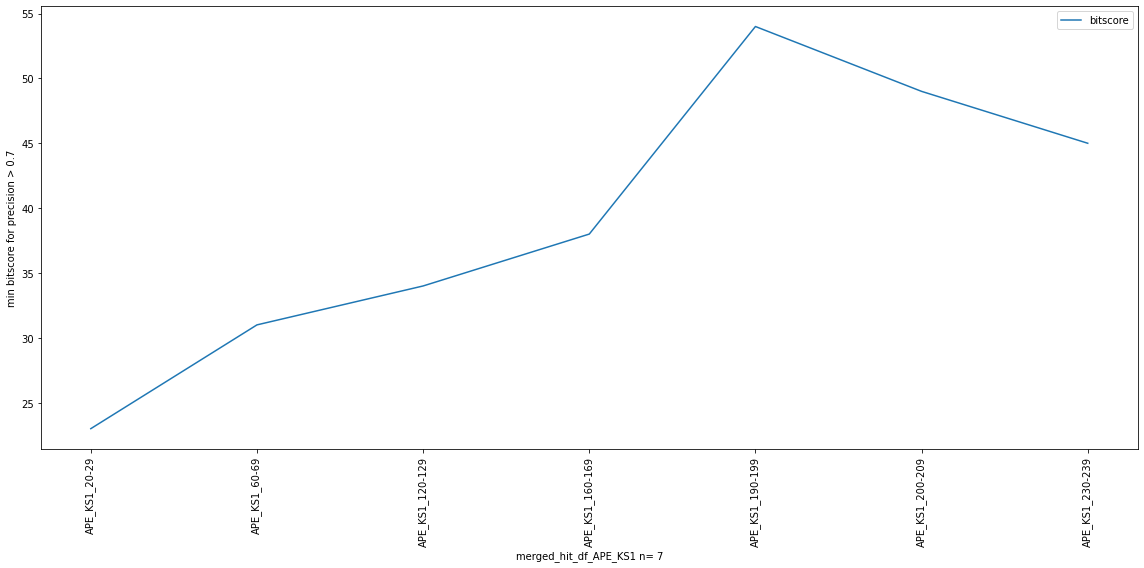

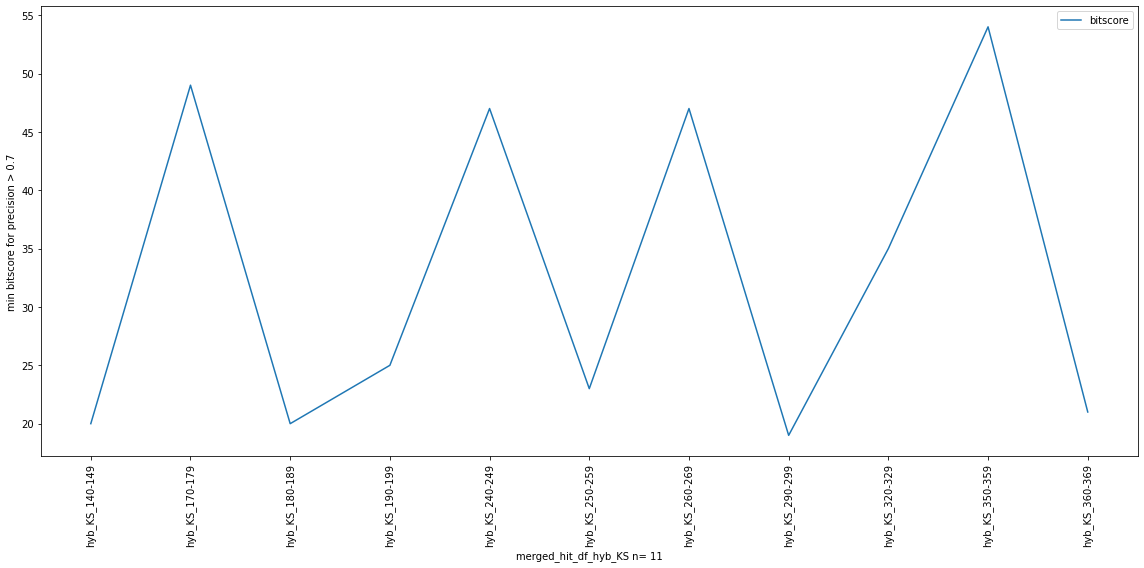

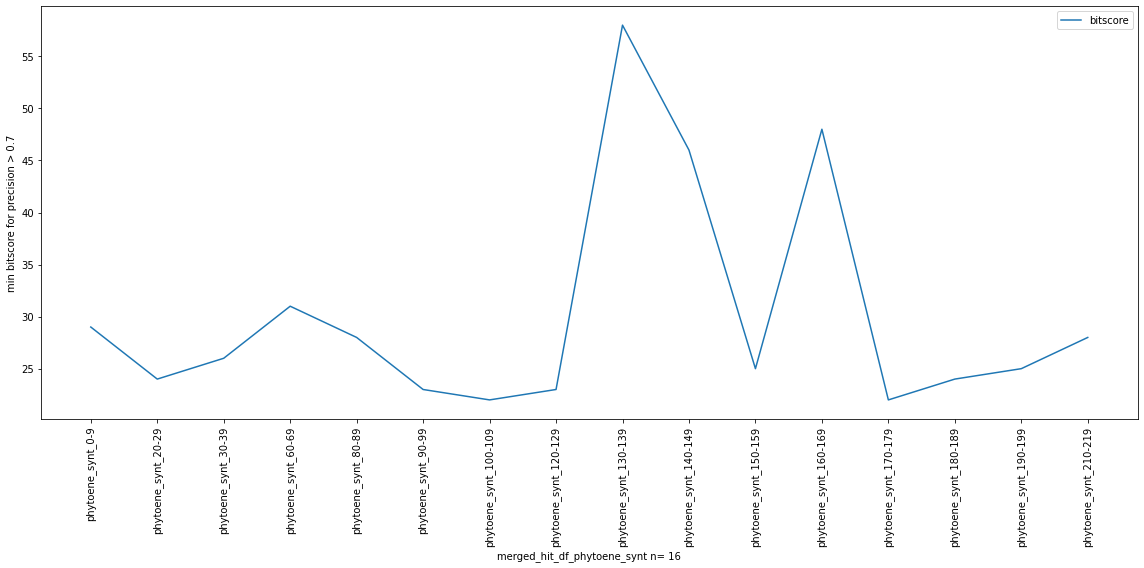

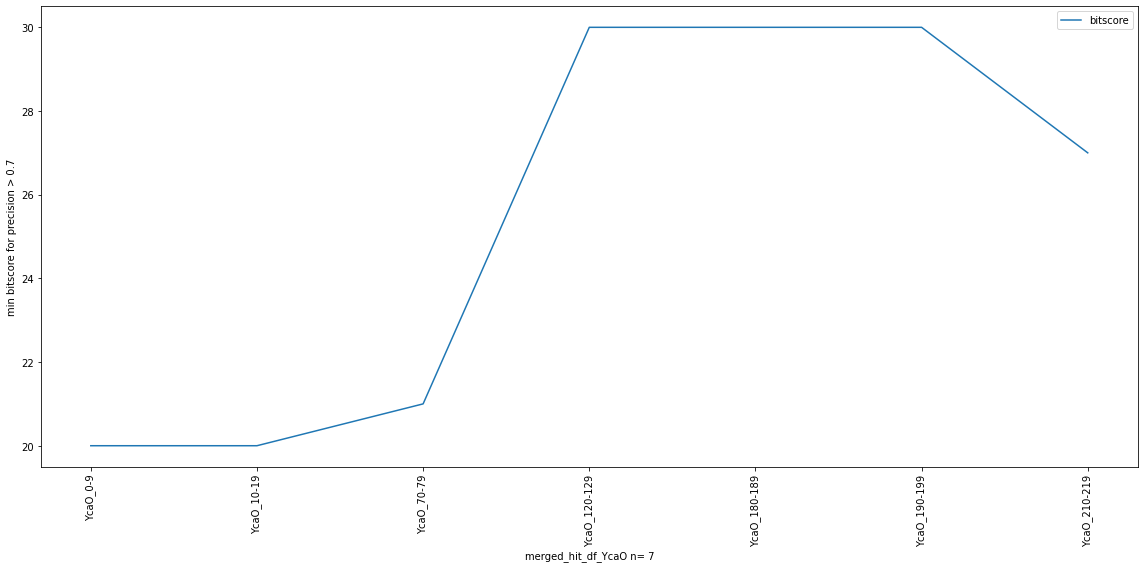

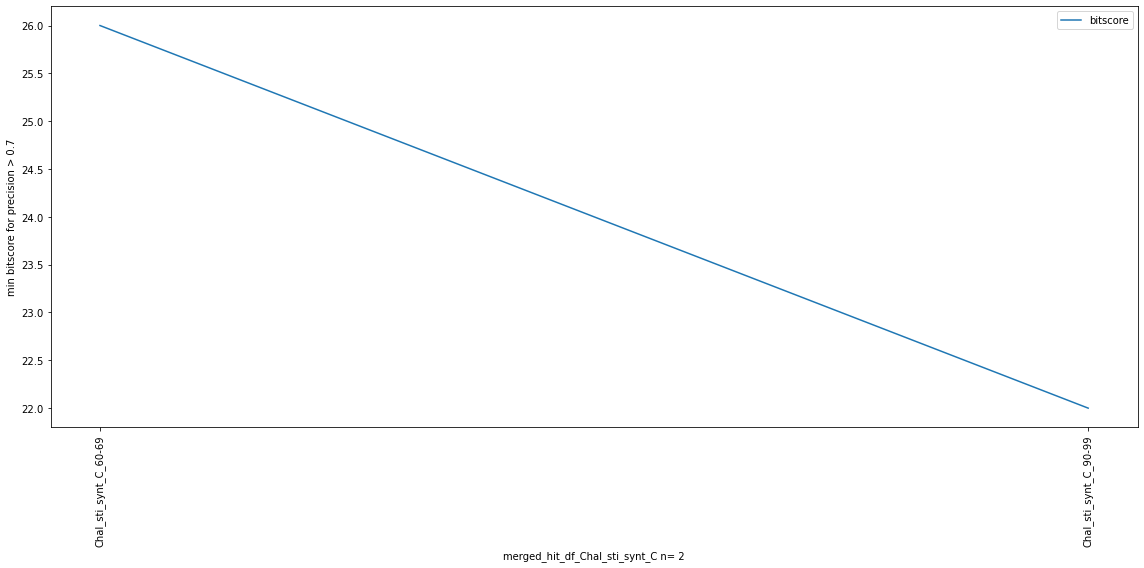

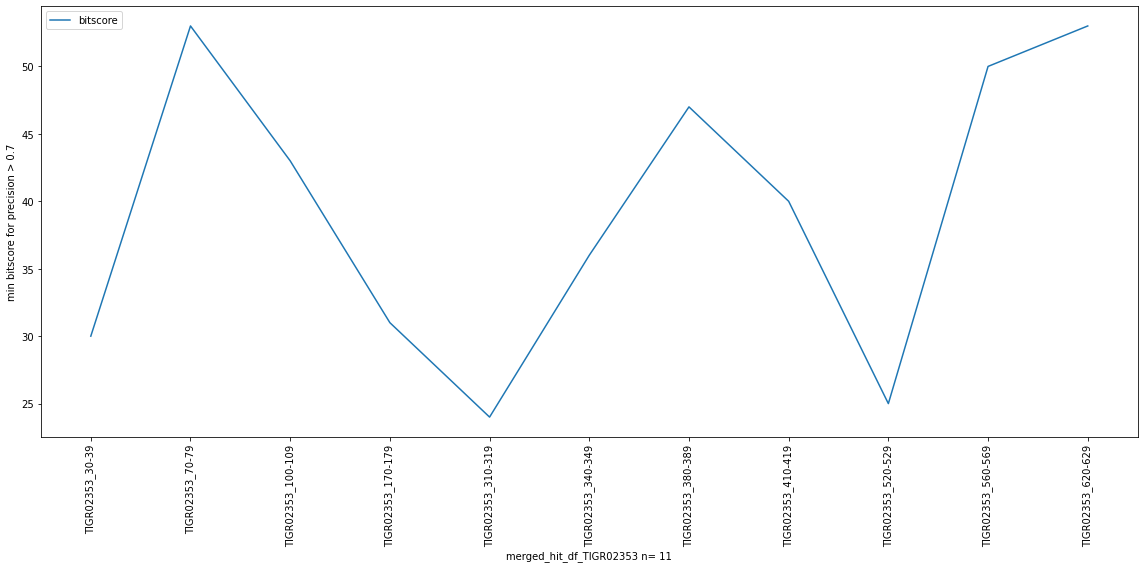

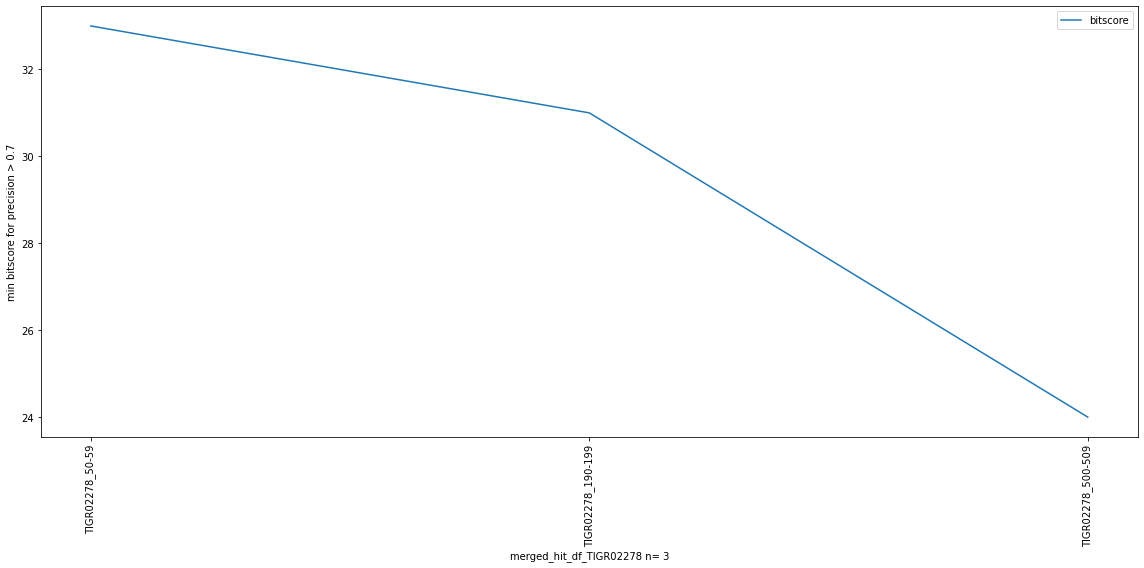

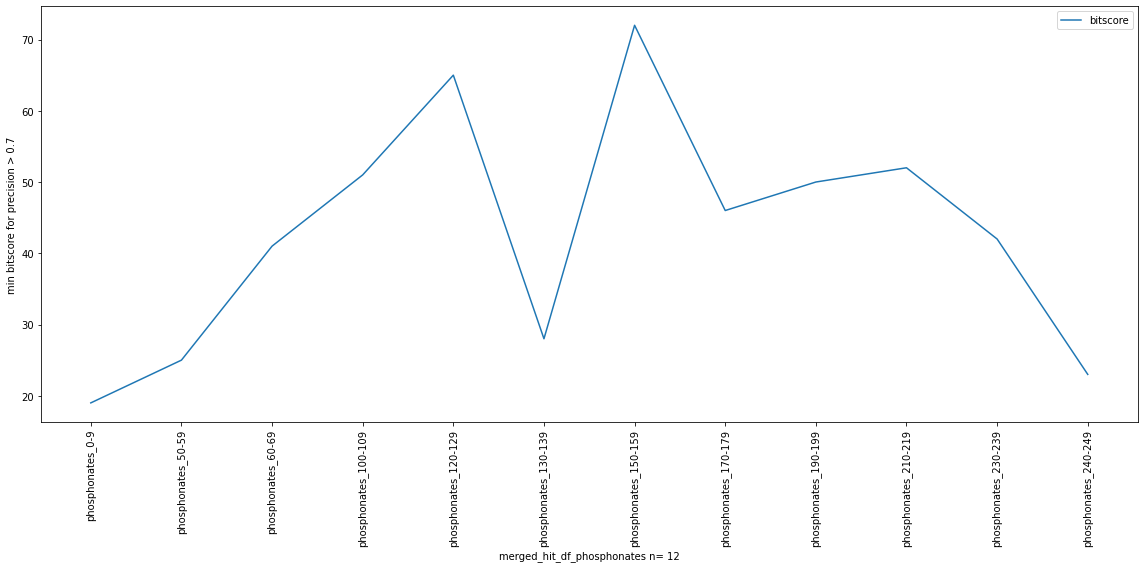

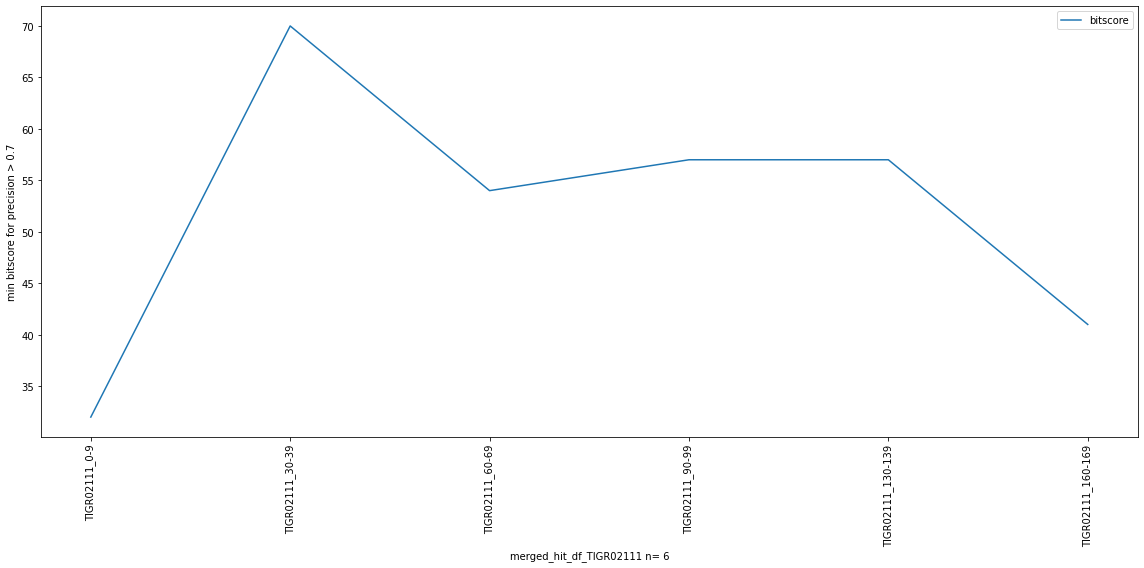

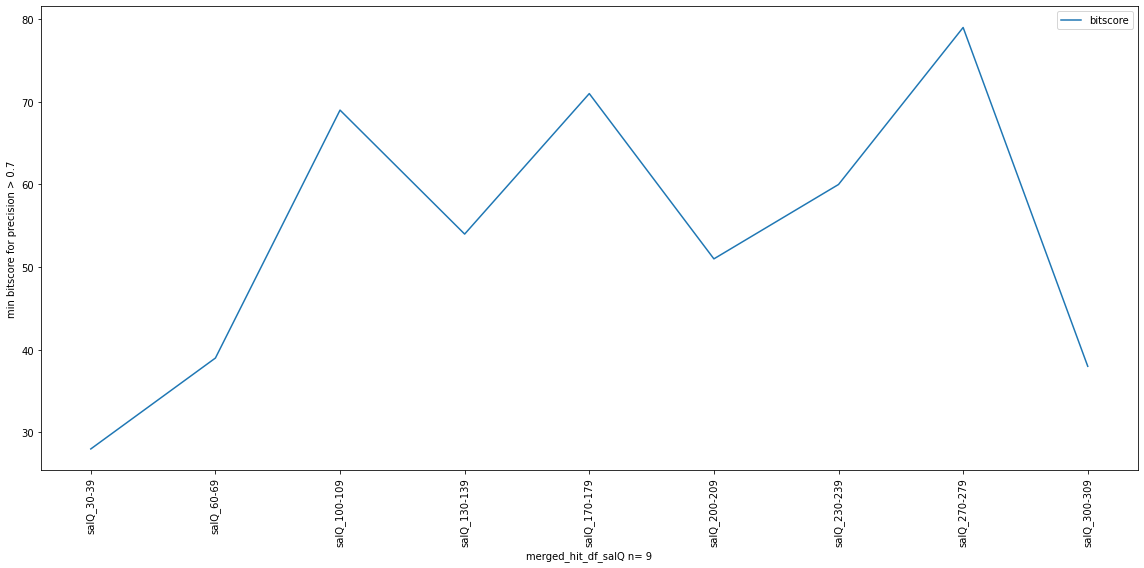

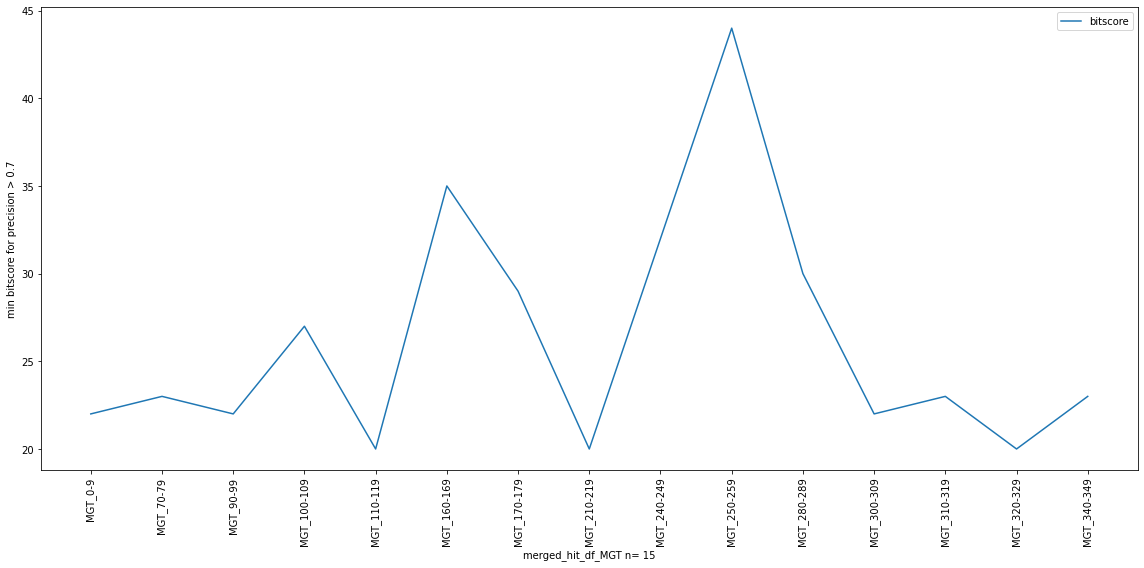

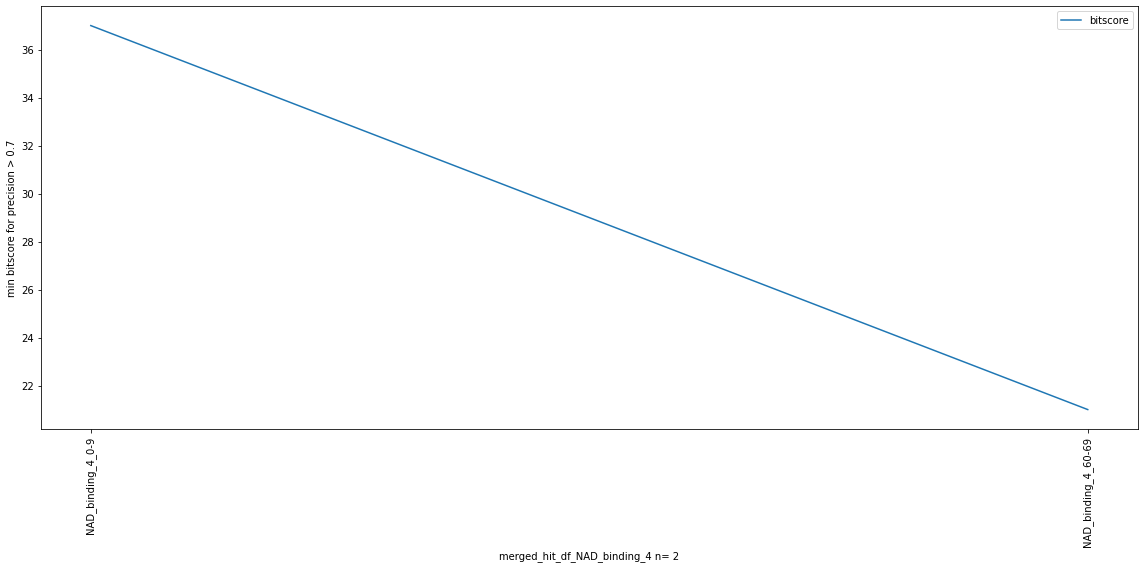

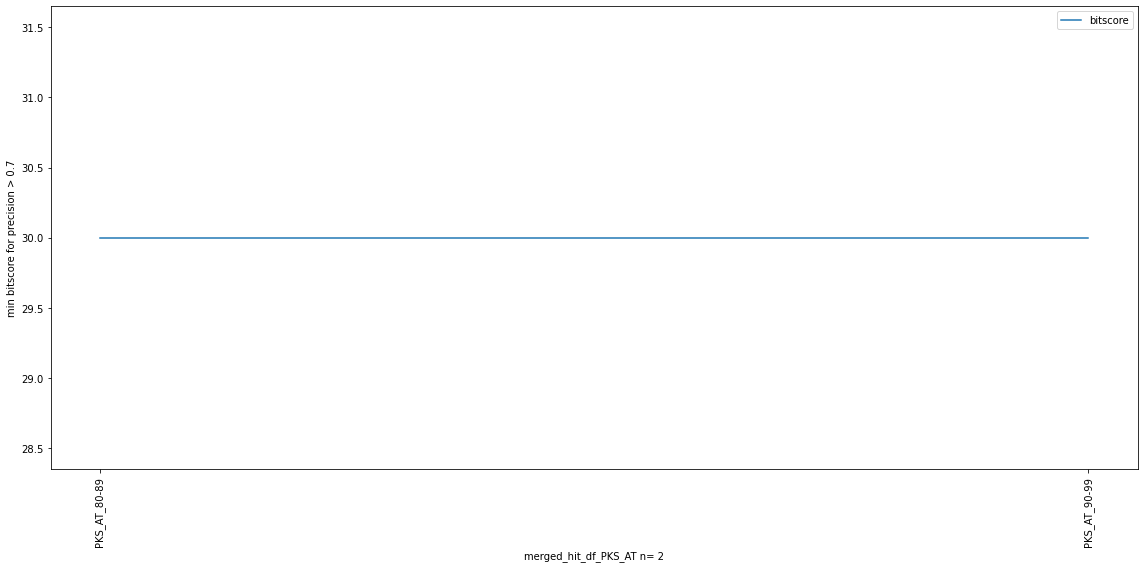

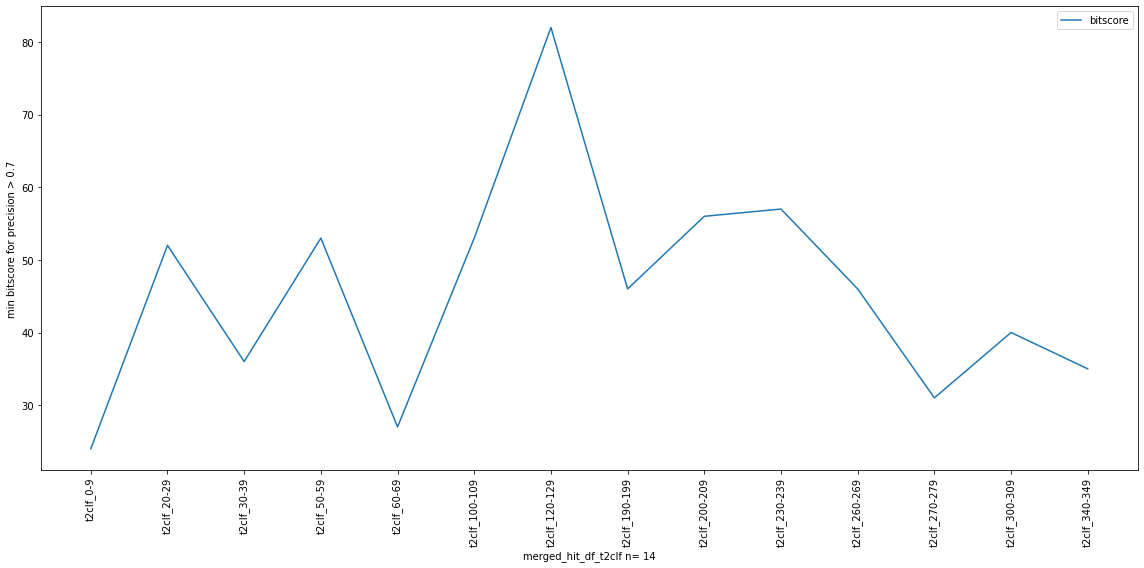

In [8]:
#%%time
# Wall time: 1min 50s

merged_dir=set_wd+'/merged'
input_dir=set_wd+'/merged/subset_dfs'
output_dir=set_wd+'/merged/precision_dfs_70'
plot_dir=set_wd+'/merged/precision_plots_70'


# make an output dir
if os.path.isdir(output_dir):
    print(output_dir,'exists already')
else:
    print('Making', output_dir)
    os.mkdir(output_dir)
    
# make an output dir
if os.path.isdir(plot_dir):
    print(plot_dir,'exists already')
else:
    print('Making', plot_dir)
    os.mkdir(plot_dir)



# Copied this lookup table from the previous cell. Still need to take this into account because I'm
# using the hmm filename instead of the hmm name in the file!
hmm_name_lookup_dict = {}
for hmm_filename in os.listdir(set_wd+'/antismash_hmms/'):
    if re.findall('.hmm', hmm_filename):
        filename = hmm_filename.split('.')[0]
        with open(set_wd+'/antismash_hmms/'+hmm_filename) as f:
            for line in f:
                if line.startswith('NAME'):
                    hmm_name_lookup_dict[filename] = line.split(' ')[-1].strip('\n')


# def sliding_window(input_path, elements, window_size, step):
def sliding_window(input_path, window_size=9, step=10, cutoff=0.95):
    working_df = pd.read_csv(input_path, sep=',')
    # take into account the hmm-name/hmm-filename discrepancy
    working_df['hmm'] = working_df['hmm'].map(hmm_name_lookup_dict)
    # needed to split up the table by the appropriate amount of intervals
    hmm_len = list(range(0,int(max(working_df['start']))))
    input_filename = input_path.split('/')[-1]
    # This is very much filename dependent. Make sure to adapt if the naming has been different.
    hmm_name = '_'.join(input_filename.split('_')[3:])[:-4]
    print('processing', input_filename, hmm_name)
    precision_df = pd.DataFrame(columns=['bitscore', 'interval', 'true_positive_count', 'false_positive_count', 'false_negative_count', 'precision', 'filename'])    
    if len(hmm_len) <= window_size:
        return hmm_len
          
    # This bit here defines an interval in terms of starting position of hmm
    for i in range(0, len(hmm_len) - window_size + 1, step):
        # Get all values in the given range of start values | include the constant values of 'FN' at the end
        return_df = working_df[ (working_df['start'].isin(hmm_len[i:i+window_size])) | (working_df['occurrence'] == 'FN')]
        # make sure that there are values in the df and that not all values in the bitscore column are empty
        if len(return_df) >= 2 and not return_df['bitscore'].isna().sum() == len(return_df):


            # This bit here is scanning across bitscore windows of each interval
            rows = []
            for score in range(math.floor(min(return_df['bitscore'])), math.ceil(max(return_df['bitscore']))):
                # Define a dataframe (per interval) in terms of bitscore, carry through 'FN'
                # The result_gt dataframe fundamentally defines the data that TP/FP/FN are based on.
                # The result_gt dataframe remains constant in length, but the distribution of TP/FP/FN changes
                # I.d. counts of TP/FP/FN must equal the length of return_gt 
                
                # TP = both
                # FP = hmm only, not map (left only)
                # TN = no hmm hit and no mapping hit (#total reads)
                # FN = no hmm hit, but maps (right only)
                
                result_gt = return_df[ (return_df["bitscore"] >= score) | (return_df['occurrence'] == 'FN') ]
                
                
                # True positive count: hmm needs to be the one described in the filename, and mapping
                TP_df = result_gt[ (result_gt["hmm"] == hmm_name) & (result_gt['mapping_seq'].astype(str).str.contains(hmm_name, na=False)) ]
                true_positive_count = len(TP_df)


                # False positive count: hmm needs to be the one described in the filename, but no mapping
                FP_df = result_gt[ (result_gt["hmm"] == hmm_name) & (~result_gt['mapping_seq'].astype(str).str.contains(hmm_name, na=False)) ]
                false_positive_count = len(FP_df)


                # False negative count: either hmm is not hmm_name or FN
                # One conditon for FN is hitting a different hmm name but with the same read mapping to the intended hmm
                # Another condition is correct mapping, but with the score being below 'score'
                # I.e. to make the score cutoff work, need to subset return_df, not result_gt!
                FN_df = return_df[ ( (return_df["hmm"] != hmm_name) & (return_df['mapping_seq'].astype(str).str.contains(hmm_name, na=False)) ) | (return_df["bitscore"] < score) ]
                false_negative_count = len(FN_df)


                # Raw version
                rows.append([hmm_name, score, i, true_positive_count, false_positive_count, false_negative_count])
                # Normalised version
#                 rows.append([hmm_name, score, i, true_positive_count/len(return_df), false_positive_count/len(return_df), false_negative_count/len(return_df)])

            count_df = pd.DataFrame(rows, columns=['hmm_name', 'bitscore', 'interval', 'true_positive_count', 'false_positive_count', 'false_negative_count'])
    
            # To calculate the point of maximum distance between true positive and false positive
            if len(count_df) > 0:                
                # Account for case where denominator is 0. If so, precision is set to 0
                try:
                    count_df['precision'] = count_df.apply(lambda row: row.true_positive_count / (row.false_positive_count + row.true_positive_count), axis=1)
                except ZeroDivisionError:
                    count_df['precision'] = count_df.apply(lambda row: 0, axis=1)

                # concatenate all 'points of crossover' into a single df
                precision_df = pd.concat([precision_df, (count_df[count_df['precision'] >= cutoff]).iloc[:1,]])
                precision_df['filename'] = os.path.basename(input_path).split('.')[0]
            
                # Specific to using absolute values as precision needs to be calculated with relative

    # Confirm this calculation
    if len(precision_df) > 1:
        precision_df['chunk'] = precision_df.apply(lambda row: row.hmm_name+'_'+str(row.interval)+'-'+str(row.interval + window_size), axis=1)
        precision_df.drop(['hmm_name'], axis=1, inplace=True)
        # reordering columns for vanity reasons
        precision_df = precision_df[['chunk', 'interval', 'bitscore', 'precision', 'true_positive_count', 'false_negative_count', 'false_positive_count', 'filename']]
        precision_df.to_csv(output_dir+'/'+'precision_'+input_filename.split('.')[0]+'.csv', sep=',', index=None)
        ax = precision_df.plot(x='chunk', y='bitscore', xlabel=input_filename.split('.')[0]+' n= '+str(len(precision_df)), ylabel='min bitscore for precision > '+str(cutoff), figsize=(16, 8))
        ax.set_xticks(np.arange(len(precision_df)))
        ax.set_xticklabels(precision_df.chunk, rotation=90)
        plt.tight_layout()
        plt.savefig(plot_dir+'/'+'precision_'+input_filename.split('.')[0]+'.png')


input_path_list = []
for file in os.listdir(input_dir):
    input_path = input_dir+'/'+file
    input_path_list.append(input_path)

    
# This is not perfect, i.e. it cuts off the final positions if less than the step size is left
# for path in input_path_list[0:20]:
for path in input_path_list:
    check_df = pd.read_csv(path)
    if len(check_df) >= 2:
        sliding_window(path, 9, 10, 0.7)

### sliding_window(input_path, window_size=9, step=10, cutoff=0.95):


print('Done')

# Applying the models

The precision_dfs returned from the previous cell are for all intents and purposes predictive models for all hmms that a precision_df was generated for. While this entire anaylsis starts with (currently) 297 hmms, it is very unlikely that 297 models will be returned at the end due to several reasons. For example it is possible that even with an arbitrarily large genome collection some of the hmms do not generate a hit. Even if hits are generated, they may be disregarded none of the intervals ever reach the precision threshold set. Otherwise, there are also several places where dataframes are disregarded when they only have one row or if a division by zero occurs. This is mostly due to practical considerations and it can most likely be improved upon in future iterations of this tool.

### Applying the models to an arbitrary collection of reads

#### Required inputs

read_hmm_dir: A directory containing hmmsearch results of searching the same 297 hmms against a database of metagenomic reads. The step of generating the files in this direcory is equivalent to the hmmsearch step in Analysis stream 2, i.e. output files need to be produced as both .tbl and .aln.

model_dir: A directory containing all the precision_dfs generated in the previous script


#### Generated outputs

Outputs are only generated for cases in which hmm hits are generated in the (meta)genome, and for which a precision_df is available. Three directories and one file are generated:
- above_threshold/ contains a .csv file for each hmm, listing the reads for which were found in the hmmsearch results that both originate from the same interval, and have a bitscore above the bitscore at which the model exceeds the threshold set in the script above (default precision >0.95).
- below_threshold/ contains a .csv file for each hmm, listing reads which were found in the same interval, but were below the set threshold.
- raw/ contains a .csv file for each hmm for which any reads were identified by hmmsearch
- all_hmm_hits.csv is a collection of all reads that generated hits during the hmmsearch step. This file is split on the hmm column to generate the individual .csv files in the raw/ directory.

In [9]:
%%time
# Wall time: 1min 58s

def identify(read_hmm_dir, model_dir, out_dir):
    # output_dir name is based on input dir name
    output_dir=out_dir+read_hmm_dir.split('/')[-1]
    raw_classified_dir=output_dir+'/raw'
    above_classified_dir=output_dir+'/above_threshold'
    below_classified_dir=output_dir+'/below_threshold'

    # make output dirs
    if os.path.isdir(output_dir):
        print(output_dir,'exists already')
    else:
        print('Making', output_dir)
        os.makedirs(output_dir)

    if os.path.isdir(raw_classified_dir):
        print(raw_classified_dir,'exists already')
    else:
        print('Making', raw_classified_dir)
        os.makedirs(raw_classified_dir)

    if os.path.isdir(above_classified_dir):
        print(above_classified_dir,'exists already')
    else:
        print('Making', above_classified_dir)
        os.makedirs(above_classified_dir)

    if os.path.isdir(below_classified_dir):
        print(below_classified_dir,'exists already')
    else:
        print('Making', below_classified_dir)
        os.makedirs(below_classified_dir)


    # Need to read in and compile a dataframe from both hmm out files, aln and tbl of a metagenome
    # - aln required for position of the alignment of the read against the hmm
    # - tbl required for bitscore result of the respective alignment
    # This is basically the same code as previously used for parsing hmm results out of the genome collection

    search_dict = {}
    for hmm_out_file in os.listdir(read_hmm_dir):

        if re.findall('.aln', hmm_out_file):
#             print('\n'+'Parsing hmms in', hmm_out_file)
            hmm_file_path = read_hmm_dir+'/'+hmm_out_file

            # Read in aln files
            try:
                aln_file = AlignIO.read(hmm_file_path, "stockholm")
                counter = 0
                for record in aln_file:
                    read_id = '/'.join(record.id.split('/')[0:-1])
                    seq = str(record.seq)
                    start = len(seq) - len(seq.lstrip('-'))
                    end = len(seq.rstrip('-')) - 1

                    search_dict[read_id+'---'+hmm_out_file.split('.')[0]] = [hmm_out_file.split('.')[0], start, end] # OG line

                with open(read_hmm_dir+'/'+hmm_out_file.split('.')[0]+'.tbl') as handle:
                    for queryresult in SearchIO.parse(handle, 'hmmer3-tab'):
                        for hit in queryresult.hits:
                            # Sometimes, a hit comes through in the .tbl file, that seems to have a higher e-value
                            # than the one set in the hmmsearch threshold (0.01). These hits are not recorded in
                            # the corresponding .aln file, which causes a KeyError in the dict operation below.
                            # Enclosed it in a try-except loop to handle these cases. Maybe a hmmsearch bug?
                            try:
                                search_dict[hit.id+'---'+hmm_out_file.split('.')[0]].append(hit.evalue)
                                search_dict[hit.id+'---'+hmm_out_file.split('.')[0]].append(hit.bitscore)
                            except KeyError:
                                print('Skipping:', hit.id+'---'+hmm_out_file.split('.')[0]+'.', 'Found in .tbl file but not in .aln file.')
#                             search_dict[hit.id+'---'+hmm_out_file.split('.')[0]].append(hit.evalue)
#                             search_dict[hit.id+'---'+hmm_out_file.split('.')[0]].append(hit.bitscore)

            except ValueError:
                print('No records found in aln file:', hmm_out_file)

    # try-except loop to account for situations where a sample contains no hmm hits at all
    search_df = pd.DataFrame.from_dict(search_dict, orient='index', columns=['hmm', 'start', 'end', 'evalue', 'bitscore'])
    temp_df = search_df.reset_index().rename(columns={"index": "read_id"})
    try:
        temp_df['read_id'] = temp_df.apply(lambda row: row.read_id.split('---')[0], axis=1)
        temp_df.sort_values(by=['start'], inplace=True)
        temp_df.to_csv(output_dir+'/'+'all_hmm_hits.tsv', sep='\t', index = None)

        # split temp_df into individual dfs based on value in hmm column
        hmm_list = set(list(temp_df['hmm']))
        for hmm in hmm_list:
            subset_df = temp_df[ (temp_df["hmm"] == hmm)]
            subset_df.to_csv(raw_classified_dir+'/'+hmm+'_hits.tsv', sep='\t', index = None)
    except ValueError:
        hmm_list = set()
        print('Skipping sample', output_dir.split('/')[-1], 'as no hits were detected with any of the models.')


    # 3 cases, 2 outputs:
    # - if no model is available for a particular hmm that there are hits in the metagenome for, output the hits in the
    #   metagenome in a separate file, indicating that no models were available, but these are possible hits.
    # - if a model is available, but no reads are found hitting against that hmm, then ignore and continue (Autoind_synth)
    # - if a model is available for a particular hmm and there are hits in the metagenome against the same hmm,
    #   then compare the model with the hmm hits, from there on further cases emerge.


    model_list = []
    for model_file in os.listdir(model_dir):    
        if re.findall('.csv', model_file):
            model_list.append('_'.join(model_file.split('_')[4:])[:-4])
    common_list = list(hmm_list.intersection(set(model_list)))

    no_model_list = []
    for i in hmm_list:
        if i not in model_list:
            no_model_list.append(i)

    no_hit_list = []
    for i in model_list:
        if i not in hmm_list:
            no_hit_list.append(i)


    # case 1: no model available but hits
    for i in no_model_list:
        print('Hits found against',i,'but no model available.')

    # case 2: model available but no hits
    # No output necessary

    # case 3: hits and model available
    for k in common_list:
        read_df = pd.read_csv(raw_classified_dir+'/'+k+'_hits.tsv', sep='\t')
        model_df = pd.read_csv(model_dir+'/precision_merged_hit_df_'+k+'.csv', sep=',')
        # need to find a way to find instances where the value in the start column in read_df
        # is in the range of the value in the intervale column in the model_df + that value + 10
        model_df_intervals = list(model_df['interval'])
        start_value_dict = {}
        for start_value in read_df['start']:
            for interval_value in model_df_intervals:
                if start_value in range(interval_value, interval_value+10):
                    if start_value not in start_value_dict.keys():
                        start_value_dict[start_value] = model_df[model_df['interval'] == interval_value]['bitscore'].item()



    # For all models compare range of metagenome hmm hits and model range
    # - If there are metagenome hmm hits outside of the range of the model, ignore these
    # - If there are metagenome hits within the range, keep these
    # - If the metagenome hits in the respective range are above the minimum bitscore in the model, label as biosynthetic
    #   otherwise label them as potentially biosynthetic and save separately


        # This generates a dataframe containing only the rows (intervals) for which a model exists
        # Then maps the model bitscore cutoff value to this dict
        interval_subset_df = read_df[read_df['start'].isin(start_value_dict.keys())]
        interval_subset_df['model_bitscore'] = interval_subset_df['start'].map(start_value_dict)

        # Filter this dataframe further for retain only rows where the hit bitscore is above the model biscore
        above_score_df = interval_subset_df[interval_subset_df['bitscore'] > interval_subset_df['model_bitscore']]
        below_score_df = interval_subset_df[interval_subset_df['bitscore'] <= interval_subset_df['model_bitscore']]
        if len(above_score_df) >= 1:
            above_score_df.to_csv(above_classified_dir+'/above_score_'+k+'_hits.tsv', sep='\t', index = None)
        if len(below_score_df) >= 1:
            below_score_df.to_csv(below_classified_dir+'/below_score_'+k+'_hits.tsv', sep='\t', index = None)

# Full refseq models
model_input_dir='/media/locblankma@vuw.ac.nz/RP/all_refseq/merged/precision_dfs'
# Tutorial models
# model_input_dir=set_wd+'/merged/precision_dfs_70'

input_metagenomes=set_wd+'/testing_hmm_output/'
output_dir=set_wd+'/testing_biosynthetic_reads/'
# input_metagenomes='/media/locblankma@vuw.ac.nz/RP/translated_MMO_data/MMO8_hmm_search/'
# output_dir='/media/locblankma@vuw.ac.nz/RP/translated_MMO_data/MMO8_biosynthetic_reads/'

for metagenome_directory in os.listdir(input_metagenomes):
    print('Processing', metagenome_directory)
    identify(input_metagenomes+metagenome_directory, model_input_dir, output_dir)
    
print('Done')

Processing metagenome_1
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/testing_biosynthetic_reads/metagenome_1 exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/testing_biosynthetic_reads/metagenome_1/raw exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/testing_biosynthetic_reads/metagenome_1/above_threshold exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/testing_biosynthetic_reads/metagenome_1/below_threshold exists already
No records found in aln file: PF16715.aln
No records found in aln file: RREFam004.aln
No records found in aln file: thuricin.aln
No records found in aln file: LE-LanBC.aln
No records found in aln file: MA-NIS.aln
No records found in aln file: TIGR03651.aln
No records found in aln file: MA-LAC481.aln
No records found in aln file: Chal_sti_synt_N.aln
No records found in aln file: strep_PEQAXS.aln
No records found in aln file: MA-2PEPB.aln
No records found in aln file: RREFam027.aln
No records found in aln

<timed exec>:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done
CPU times: user 1min 19s, sys: 702 ms, total: 1min 20s
Wall time: 1min 23s


Following this, I need to find a way to verify the biosynthetic reads. E.g. I could extract the reads based on their IDs, then use blastn to align them to the extracted BGCs

# Validating the models

### Use biosynthetic capacity to generate synthetic metagenomes with defined combined capacities

The goal of this is to generate validation metagenomes that have a very defined amount of biosynthetic capacity. In the first instances, it doesn't matter which type of BGCs this capacity comes from. What I want to achieve is to generate a metagenome that has a defined amount of biosynthetic richness.
I'm currently wondering about how to achieve this. Say I want to generate a test case of a metagenome that has an overall 2% biosynthetic capacity, I need to read in the capacities of individual genomes, multiply them with an abundance of the individual genome in the metagenome, and sum the product to the pre-defined 2% biosynthetic capacity.

1. pick desired amount of contributing genomes
2. pick randomly from list
    - check if desired capacity can be achieved with these
3. generate product column in such a way that amount of random integers generated correspond to length of input genome list and sum to 1.
4. sum product

Effectively, this generates coverage tables.


As of now can specify how many genomes a metagenome is comprised of via the genomes_per_mg parameter, and how many metagenomes to generate via the amount_metagenomes parameter. Will randomly pick the amount of genomes_per_mg out of the biosynthetic_capacity.csv table, and then based on this subsampled_genome_df generate the amount of metagenomes specified.

Would be nice to encapsulate that in a function/loop that allows a level higher, i.e. pick genomes_per_mg, and generate some metagenomes from it, then pick some others, etc.

Eventually, would like to put the metagenomic biosynthetic capacity into bins (as in a histogram), and plot the amount of hmm hits on the y-axis against it.

### Use biosynthetic capacity to generate synthetic metagenomes with defined combined capacities

The cell below generates coverage tables akin to coverage tables from the metaBGC paper. The main difference is that there is no distinction between positive and negative input genomes, as there are no models being developed for any particular gene of interest.

Instead, the genomes are randomly selected from the biosynthetic capacity list generated during the 'Parsing antiSMASH output' section. For the purpose of generating the actual synthetic metagenomes from the coverage tables generated here, the entry in the samle column of the biosynthetic_capacity.csv table must match the filename (without extension) in the input_fna_files directory.



#### Required inputs

- biosynthetic_capacity.csv: A table containing genome names in the 'sample' column, the respectively total length of all (antiSMASH) annotated BGCs in the 'total_BGC_length' column, and the total genome length in the 'total_genome_length' column. The 'biosynthetic_capacity' column is generated by dividing the value in the 'total_BGC_length' column by the value in the 'total_genome_length' column.
The table furthermore contains columns with information about the total amount of BGCs in the 'amount_BGCs' column, the amount of BGCs found in the largest genomic entity, ostensibly the chromosome, in the 'primary_BGCs' column, the amount of BGCs found in all other genomic entities, ostensibly plasmids, in the 'plasmid_BGCs' column, and the total amount of genomic entities in the 'amount_chromosomes' column.

#### Generated outputs

- coverage_table directory as specified under the output_dir variable. 

- Within the coverage_table directory the amount of coverage tables specified under the amount_metagenomes variable. Each coverage table has the amount of rows specified under the 'genomes_per_mg' variable. Coverage tables are sequentially named .csv, starting with 'metagenome_0.csv'. Each of the coverage tables has the same columns and headers as the biosynthetic_capacity.csv input file, and additionally the following three columns:
    - coverage: A random value sampled from a lognormal distribution with mean=1, sigma=2, and length as specified in the 'genomes_per_mg' variable.
    - proportion: The value in the coverage column divided by the sum of values of the coverage column. As a result, the sum of values in the proportion column is 1.
    - biosynthetic_abundance: The value in the biosynthetic_capacity column multiplied by the value in the proportion column.

- optionally, a coverage table in identical shape to the metaBGC paper can be generated by uncommenting two rows of code that subset the table to contain only the sample and coverage columns, and no header.

- biosynthetic_abundance plot (not exported): This plot shows the spread of the sum of the biosynthetic_abundance column of all metagenomes. This requires the full coverage table output, not the reduced metaBGC style coverage table as it lacks the biosynthetic_abundance column.


/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/testing_coverage_tables exists already


/tmp/ipykernel_710474/526957254.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsampled_genome_df['coverage'] = abundances
/tmp/ipykernel_710474/526957254.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsampled_genome_df['calc_reads'] = subsampled_genome_df.apply(lambda row: int(((row.coverage*row.total_genome_length)/132)*2), axis=1)
/tmp/ipykernel_710474/526957254.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

Done


[Text(0, 0, 'metagenome_223'),
 Text(1, 0, 'metagenome_232'),
 Text(2, 0, 'metagenome_136'),
 Text(3, 0, 'metagenome_155'),
 Text(4, 0, 'metagenome_157'),
 Text(5, 0, 'metagenome_101'),
 Text(6, 0, 'metagenome_10'),
 Text(7, 0, 'metagenome_16'),
 Text(8, 0, 'metagenome_56'),
 Text(9, 0, 'metagenome_213'),
 Text(10, 0, 'metagenome_229'),
 Text(11, 0, 'metagenome_28'),
 Text(12, 0, 'metagenome_233'),
 Text(13, 0, 'metagenome_36'),
 Text(14, 0, 'metagenome_7'),
 Text(15, 0, 'metagenome_181'),
 Text(16, 0, 'metagenome_199'),
 Text(17, 0, 'metagenome_158'),
 Text(18, 0, 'metagenome_241'),
 Text(19, 0, 'metagenome_64'),
 Text(20, 0, 'metagenome_230'),
 Text(21, 0, 'metagenome_176'),
 Text(22, 0, 'metagenome_191'),
 Text(23, 0, 'metagenome_207'),
 Text(24, 0, 'metagenome_96'),
 Text(25, 0, 'metagenome_249'),
 Text(26, 0, 'metagenome_38'),
 Text(27, 0, 'metagenome_25'),
 Text(28, 0, 'metagenome_200'),
 Text(29, 0, 'metagenome_248'),
 Text(30, 0, 'metagenome_91'),
 Text(31, 0, 'metagenome_145')

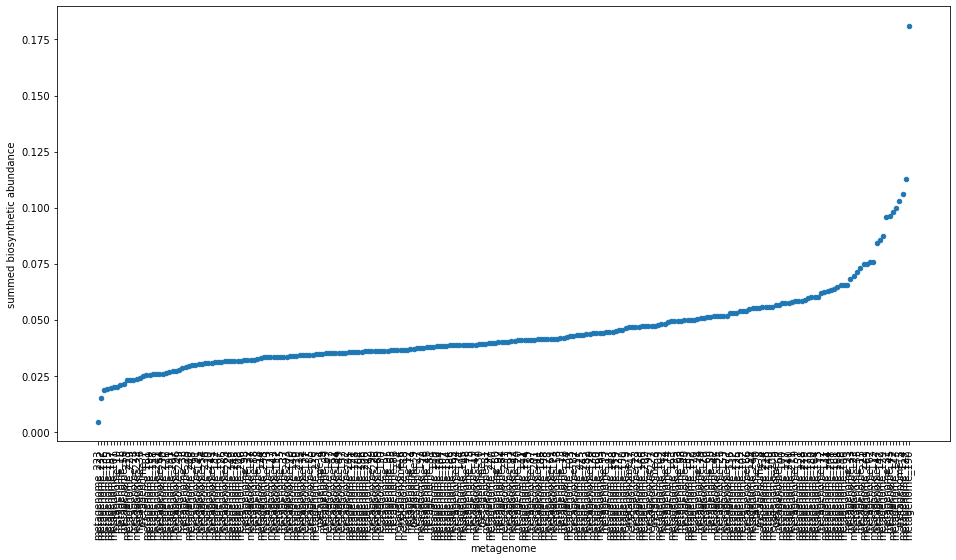

In [10]:
# This is the next cell at which the biosynthetic_capacity table plays a role.
# Make sure that this works with the indiv_hmms_biosynthetic_capacity table as well


capacity_table_path=set_wd+'/AS_out_files'
output_dir=set_wd+'/testing_coverage_tables'

# make an output dir
if os.path.isdir(output_dir):
    print(output_dir,'exists already')
else:
    print('Making', output_dir)
    os.mkdir(output_dir)

# read in biosynthetic_capacity.csv files
# tutorial selection
# biosynthetic_capacity_df = pd.read_csv(capacity_table_path+'/indiv_hmms_biosynthetic_capacity.csv', sep=',')
# all_refseq selection
biosynthetic_capacity_df = pd.read_csv('/media/locblankma@vuw.ac.nz/RP/all_refseq/indiv_hmms_biosynthetic_capacity.csv', sep=',')

# add column with total hmm hits for calculating hmm specific biosynthetic capacities in synthetic metagenomes
biosynthetic_capacity_df['amount_hmm_hits'] = biosynthetic_capacity_df.iloc[:,8:].sum(axis=1)

# specify how many 
# metaBGC: low complexity 42neg + 0-3pos, high complexity 126neg + 0-3pos (range 42 - 129)
genomes_per_mg = 42
amount_metagenomes = 250

# generate list of all available genomes
genome_list = list(biosynthetic_capacity_df['sample'])
# randomly subsample amount of genomes
subsampled_genome_list = random.sample(genome_list,genomes_per_mg)
subsampled_genome_df = biosynthetic_capacity_df[biosynthetic_capacity_df['sample'].isin(subsampled_genome_list)]


# The sampling is the same as in the metaBGC paper, but the input genomes are chosen at random
# Commented out the export to csv statements to keep the metagenomes consistent for the purpose of validation.
counter = 0
biosynthetic_abundance_list = []
while counter < amount_metagenomes:
    abundances = np.random.lognormal(mean=1, sigma=2, size=len(subsampled_genome_df)).tolist()
    subsampled_genome_df['coverage'] = abundances
    # introduced line for amount of reads for shortcut v3 based on https://rdm.elixir-belgium.org/data_volume:
    # read length = 132, multiplied by 2 for paired end. Manual checking of a few samples showed the calculated
    # amount of reads and the amount of reads subsampled to be at ~99.7% with the calculated number slightly higher.
    subsampled_genome_df['calc_reads'] = subsampled_genome_df.apply(lambda row: int(((row.coverage*row.total_genome_length)/132)*2), axis=1)
    subsampled_genome_df['proportion'] = subsampled_genome_df.apply(lambda row: row.coverage/sum(abundances), axis=1)
    subsampled_genome_df['biosynthetic_abundance'] = subsampled_genome_df.apply(lambda row: row.biosynthetic_capacity*row.proportion, axis=1)
    subsampled_genome_df['genome_length_MB'] = subsampled_genome_df.apply(lambda row: row.total_genome_length/1000000, axis=1)
    biosynthetic_abundance_list.append(sum(subsampled_genome_df['biosynthetic_abundance']))
    subsampled_genome_df.dropna(how='all', axis=1, inplace=True)
    subsampled_genome_df.to_csv(output_dir+'/metagenome_'+str(counter)+'.csv', sep=',', index=False)
    counter +=1


# Add columns for hmm resolved capacities
df_dict = {}
for file in os.listdir(output_dir):
    df_dict[file.split('.')[0]] = pd.read_csv(output_dir+'/'+file,sep=',')

# The 2 new columns added are the equivalent of the biosynthetic capacity and the biosynthetic abundance,
# but are specific for each hmm. I.e. summing all 'rel_capacity_hmm' columns leads to the same value
# as in the biosynthetic_capacity column of the same row. Summing all 'rel_abundance_hmm' columns
# leads to the same value as in the biosynthetic_abundance column, i.e. an abundance weighted by coverage
# that is then used to synthetsise the metagenome.

for mg_name, working_df in df_dict.items():
    for hmm_name in working_df.iloc[:,8:-6]:
#         print(hmm_name)
        working_df['rel_capacity_'+hmm_name] = working_df.apply(lambda row: row.biosynthetic_capacity*(row[hmm_name]/row.amount_hmm_hits) if row.amount_hmm_hits > 0 else np.nan, axis=1)
        working_df['rel_abundance_'+hmm_name] = working_df.apply(lambda row: row['rel_capacity_'+hmm_name]*row.proportion, axis=1)
        working_df[hmm_name+'_density'] = working_df.apply(lambda row: row[hmm_name]/row.genome_length_MB, axis=1)
        working_df[hmm_name+'_weighted_density'] = working_df.apply(lambda row: row.coverage*row[hmm_name+'_density'], axis=1)
        # reordering the columns for following parse_coverage script and for being more intuitive in general
        col_list = list(working_df.columns)
        col_list.remove('coverage')
        col_list.remove('proportion')
        col_list.remove('biosynthetic_abundance')
        col_list.remove('amount_hmm_hits')
        col_list.remove('calc_reads')
        col_list.insert(8, 'coverage')
        col_list.insert(9, 'proportion')
        col_list.insert(10, 'biosynthetic_abundance')
        col_list.insert(11, 'amount_hmm_hits')
        col_list.insert(12, 'calc_reads')
        for i in col_list:
            if i.startswith('rel_abundance'):
                col_list.remove(i)
                col_list.insert(-1, i)
        working_df = working_df.reindex(columns=col_list)
    working_df.to_csv(output_dir+'/'+mg_name+'.csv', sep=',', index=False)

print('Done')


# Assessing spread of metagenomic biosynthetic abundance of the generate coverage tables
# Replace the output_dir variable with an absolute path if wanting to keep the previously generated coverage tables.
plot_dict = {}
for file in os.listdir(output_dir):
    mg_name = file.split('.')[0]
    mg_df = pd.read_csv(output_dir+'/'+file, sep=',')
    mg_biosynthetic_abundance = mg_df['biosynthetic_abundance'].sum()
    plot_dict[mg_name]=mg_biosynthetic_abundance
        
plot_df = pd.DataFrame.from_dict(plot_dict, orient='index', columns=['biosynthetic_abundance'])
plot_df.sort_values(by=['biosynthetic_abundance'], inplace=True)
plot_df.reset_index(inplace=True)
plot_df.rename(columns={"index": "metagenome"}, inplace=True)
ax=plot_df.plot(kind='scatter', x='metagenome', y='biosynthetic_abundance', ylabel='summed biosynthetic abundance', figsize=(16, 8))
ax.set_xticks(np.arange(len(plot_df)))
ax.set_xticklabels(plot_df.metagenome, rotation=90)


# Should probably make a plot like this for all individual hmm abundances.

The metagenomes are generated by concatenating the individually subsampled genomes specified in the sample column of the coverage table at the coverage specified in the coverage column of the coverage_table. This produces simluated paired end reads in two individual files in .fq format for each input coverage table. .fq files are converted to .fa files and then translated to peptide sequences in all ORFs at a specified minium length of 32 residues.

The metagenomes are generated and translated on raapoi and due to the large file sizes are not included here. In order to run the cells below, the hmmsearch output generated when searching against the translated metagenomic reads with the antiSMASH hmms is provided in the directory validation_hmmsearch_results.

### Comparing hmmsearch results of defined metagenome to models


Using the coverage tables generated in the cell above, a range of synthetic metagenomes are generated.

For the purpose of this tutorial, the output of hmmsearch against the generated synthetic metagenomes is provided. These files are equivalent to analysis stream 2 hmmsearch output, except that this time, they are not used for model building, but for validation of the models. The goal is to generate a graph that compares the biosynthetic capacity of the metagenomes and compares them against the total amount of hmm hits found in these, respectively. Ideally, there is a linear relationship, i.e. a metagenome with high biosynthetic capacity leads to more hits than a metagenome with low biosynthetic capacity.

#### Required inputs

- model_input_dir: A directory containing precision_dfs as generated above
- input_metagenomes: A directory, containing subdirectories for hmmsearch results against individual metagenomes in both .aln (stockholm), and .tbl formats. For each metagenome, there are currently 2 directories, one each for forward/reverse reads.


#### Generated outputs
- validation_biosynthetic_reads: This directory will contain one subdirectory for each input directory in the input_metagenomes directory. Each of the subdirectories contains the following:
    - all_hmm_hits.tsv: A .tsv file containing all hmmsearch hits found against this metagenome
    - raw/: A directory containing .tsv files of the same structure as all_hmm_hits.tsv, but split by the value in the hmm column, i.e. one file for each uniqe value in the hmm column.
    - below_threshold/: Further split .tsv files as in the raw/ directory, but only where values in the score column are below or equal to the value in the score column of the model for the same region. A column with the model bitscore for the respective region is appended.
    - above_threshold/: Further split .tsv files as in the raw/ directory, but only where values in the score column exceed the value in the score column of the model for the same region. A column with the model bitscore for the respective region is appended. These are for all intents and purposes considered biosynthetic reads.



In [11]:
# %%time
# Wall time: 1min 58s

def identify(read_hmm_dir, model_dir, out_dir):
    # output_dir name is based on input dir name
    output_dir=out_dir+read_hmm_dir.split('/')[-1]
    raw_classified_dir=output_dir+'/raw'
    above_classified_dir=output_dir+'/above_threshold'
    below_classified_dir=output_dir+'/below_threshold'

    # make output dirs
    if os.path.isdir(output_dir):
        print(output_dir,'exists already')
    else:
        print('Making', output_dir)
        os.makedirs(output_dir)

    if os.path.isdir(raw_classified_dir):
        print(raw_classified_dir,'exists already')
    else:
        print('Making', raw_classified_dir)
        os.makedirs(raw_classified_dir)

    if os.path.isdir(above_classified_dir):
        print(above_classified_dir,'exists already')
    else:
        print('Making', above_classified_dir)
        os.makedirs(above_classified_dir)

    if os.path.isdir(below_classified_dir):
        print(below_classified_dir,'exists already')
    else:
        print('Making', below_classified_dir)
        os.makedirs(below_classified_dir)


    # Need to read in and compile a dataframe from both hmm out files, aln and tbl of a metagenome
    # - aln required for position of the alignment of the read against the hmm
    # - tbl required for bitscore result of the respective alignment
    # This is basically the same code as previously used for parsing hmm results out of the genome collection

    search_dict = {}
    for hmm_out_file in os.listdir(read_hmm_dir):

        if re.findall('.aln', hmm_out_file):
#             print('\n'+'Parsing hmms in', hmm_out_file)
            hmm_file_path = read_hmm_dir+'/'+hmm_out_file

            # Read in aln files
            try:
                aln_file = AlignIO.read(hmm_file_path, "stockholm")
                counter = 0
                for record in aln_file:
                    read_id = '/'.join(record.id.split('/')[0:-1])
                    seq = str(record.seq)
                    start = len(seq) - len(seq.lstrip('-'))
                    end = len(seq.rstrip('-')) - 1

                    search_dict[read_id+'---'+hmm_out_file.split('.')[0]] = [hmm_out_file.split('.')[0], start, end] # OG line
                    
                with open(read_hmm_dir+'/'+hmm_out_file.split('.')[0]+'.tbl') as handle:
                    for queryresult in SearchIO.parse(handle, 'hmmer3-tab'):
                        for hit in queryresult.hits:
                            # Sometimes, a hit comes through in the .tbl file, that seems to have a higher e-value
                            # than the one set in the hmmsearch threshold (0.01). These hits are not recorded in
                            # the corresponding .aln file, which causes a KeyError in the dict operation below.
                            # Enclosed it in a try-except loop to handle these cases. Maybe a hmmsearch bug?
                            try:
                                search_dict[hit.id+'---'+hmm_out_file.split('.')[0]].append(hit.evalue)
                                search_dict[hit.id+'---'+hmm_out_file.split('.')[0]].append(hit.bitscore)
                            except KeyError:
                                print('Skipping:', hit.id+'---'+hmm_out_file.split('.')[0]+'.', 'Found in .tbl file but not in .aln file.')

            except ValueError:
                print('No records found in aln file:', hmm_out_file)


    search_df = pd.DataFrame.from_dict(search_dict, orient='index', columns=['hmm', 'start', 'end', 'evalue', 'bitscore'])
    temp_df = search_df.reset_index().rename(columns={"index": "read_id"})
    temp_df['read_id'] = temp_df.apply(lambda row: row.read_id.split('---')[0], axis=1)
    temp_df.sort_values(by=['start'], inplace=True)
    temp_df.to_csv(output_dir+'/'+'all_hmm_hits.tsv', sep='\t', index = None)

    # split temp_df into individual dfs based on value in hmm column
    hmm_list = set(list(temp_df['hmm']))
    for hmm in hmm_list:
        subset_df = temp_df[ (temp_df["hmm"] == hmm)]
        subset_df.to_csv(raw_classified_dir+'/'+hmm+'_hits.tsv', sep='\t', index = None)


    # 3 cases, 2 outputs:
    # - if no model is available for a particular hmm that there are hits in the metagenome for, output the hits in the
    #   metagenome in a separate file, indicating that no models were available, but these are possible hits.
    # - if a model is available, but no reads are found hitting against that hmm, then ignore and continue (Autoind_synth)
    # - if a model is available for a particular hmm and there are hits in the metagenome against the same hmm,
    #   then compare the model with the hmm hits, from there on further cases emerge.


    model_list = []
    for model_file in os.listdir(model_dir):    
        if re.findall('.csv', model_file):
            model_list.append('_'.join(model_file.split('_')[4:])[:-4])
    common_list = list(hmm_list.intersection(set(model_list)))

    no_model_list = []
    for i in hmm_list:
        if i not in model_list:
            no_model_list.append(i)

    no_hit_list = []
    for i in model_list:
        if i not in hmm_list:
            no_hit_list.append(i)


    # case 1: no model available but hits
    # Temporarily commented out for limiting printed output when processing a large amount of metagenomes.
#     for i in no_model_list:
#         print('Hits found against',i,'but no model available.')

    # case 2: model available but no hits
    # No output necessary

    # case 3: hits and model available
    for k in common_list:
        read_df = pd.read_csv(raw_classified_dir+'/'+k+'_hits.tsv', sep='\t')
        model_df = pd.read_csv(model_dir+'/precision_merged_hit_df_'+k+'.csv', sep=',')
        # need to find a way to find instances where the value in the start column in read_df
        # is in the range of the value in the intervale column in the model_df + that value + 10
        model_df_intervals = list(model_df['interval'])
        start_value_dict = {}
        for start_value in read_df['start']:
            for interval_value in model_df_intervals:
                if start_value in range(interval_value, interval_value+10):
                    if start_value not in start_value_dict.keys():
                        start_value_dict[start_value] = model_df[model_df['interval'] == interval_value]['bitscore'].item()



    # For all models compare range of metagenome hmm hits and model range
    # - If there are metagenome hmm hits outside of the range of the model, ignore these
    # - If there are metagenome hits within the range, keep these
    # - If the metagenome hits in the respective range are above the minimum bitscore in the model, label as biosynthetic
    #   otherwise label them as potentially biosynthetic and save separately


        # This generates a dataframe containing only the rows (intervals) for which a model exists
        # Then maps the model bitscore cutoff value to this dict
        interval_subset_df = read_df[read_df['start'].isin(start_value_dict.keys())]
        interval_subset_df['model_bitscore'] = interval_subset_df['start'].map(start_value_dict)

        # Filter this dataframe further for retain only rows where the hit bitscore is above the model biscore
        above_score_df = interval_subset_df[interval_subset_df['bitscore'] > interval_subset_df['model_bitscore']]
        below_score_df = interval_subset_df[interval_subset_df['bitscore'] <= interval_subset_df['model_bitscore']]
        if len(above_score_df) >= 1:
            above_score_df.to_csv(above_classified_dir+'/above_score_'+k+'_hits.tsv', sep='\t', index = None)
        if len(below_score_df) >= 1:
            below_score_df.to_csv(below_classified_dir+'/below_score_'+k+'_hits.tsv', sep='\t', index = None)

# Full refseq models
model_input_dir='/media/locblankma@vuw.ac.nz/RP/all_refseq/merged_99/precision_dfs'
# Tutorial models
# model_input_dir=set_wd+'/merged/precision_dfs_70'

# Full validation metagenome collection
# input_metagenomes=set_wd+'/validation_hmmsearch_results/'
# input_metagenomes='/media/locblankma@vuw.ac.nz/RP/all_refseq/validation_hmmsearch_results/'
# Tutorial validation metagenome collection
input_metagenomes=set_wd+'/test_validation_hmmsearch_results/'

# Full validation metagenome collection
# output_dir=set_wd+'/99_validation_biosynthetic_reads/'
# Tutorial validation metagenome collection
output_dir=set_wd+'/70_test_validation_biosynthetic_reads/'

for metagenome_directory in os.listdir(input_metagenomes):
    print('Processing', metagenome_directory)
    identify(input_metagenomes+metagenome_directory, model_input_dir, output_dir)
    
print('Done')

Processing translated_metagenome_0_1
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_0_1 exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_0_1/raw exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_0_1/above_threshold exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_0_1/below_threshold exists already
No records found in aln file: lasso.aln
No records found in aln file: thiostrepton.aln
No records found in aln file: Bacteriocin_IIi.aln
No records found in aln file: LcnG-beta.aln
No records found in aln file: TIGR03678.aln
No records found in aln file: mcjC.aln
No records found in aln file: TRI5.aln
No records found in aln file: BacteriocIIc_cy.aln
No records found in aln file: PF17914.aln
No r

/tmp/ipykernel_710474/3135561113.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_subset_df['model_bitscore'] = interval_subset_df['start'].map(start_value_dict)


Processing translated_metagenome_0_2
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_0_2 exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_0_2/raw exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_0_2/above_threshold exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_0_2/below_threshold exists already
No records found in aln file: lasso.aln
No records found in aln file: strep_PEQAXS.aln
No records found in aln file: NasY.aln
No records found in aln file: TIGR03601.aln
No records found in aln file: indsynth.aln
No records found in aln file: skfc.aln
No records found in aln file: cypemycin.aln
No records found in aln file: RREFam028.aln
No records found in aln file: PF01947.aln
No records found 

No records found in aln file: cypemycin.aln
No records found in aln file: LE-MER+2PEP.aln
No records found in aln file: PF13165.aln
No records found in aln file: yydH.aln
No records found in aln file: thuricin.aln
No records found in aln file: LE-LAC481.aln
No records found in aln file: LE-LanBC.aln
No records found in aln file: ppys.aln
No records found in aln file: TIGR03975.aln
No records found in aln file: RREFam002.aln
No records found in aln file: DUF3328.aln
No records found in aln file: MA-2PEPB.aln
No records found in aln file: Peptidase_S28.aln
No records found in aln file: PF17914.aln
Processing translated_metagenome_1_2
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_1_2 exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/translated_metagenome_1_2/raw exists already
/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_biosynthetic_reads/t

No records found in aln file: LipM.aln
No records found in aln file: strH_like.aln
No records found in aln file: PF01947.aln
No records found in aln file: lasso.aln
No records found in aln file: RREFam029.aln
No records found in aln file: TIGR04404.aln
No records found in aln file: RREFam020.aln
No records found in aln file: Antimicrobial14.aln
No records found in aln file: RREFam027.aln
No records found in aln file: indsynth.aln
No records found in aln file: MA-LAC481.aln
No records found in aln file: vlmB.aln
No records found in aln file: TIGR04363.aln
No records found in aln file: pgm1.aln
No records found in aln file: trichodiene_synth.aln
No records found in aln file: glycocin.aln
No records found in aln file: MA-NIS.aln
No records found in aln file: TIGR03973.aln
No records found in aln file: TIGR03798.aln
No records found in aln file: RREFam003.aln
No records found in aln file: pur6.aln
No records found in aln file: nikJ.aln
No records found in aln file: RREFam026.aln
No records

No records found in aln file: RREFam015.aln
No records found in aln file: PF05655.aln
No records found in aln file: RREFam012.aln
No records found in aln file: MA-NIS.aln
No records found in aln file: LmbU.aln
No records found in aln file: strH_like.aln
No records found in aln file: mvd_mst.aln
No records found in aln file: TIGR04404.aln
No records found in aln file: LipU.aln
No records found in aln file: RREFam029.aln
No records found in aln file: mvnA.aln
No records found in aln file: strepbact.aln
No records found in aln file: RREFam027.aln
No records found in aln file: PoyD.aln
No records found in aln file: RREFam020.aln
No records found in aln file: Peptidase_S28.aln
No records found in aln file: TIGR03678.aln
No records found in aln file: LcnG-beta.aln
No records found in aln file: LipM.aln
No records found in aln file: LE-MER+2PEP.aln
No records found in aln file: Antimicrobial18.aln
No records found in aln file: Terpene_synth_C.aln
No records found in aln file: RREFam023.aln
No

No records found in aln file: Peptidase_S28.aln
No records found in aln file: vlmB.aln
No records found in aln file: indsynth.aln
No records found in aln file: RREFam022.aln
No records found in aln file: spcFG_like.aln
No records found in aln file: Antimicrobial17.aln
No records found in aln file: RREFam025.aln
No records found in aln file: LipM.aln
No records found in aln file: RREFam010.aln
No records found in aln file: RREFam017.aln
No records found in aln file: Lactococcin.aln
No records found in aln file: PF01947.aln
No records found in aln file: MA-DUF.aln
No records found in aln file: MA-EPI.aln
No records found in aln file: Terpene_synth.aln
No records found in aln file: BacteriocIIc_cy.aln
No records found in aln file: mcjC.aln
No records found in aln file: TRI5.aln
No records found in aln file: RREFam007.aln
No records found in aln file: RREFam009.aln
No records found in aln file: Gallidermin.aln
No records found in aln file: Cloacin.aln
No records found in aln file: neoL_lik

### Quantitative comparison between input metagenomes and total hmmsearch_hits


The comparison in the cell below is based on the previously generated coverage tables, specifically the information about the biosynthetic abundance in the coverage table. Even though the source genomes for all generated metagenomes are identical, they are sampled at different coverages, so the higher a coverage a individual genome is sampled at, the higher should be the proportion of reads sampled from the BGCs contained in this genome, and as a result, more hmmsearch hits should be found. This value is encoded by the biosynthetic_abundance. The sum of all values in the biosynthetic_abundance column extends this concept to the entire metagenome. A higher summed biosynthetic_abundance should overall lead to more above threshold hmmsearch hits against this metagenome.

The output of this cell is a plot that illustrates this relationship. The biosynthetic abundance is plotted along the x-axis, and the amount of above threshold hmmsearch hits of the same metagenome are plotted along the y-axis.

Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/plots
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_0
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_1
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_2
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_3
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_4
building biosynthetic capacity dict for: micKC n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: terpene_cyclase n= 5
building biosynthetic capacity dict for: t2ks n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: phytoene_synt n= 5
building biosynthetic capacity dict for: phosphonates n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: PKS_AT n= 5
building biosynthetic capacity dict for: AMP-binding n= 5
building biosynthetic capacity dict for: ene_KS n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: TIGR03966 n= 5
building biosynthetic capacity dict for: LANC_like n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/tmp/ipykernel_695721/1370602401.py:170: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


building biosynthetic capacity dict for: DUF692 n= 5
building biosynthetic capacity dict for: YcaO n= 5
building biosynthetic capacity dict for: hglD n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: NAD_binding_4 n= 5
building biosynthetic capacity dict for: Chal_sti_synt_C n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: MGT n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: APE_KS2 n= 5
building biosynthetic capacity dict for: hglE n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: Condensation n= 5
building biosynthetic capacity dict for: ectoine_synt n= 5
building biosynthetic capacity dict for: hyb_KS n= 5
TIGR03882 only found once, no plot generated
building biosynthetic capacity dict for: TIGR02111 n= 5
building biosynthetic capacity dict for: AfsA n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: Linocin_M18 n= 5
building biosynthetic capacity dict for: TIGR02278 n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: PKS_KS n= 5
building biosynthetic capacity dict for: IucA_IucC n= 5
building biosynthetic capacity dict for: TIGR02353 n= 5
building biosynthetic capacity dict for: mod_KS n= 5
building biosynthetic capacity dict for: t2clf n= 5


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: APE_KS1 n= 5
building biosynthetic capacity dict for: DarB n= 2


/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Done


<Figure size 432x288 with 0 Axes>

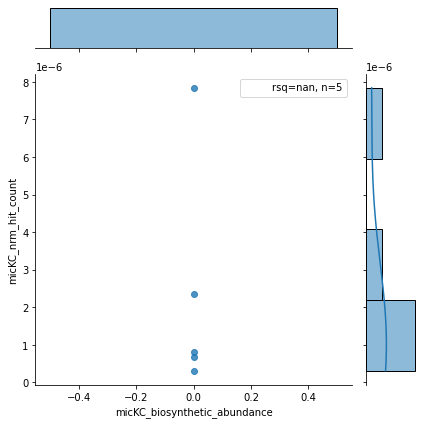

<Figure size 432x288 with 0 Axes>

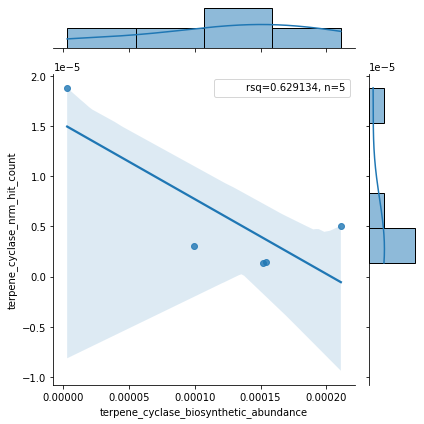

<Figure size 432x288 with 0 Axes>

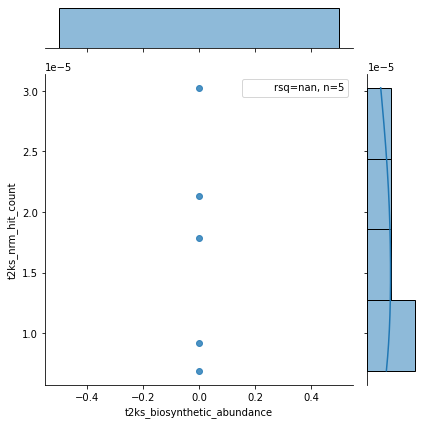

<Figure size 432x288 with 0 Axes>

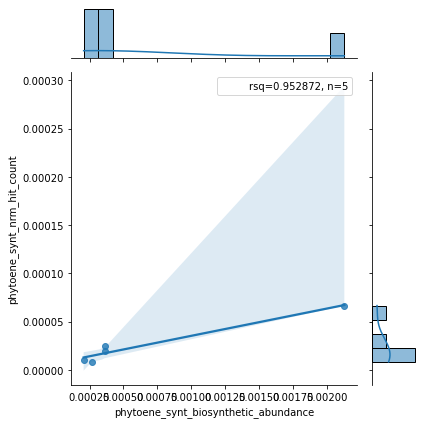

<Figure size 432x288 with 0 Axes>

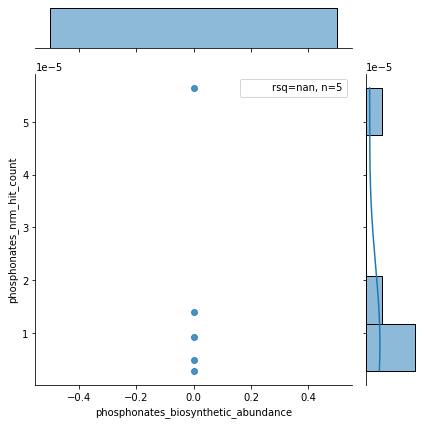

<Figure size 432x288 with 0 Axes>

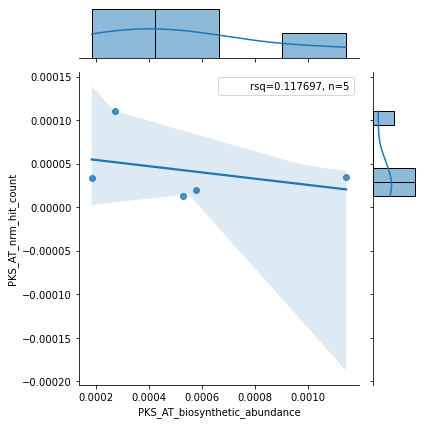

<Figure size 432x288 with 0 Axes>

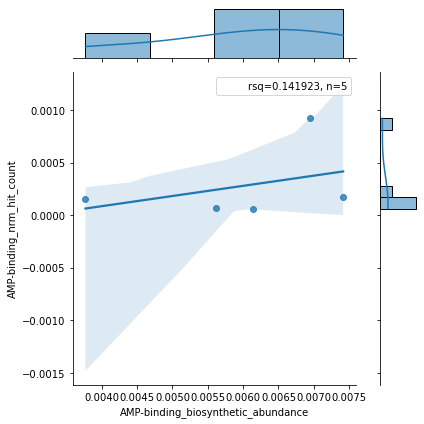

<Figure size 432x288 with 0 Axes>

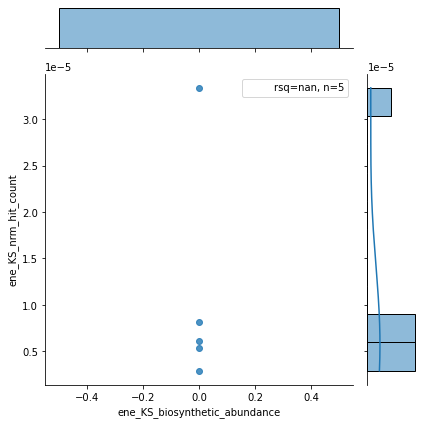

<Figure size 432x288 with 0 Axes>

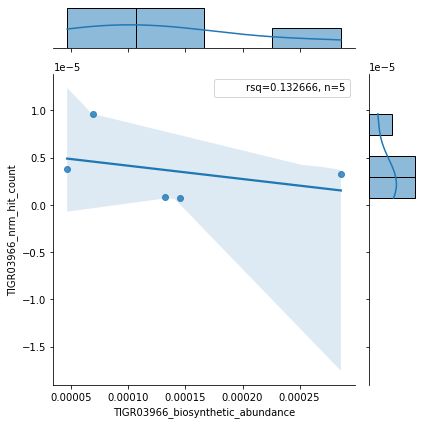

<Figure size 432x288 with 0 Axes>

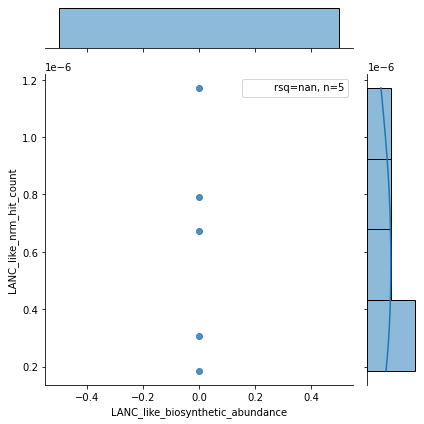

<Figure size 432x288 with 0 Axes>

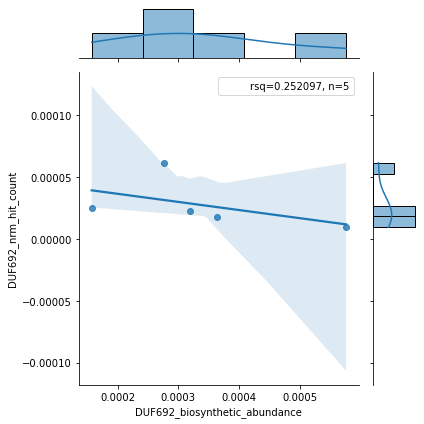

<Figure size 432x288 with 0 Axes>

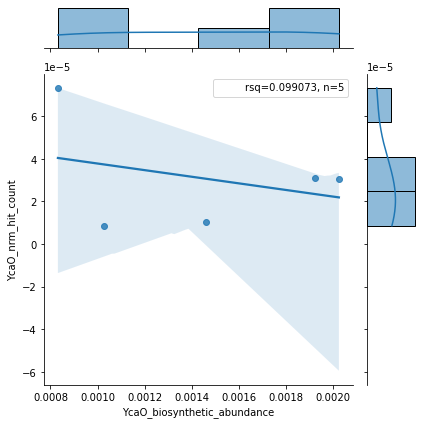

<Figure size 432x288 with 0 Axes>

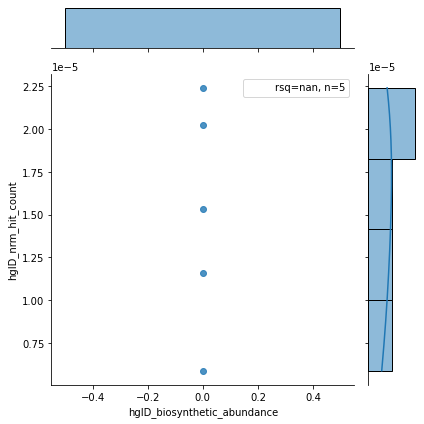

<Figure size 432x288 with 0 Axes>

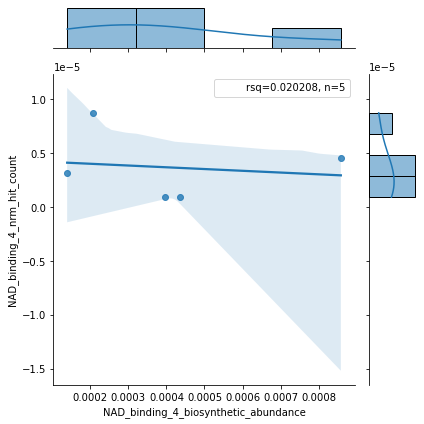

<Figure size 432x288 with 0 Axes>

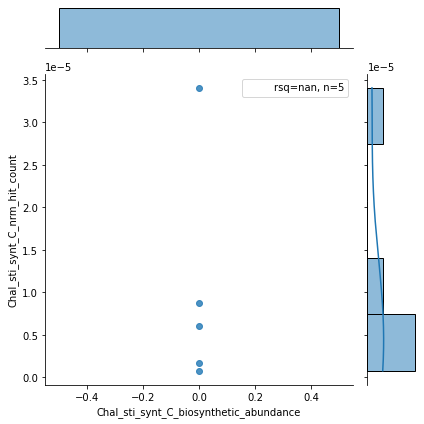

<Figure size 432x288 with 0 Axes>

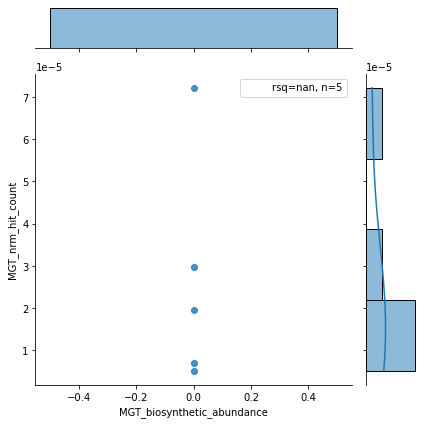

<Figure size 432x288 with 0 Axes>

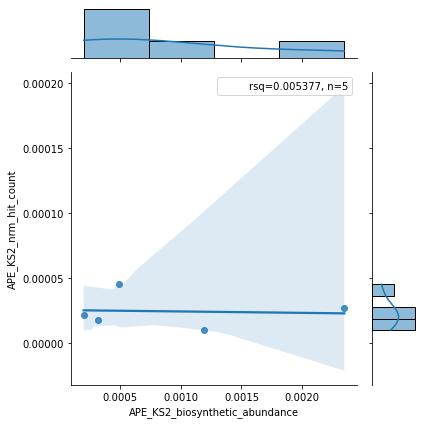

<Figure size 432x288 with 0 Axes>

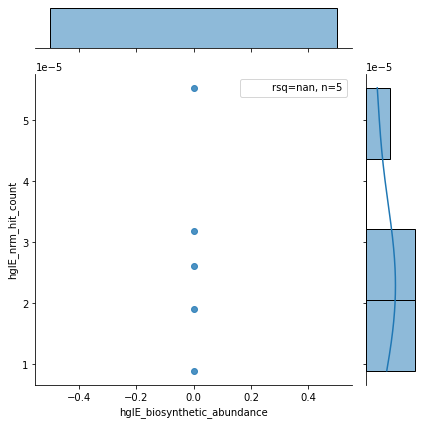

<Figure size 432x288 with 0 Axes>

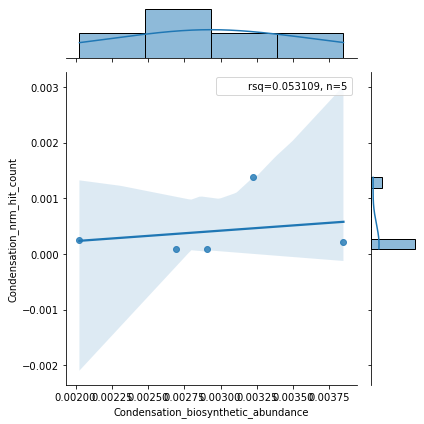

<Figure size 432x288 with 0 Axes>

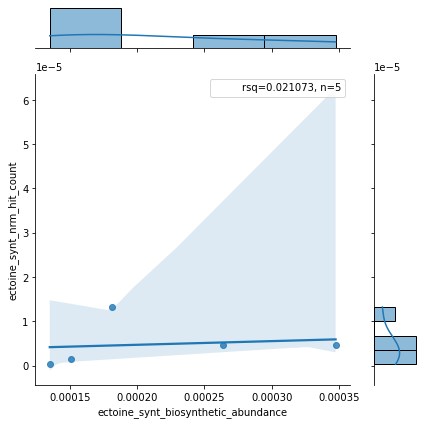

<Figure size 432x288 with 0 Axes>

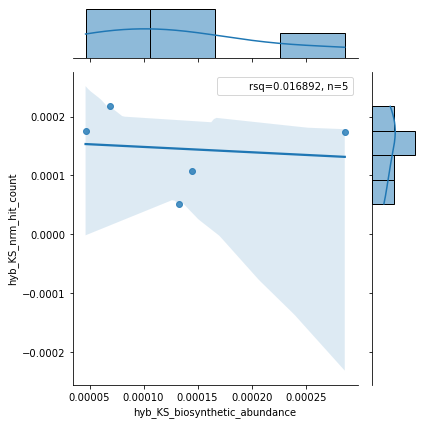

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

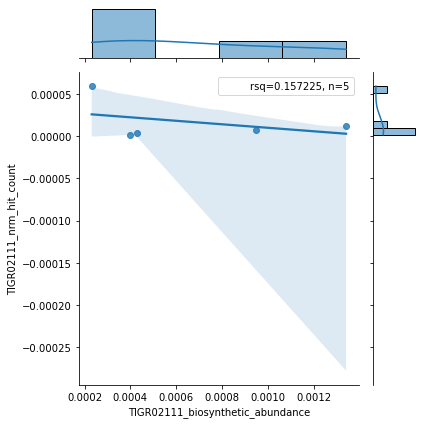

<Figure size 432x288 with 0 Axes>

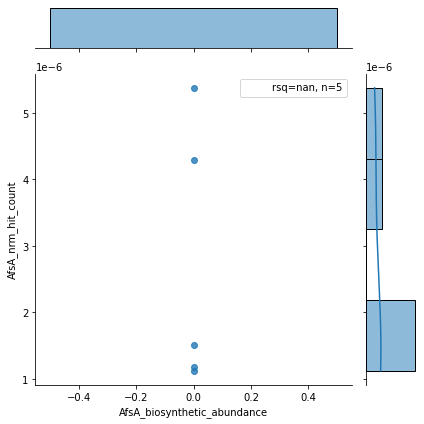

<Figure size 432x288 with 0 Axes>

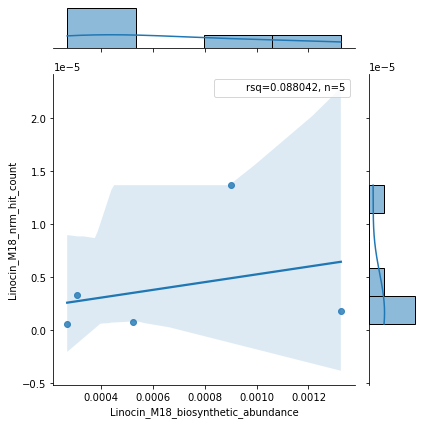

<Figure size 432x288 with 0 Axes>

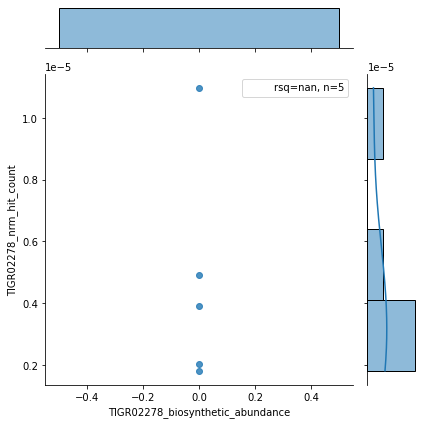

<Figure size 432x288 with 0 Axes>

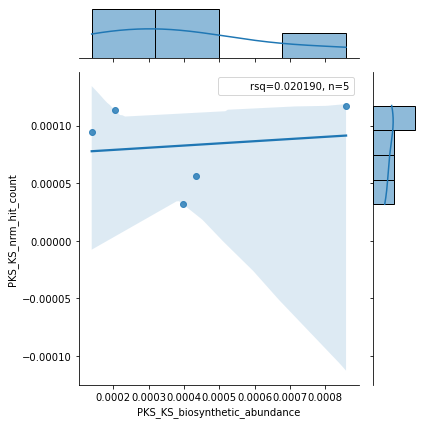

<Figure size 432x288 with 0 Axes>

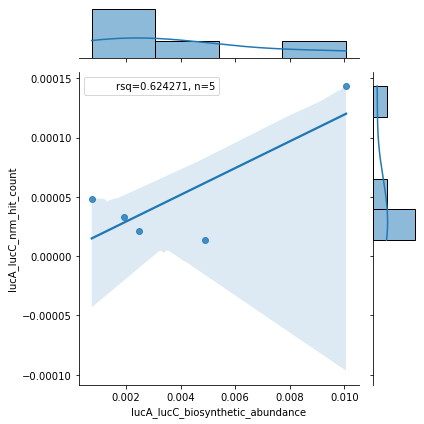

<Figure size 432x288 with 0 Axes>

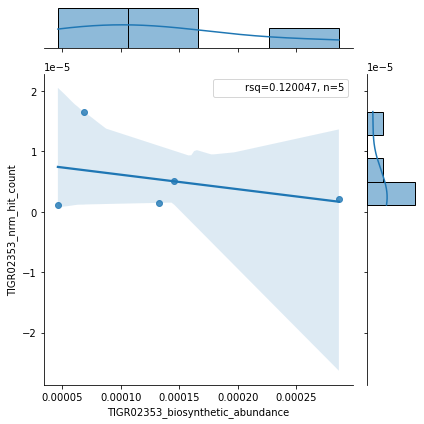

<Figure size 432x288 with 0 Axes>

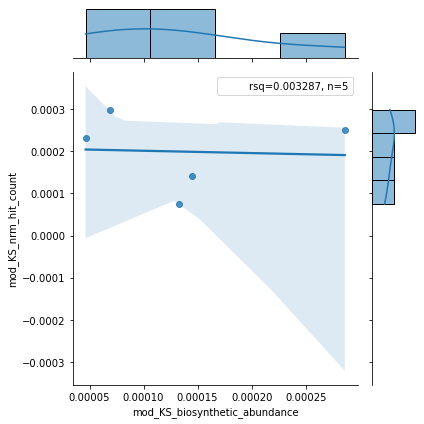

<Figure size 432x288 with 0 Axes>

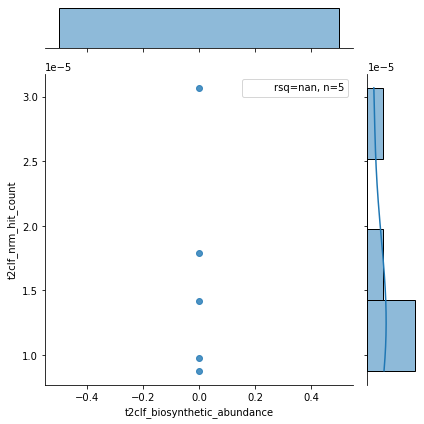

<Figure size 432x288 with 0 Axes>

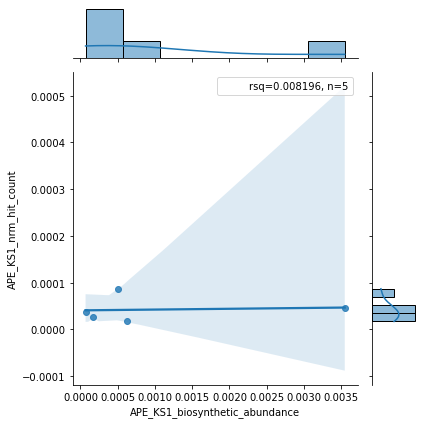

<Figure size 432x288 with 0 Axes>

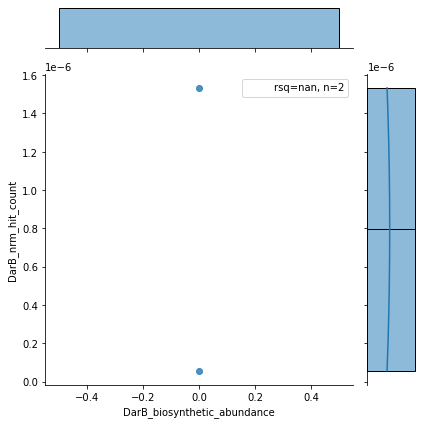

<Figure size 432x288 with 0 Axes>

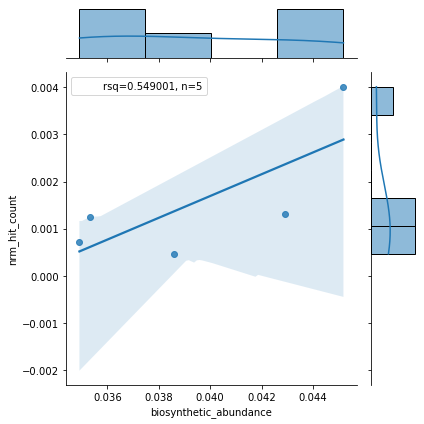

In [58]:
# # Plot amount of above threshold reads against sum of biosynthetic abundance column in coverage tables

# coverage_table_dir=set_wd+'/testing_coverage_tables'
# # coverage_table_dir='/media/locblankma@vuw.ac.nz/RP/validation_refseq/250_coverage_tables'
# # Full validation metagenome collection
# # biosynthetic_reads_dir=set_wd+'/99_validation_biosynthetic_reads'
# # Tutorial validation metagenome collection
# biosynthetic_reads_dir=set_wd+'/70_test_validation_biosynthetic_reads'
# # Full validation metagenome collection
# # output_dir=set_wd+'/99_validation_joined_hits_nrm'
# # Tutorial validation metagenome collection
# output_dir=set_wd+'/70_test_validation_joined_hits'

# # make an output dir
# if os.path.isdir(output_dir):
#     print(output_dir,'exists already')
# else:
#     print('Making', output_dir)
#     os.mkdir(output_dir)

# # make an plots dir
# if os.path.isdir(output_dir+'/plots'):
#     print(output_dir+'/plots','exists already')
# else:
#     print('Making', output_dir+'/plots')
#     os.mkdir(output_dir+'/plots')


                
# # Read in read_count_df, manually, to normalise the hit_count by the amount of reads in the metagenome
# read_count_df = pd.read_csv('/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/total_reads.csv', sep=',')
# # Ideally, this df should be generated when synthesising the metagenomes. Here, it is from slurm logs


# # A snippet that generates a dictionary with the calculated read counts. It's currently not used downstream
# # read_count_dict = {}
# # for file in os.listdir(coverage_table_dir):
# #     if re.findall('^metagenome', file):
# #         mg_name = file.split('.')[0]
# #         mg_df = pd.read_csv(coverage_table_dir+'/'+mg_name+'.csv')
# #         read_count_dict[mg_name] = mg_df.loc[:,'calc_reads'].sum()

    
# # join all above threshold hits in one df per metagenome
# hit_dict = {} # key is: translated_metagenome_0_1
# for outdir in os.listdir(biosynthetic_reads_dir):
#     hit_list = []
#     if re.findall('^translated_metagenome_', outdir):
#         for file in os.listdir(biosynthetic_reads_dir+'/'+outdir+'/above_threshold/'):
#             test_df = pd.read_csv(biosynthetic_reads_dir+'/'+outdir+'/above_threshold/'+file, sep='\t')
#             hit_list.append(test_df)
#         hit_dict[outdir] = hit_list


# # export that concatenated per-metagenome df to a tsv file
# for k,v in hit_dict.items():
#     joined_df = pd.concat(v)
#     joined_df.to_csv(output_dir+'/'+k+'.tsv', sep='\t', index=False)


# # Concatename 1 and 2 files from the same metagenome
# mg_list = []
# for file in os.listdir(output_dir):
#     if re.findall('^translated_metagenome_', file):
#         metagenome_basename = '_'.join(file.split('_')[0:3])
#         if metagenome_basename not in mg_list:
#             mg_list.append(metagenome_basename)


# # Export to tsv file as well
# # Split file by values in hmm column for hmm resolved plots
# # This is a bit of a retrofit to the initially not hmm_resolved version, so hits from fwd/rev read hits are 
# # initially concatenated, but then split again and the subset dfs saved in new dirs, respectively.
# hmm_resolved_plot_dict = {} # key is: translated_metagenome_4

# for i in mg_list:
#     if os.path.isdir(output_dir+'/hmm_resolved_'+i):
#         continue
#     else:
#         print('Making', output_dir+'/hmm_resolved_'+i)
#         os.mkdir(output_dir+'/hmm_resolved_'+i)
#     df_1 = pd.read_csv(output_dir+'/'+i+'_1.tsv', sep='\t')
#     df_2 = pd.read_csv(output_dir+'/'+i+'_2.tsv', sep='\t')
#     concat_mg_df = pd.concat([df_1, df_2])
#     concat_mg_df.to_csv(output_dir+'/concat_'+i+'.tsv', sep='\t', index=False)
#     mg_hmm_list = concat_mg_df.loc[:,'hmm'].unique()
#     # need to get all unique values from hmm column
#     for hmm_name in mg_hmm_list:
#         subset_df = concat_mg_df[ (concat_mg_df["hmm"] == hmm_name)]
#         subset_df.to_csv(output_dir+'/hmm_resolved_'+i+'/concat_'+i+'_'+hmm_name+'.tsv', sep='\t', index=False)
#     hmm_resolved_plot_dict[i] = mg_hmm_list


# # This works for the not hmm_resolved version. Keep this as I still want it.
# plot_dict = {} # key is: concat_translated_metagenome_0
# for file in os.listdir(output_dir):
#     if re.findall('^concat', file):
#         mg_name = '_'.join(file.split('.')[0].split('_')[0:4])
#         mg_df = pd.read_csv(output_dir+'/'+file)
#         plot_dict[mg_name]=len(mg_df)


# # print(plot_dict) # {'concat_translated_metagenome_163': 68233, ...}
# # Need to generate a plot_dict that is as the one above, matching hit_count to biosynthetic_abundance,
# # but additionally matches hit_count of each individual hmm to the respectively matching biosynthetic_abundance
# # Don't need to concatenate files for this. can use the individual above threshold hmm count outputs

# # biosynthetic_abundance
# for file in os.listdir(coverage_table_dir):
#     mg_name = 'concat_translated_'+file.split('.')[0]
#     mg_df = pd.read_csv(coverage_table_dir+'/'+file, sep=',')
#     if mg_name in plot_dict.keys():
#         mg_biosynthetic_abundance = mg_df['biosynthetic_abundance'].sum()
#         plot_dict[mg_name]=[plot_dict[mg_name], mg_biosynthetic_abundance]

        
# # Need to match that to the hmm_resolved version as well
# sortdict = {}
# hmm_list = []
# for file in os.listdir(coverage_table_dir):
#     mg_name = 'translated_'+file.split('.')[0]
#     mg_df = pd.read_csv(coverage_table_dir+'/'+file, sep=',')
#     if mg_name in hmm_resolved_plot_dict.keys():
#         for hmm in hmm_resolved_plot_dict[mg_name]:
#             if not hmm in hmm_list:
#                 hmm_list.append(hmm)
#             hmm_hit_len = pd.read_csv(output_dir+'/hmm_resolved_'+mg_name+'/concat_'+mg_name+'_'+hmm+'.tsv', sep='\t')
            
#             # Accounting for cases where hmm hits are found against reads, but none were in the input metagenomes
#             try:
#                 sortdict[mg_name+'_'+hmm] = [len(hmm_hit_len), mg_df.loc[:,'rel_abundance_'+hmm].sum()]
#             except KeyError:
#                 sortdict[mg_name+'_'+hmm] = [len(hmm_hit_len), 0]


# # generating individual dictionaries resolved by hmm, containing values for all metagenomes pertaining
# # to that hmm, then plotting them and outputting that plot
# rsq_dict = {}
# for hmm in hmm_list:
#     indiv_plot_dict = {}
#     for k, v in sortdict.items():
#         if hmm in k:
#             indiv_plot_dict[k] = v


#     indiv_corr_df = pd.DataFrame.from_dict(indiv_plot_dict, orient='index', columns=[hmm+'_hit_count', hmm+'_biosynthetic_abundance'])
#     indiv_corr_df.sort_values(by=[hmm+'_biosynthetic_abundance'], inplace=True)


#     # rename columns to merge indiv_corr_df with read_count_df
#     indiv_corr_df = indiv_corr_df.reset_index().rename(columns={"index": "sample_hmm"})
#     indiv_corr_df['sample'] = indiv_corr_df.apply(lambda row: '_'.join(row.sample_hmm.split('_')[0:3]), axis=1)
#     indiv_corr_df['hmm'] = indiv_corr_df.apply(lambda row: row.sample_hmm.split('_')[3], axis=1)

    
#     merged_df = pd.merge(indiv_corr_df,
#              read_count_df,
#              on='sample',
#              how='inner',
#              left_index=False,
#              right_index=False)

#     # normalise biosynthetic_abundance by read_count in the metagenomes
#     merged_df.rename(columns={hmm+'_hit_count': 'hit_count'}, inplace=True)
#     merged_df[hmm+'_nrm_hit_count'] = merged_df.apply(lambda row: row.hit_count/row.reads, axis=1)
#     indiv_corr_df = merged_df.iloc[:,[0,2,6]]
#     indiv_corr_df.set_index('sample_hmm', inplace=True)
# #     indiv_corr_df.to_csv(output_dir+'/'+hmm+'_indiv_corr_df.tsv', sep='\t', index=None)
    
#     plt.figure()
#     if len(indiv_corr_df[hmm+'_nrm_hit_count']) >=2:
#         print('building biosynthetic capacity dict for:', hmm, 'n=', len(indiv_corr_df[hmm+'_nrm_hit_count']))
#         r, p = stats.pearsonr(x=indiv_corr_df[hmm+'_biosynthetic_abundance'], y=indiv_corr_df[hmm+'_nrm_hit_count'])
#         graph = sns.jointplot(x=indiv_corr_df[hmm+'_biosynthetic_abundance'], y=indiv_corr_df[hmm+'_nrm_hit_count'], kind='reg')
#         phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
#         graph.ax_joint.legend([phantom],['rsq={:f}, n={:s}'.format(r**2, str(len(indiv_corr_df[hmm+'_nrm_hit_count'])))])
#         plt.tight_layout()
#         plt.savefig(output_dir+'/plots/'+hmm+'.png')
#         rsq_dict[hmm] = [len(indiv_corr_df[hmm+'_nrm_hit_count']), r**2]
#     else:
#         print(hmm, 'only found once, no plot generated')


# corr_df = pd.DataFrame.from_dict(plot_dict, orient='index', columns=['hit_count', 'biosynthetic_abundance'])
# corr_df.sort_values(by=['biosynthetic_abundance'], inplace=True)


# corr_df = corr_df.reset_index().rename(columns={"index": "sample_name"})
# corr_df['sample'] = corr_df.apply(lambda row: '_'.join(row.sample_name.split('_')[1:4]), axis=1)

# merged_df = pd.merge(corr_df,
#          read_count_df,
#          on='sample',
#          how='inner',
#          left_index=False,
#          right_index=False)

# # normalise biosynthetic_abundance by read_count in the metagenomes
# merged_df['nrm_hit_count'] = merged_df.apply(lambda row: row.hit_count/row.reads, axis=1)

# # merged_df.to_csv(output_dir+'/merged_df.tsv', sep='\t', index=None)

# corr_df = merged_df.iloc[:,[0,2,5]]
# corr_df.set_index('sample_name', inplace=True)



# plt.figure()
# r, p = stats.pearsonr(x=corr_df['biosynthetic_abundance'], y=corr_df['nrm_hit_count'])
# total_graph = sns.jointplot(x=corr_df['biosynthetic_abundance'], y=corr_df['nrm_hit_count'], kind='reg')
# phantom, = total_graph.ax_joint.plot([], [], linestyle="", alpha=0)
# # total_graph.ax_joint.legend([phantom],['rsq={:f}'.format(r**2)])
# total_graph.ax_joint.legend([phantom],['rsq={:f}, n={:s}'.format(r**2, str(len(corr_df)))])
# plt.tight_layout()
# plt.savefig(output_dir+'/plots/'+'total_comparison'+'.png')

# # Export df with rsq values of all hmms
# rsq_df = pd.DataFrame.from_dict(rsq_dict, orient='index', columns=['n','rsq'])
# rsq_df = rsq_df.reset_index().rename(columns={"index": "hmm"})
# rsq_df.sort_values(by=['rsq'], inplace=True, ascending=False)
# rsq_df.to_csv(output_dir+'/rsq_df.tsv', sep='\t', index=None)

# print('Done')


In [ ]:
# Same as cell above but to tinker

Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/plots
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_0
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_1
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_2
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_3
Making /media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/70_test_validation_joined_hits/hmm_resolved_translated_metagenome_4


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: micKC n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: terpene_cyclase n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: t2ks n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: phytoene_synt n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: phosphonates n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: PKS_AT n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: AMP-binding n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: ene_KS n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: TIGR03966 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: LANC_like n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/tmp/ipykernel_710474/4277844791.py:189: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


building biosynthetic capacity dict for: DUF692 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: YcaO n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: hglD n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: NAD_binding_4 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: Chal_sti_synt_C n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: MGT n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: APE_KS2 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: hglE n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: Condensation n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: ectoine_synt n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: hyb_KS n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


TIGR03882 only found once, no plot generated
building biosynthetic capacity dict for: TIGR02111 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: AfsA n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: Linocin_M18 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: TIGR02278 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: PKS_KS n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: IucA_IucC n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: TIGR02353 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: mod_KS n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: t2clf n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: APE_KS1 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: indole_PTase n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: A-OX n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: prnB n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: DarB n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: LipV n= 2


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: TIGR03603 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: goadsporin_like n= 4


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: frbD n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: TIGR03103 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: TIGR03104 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: mmyO n= 4


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: TIGR03651 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: CaiA n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: ATd n= 4


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: subtilosin n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: ladderane n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: melC n= 4


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: tra_KS n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: Lactococcin_972 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: bacilysin n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: TunD n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: TIGR03106 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: Autoind_synth n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: TIGR03693 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: cycdipepsynth n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: TIGR01193 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: NapT7 n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: Lycopene_cycl n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: novH n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: tabtoxin n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: phzB n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: novJ n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: PUFA_KS n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: bcpB n= 4


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: Chal_sti_synt_N n= 3


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
/home/locblankma/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


building biosynthetic capacity dict for: BLS n= 5


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


building biosynthetic capacity dict for: TIGR03604 n= 3
nikO only found once, no plot generated
Done


/tmp/ipykernel_710474/4277844791.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)


<Figure size 432x288 with 0 Axes>

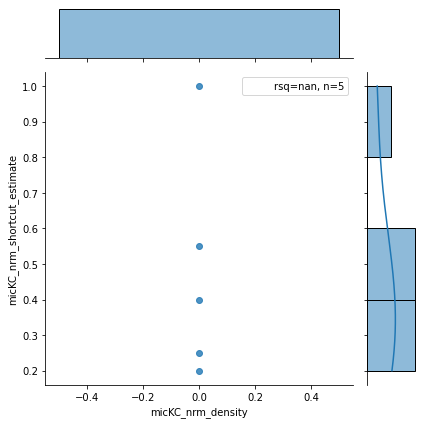

<Figure size 432x288 with 0 Axes>

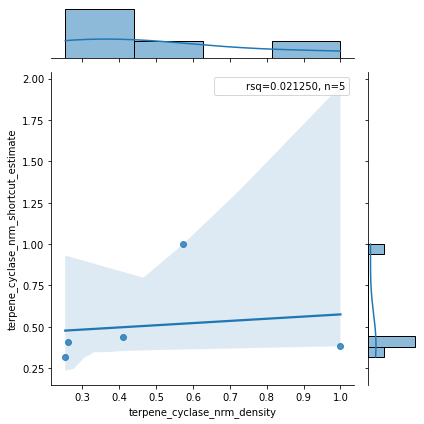

<Figure size 432x288 with 0 Axes>

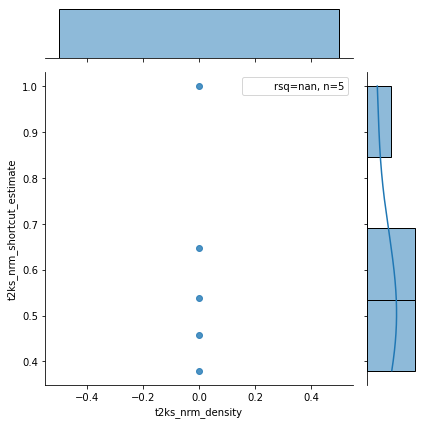

<Figure size 432x288 with 0 Axes>

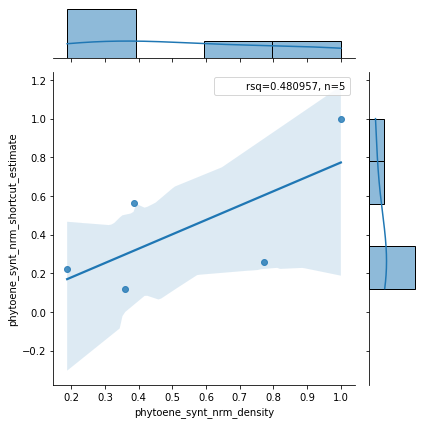

<Figure size 432x288 with 0 Axes>

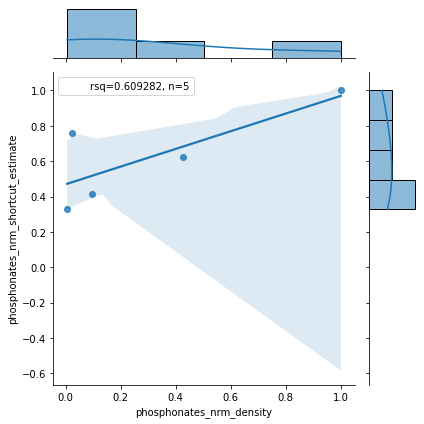

<Figure size 432x288 with 0 Axes>

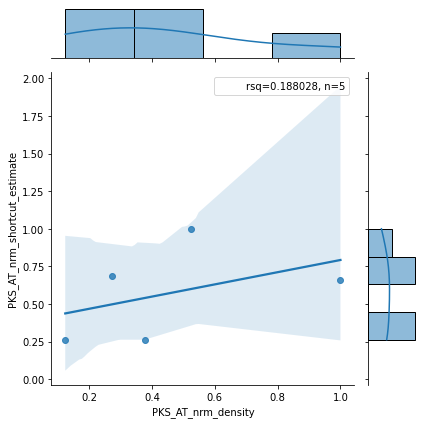

<Figure size 432x288 with 0 Axes>

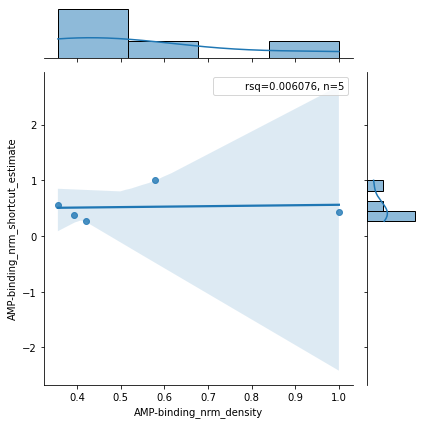

<Figure size 432x288 with 0 Axes>

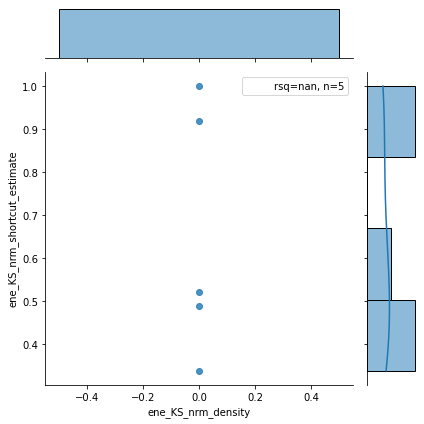

<Figure size 432x288 with 0 Axes>

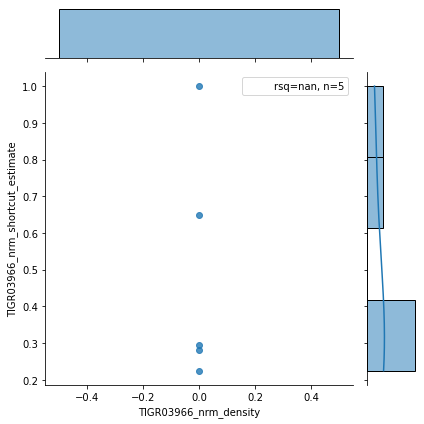

<Figure size 432x288 with 0 Axes>

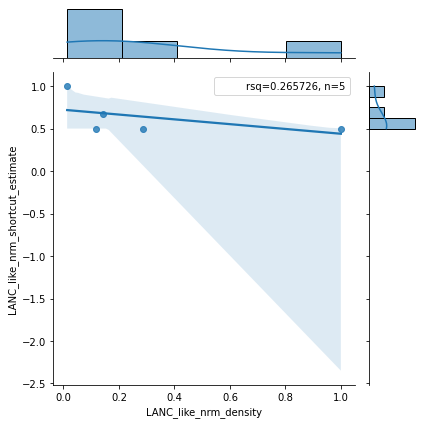

<Figure size 432x288 with 0 Axes>

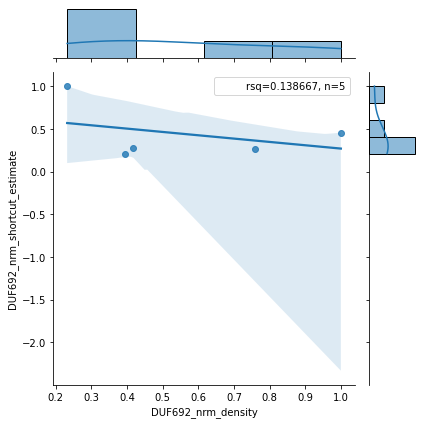

<Figure size 432x288 with 0 Axes>

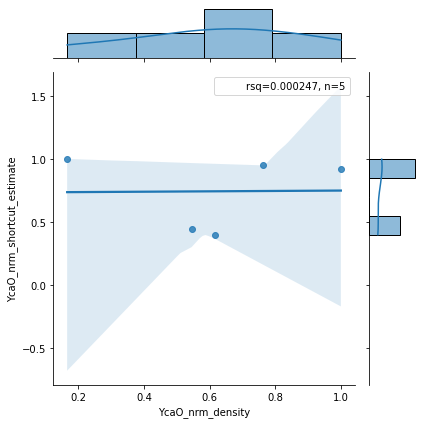

<Figure size 432x288 with 0 Axes>

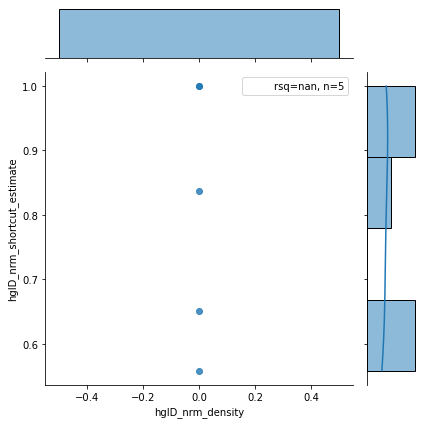

<Figure size 432x288 with 0 Axes>

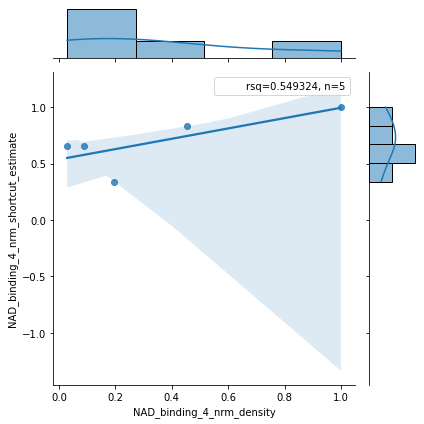

<Figure size 432x288 with 0 Axes>

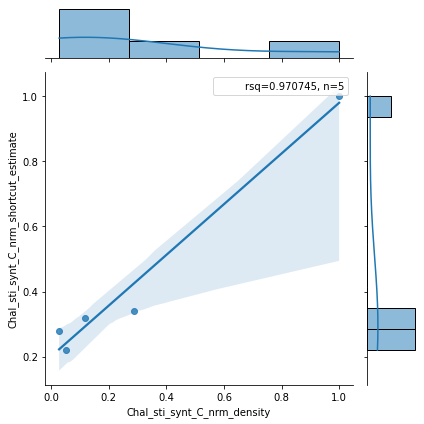

<Figure size 432x288 with 0 Axes>

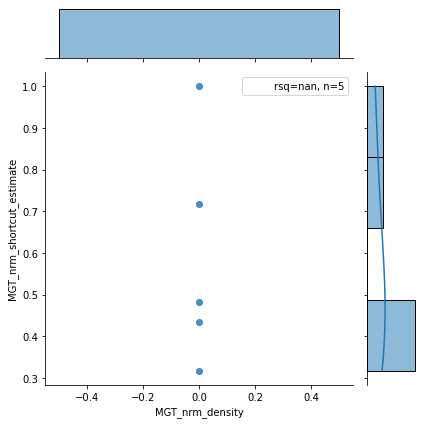

<Figure size 432x288 with 0 Axes>

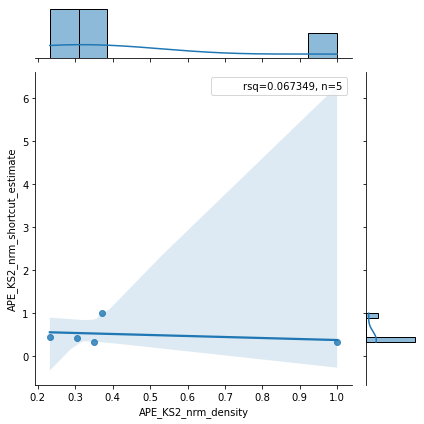

<Figure size 432x288 with 0 Axes>

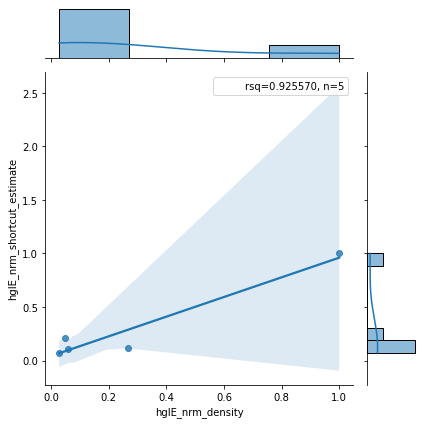

<Figure size 432x288 with 0 Axes>

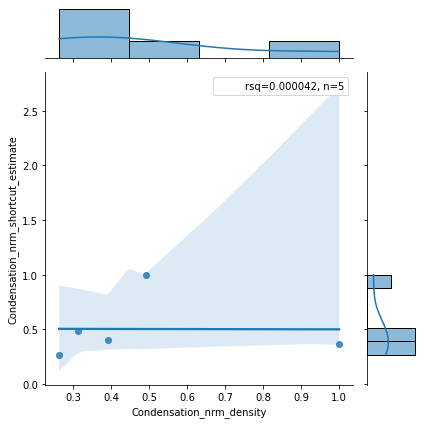

<Figure size 432x288 with 0 Axes>

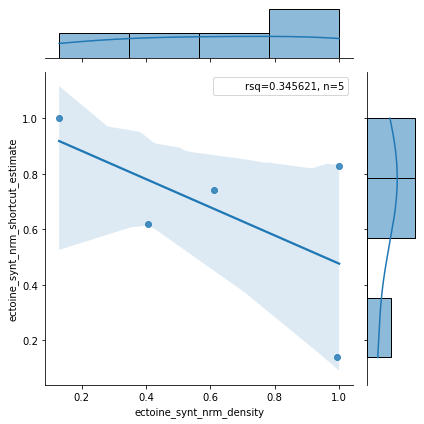

<Figure size 432x288 with 0 Axes>

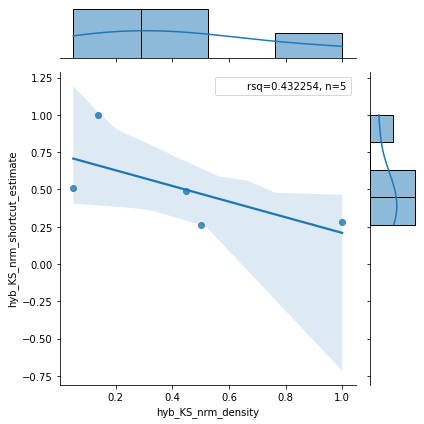

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

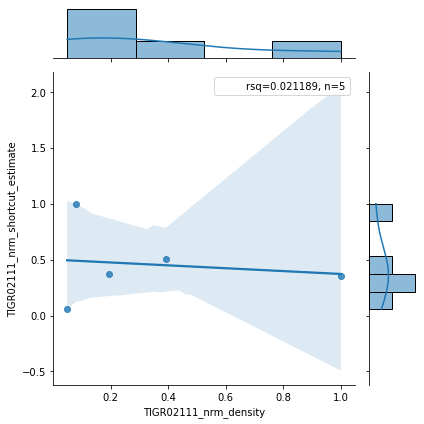

<Figure size 432x288 with 0 Axes>

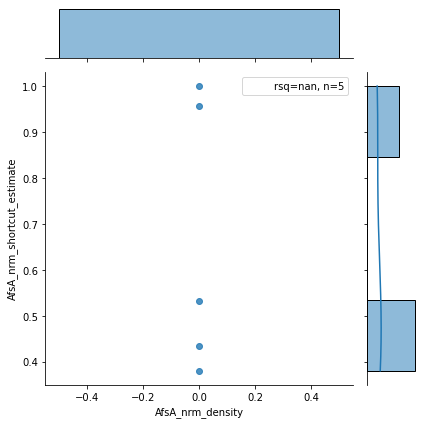

<Figure size 432x288 with 0 Axes>

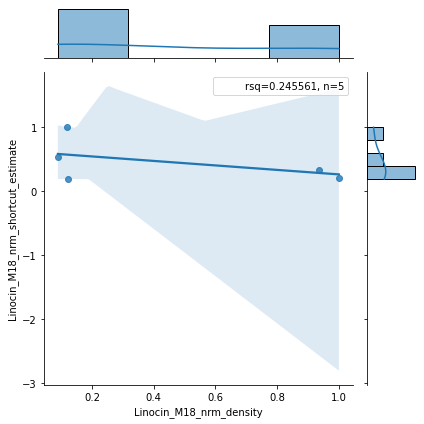

<Figure size 432x288 with 0 Axes>

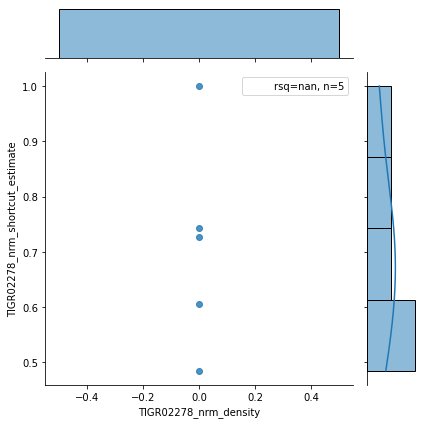

<Figure size 432x288 with 0 Axes>

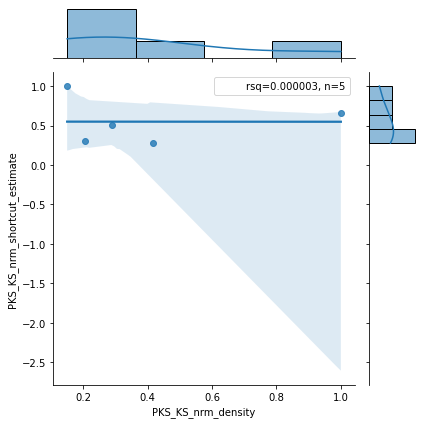

<Figure size 432x288 with 0 Axes>

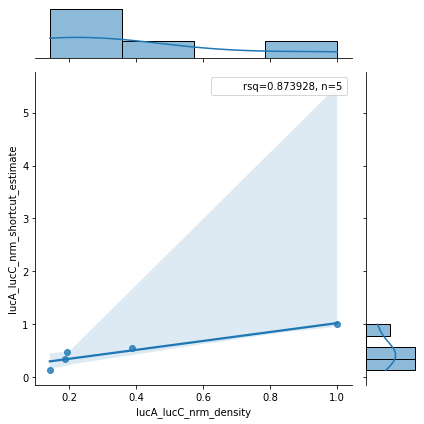

<Figure size 432x288 with 0 Axes>

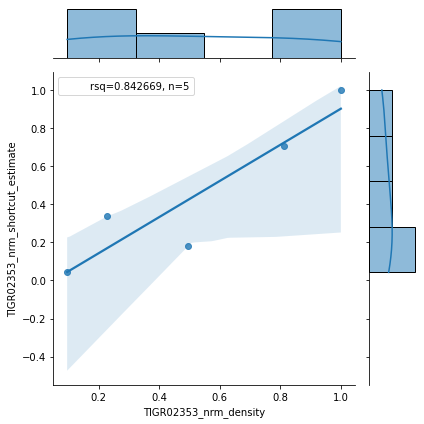

<Figure size 432x288 with 0 Axes>

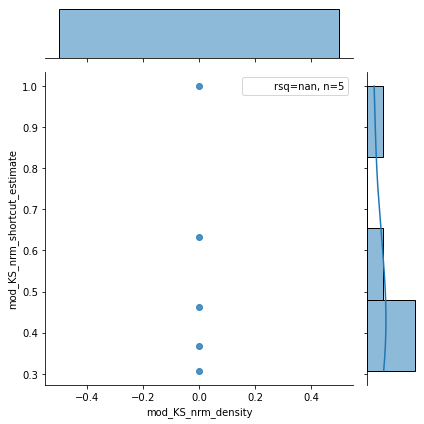

<Figure size 432x288 with 0 Axes>

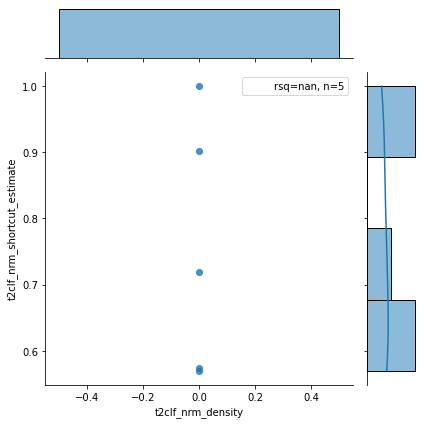

<Figure size 432x288 with 0 Axes>

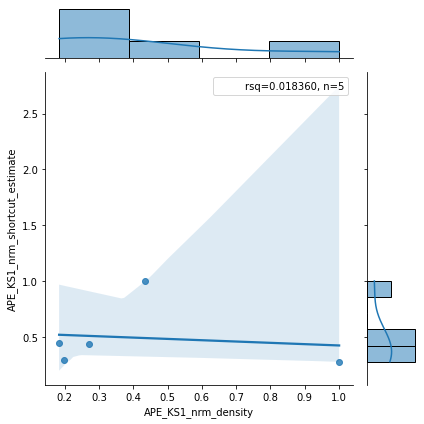

<Figure size 432x288 with 0 Axes>

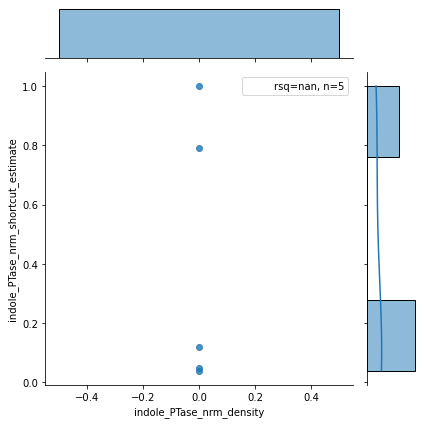

<Figure size 432x288 with 0 Axes>

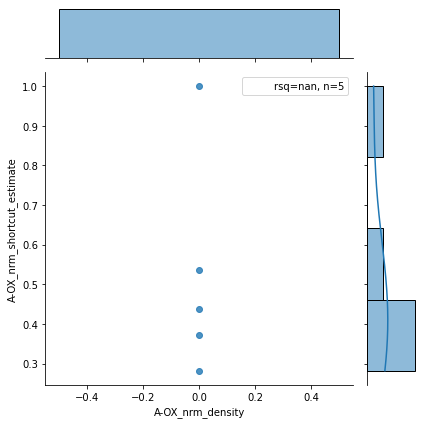

<Figure size 432x288 with 0 Axes>

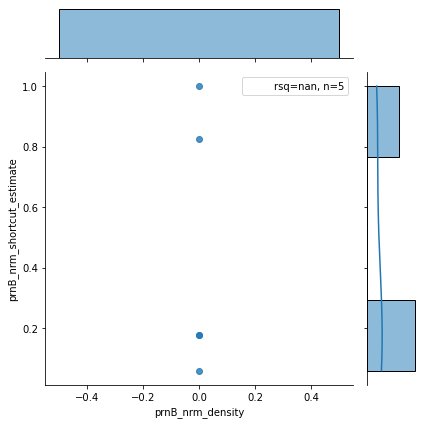

<Figure size 432x288 with 0 Axes>

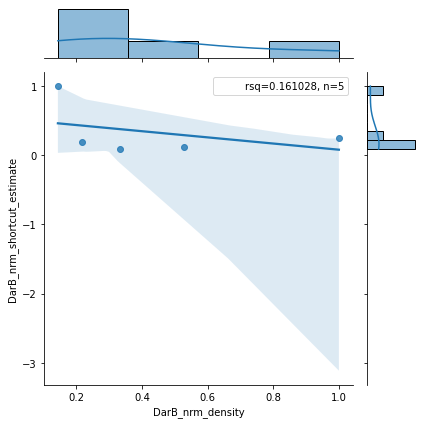

<Figure size 432x288 with 0 Axes>

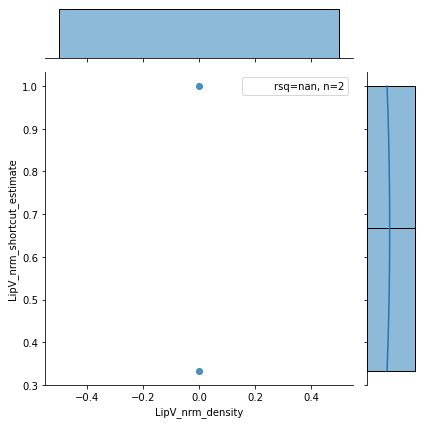

<Figure size 432x288 with 0 Axes>

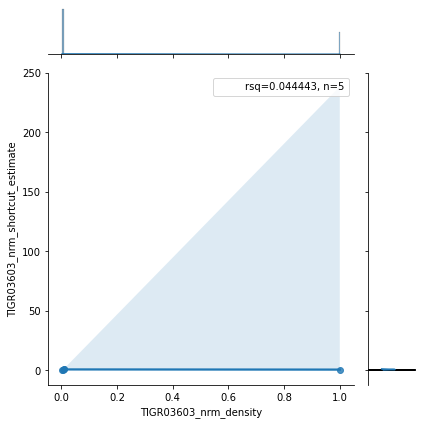

<Figure size 432x288 with 0 Axes>

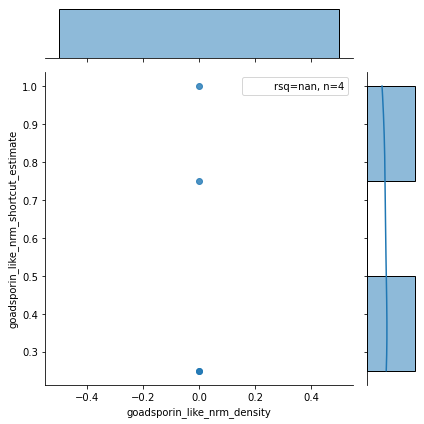

<Figure size 432x288 with 0 Axes>

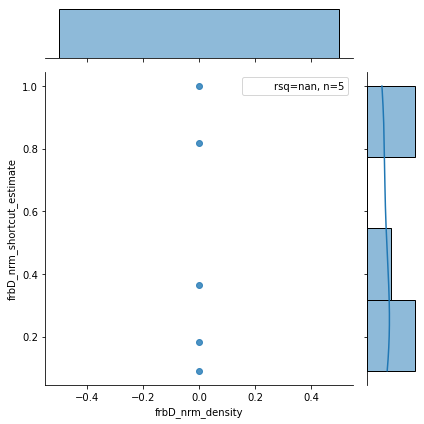

<Figure size 432x288 with 0 Axes>

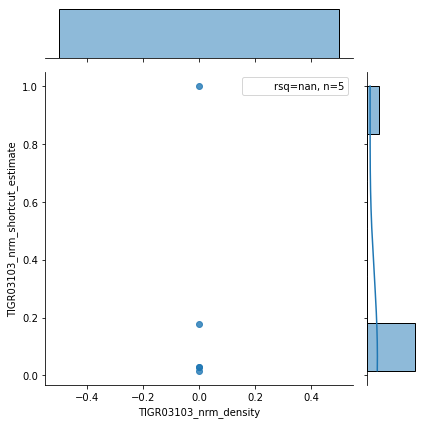

<Figure size 432x288 with 0 Axes>

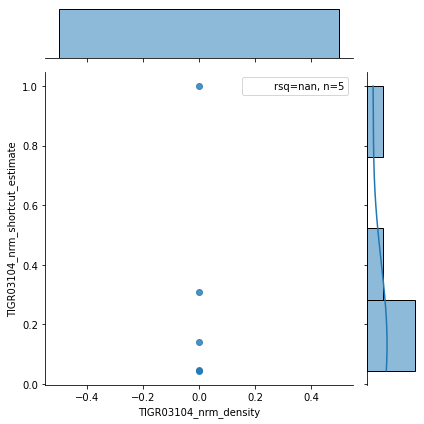

<Figure size 432x288 with 0 Axes>

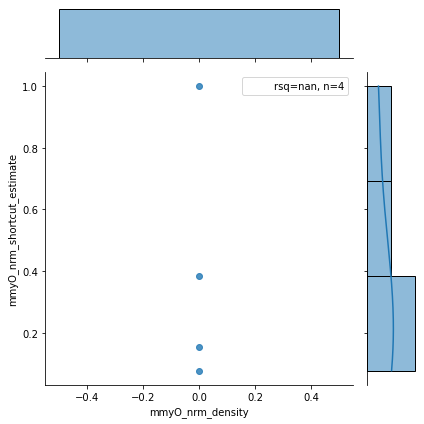

<Figure size 432x288 with 0 Axes>

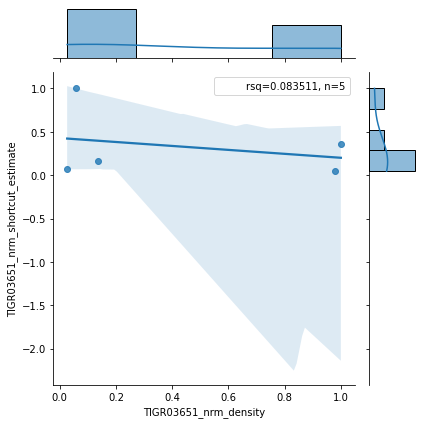

<Figure size 432x288 with 0 Axes>

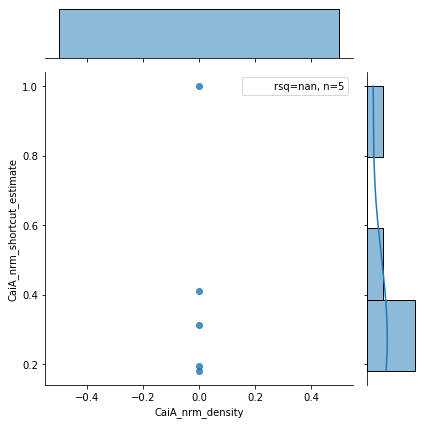

<Figure size 432x288 with 0 Axes>

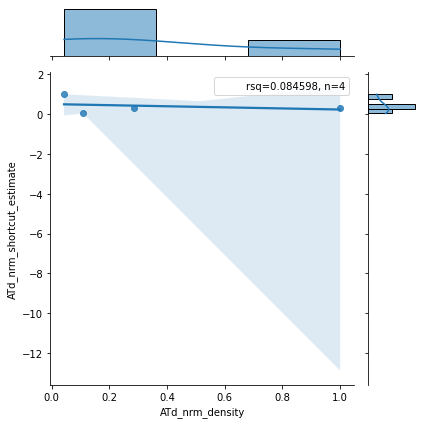

<Figure size 432x288 with 0 Axes>

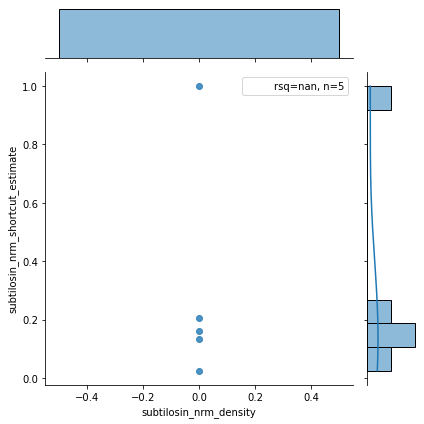

<Figure size 432x288 with 0 Axes>

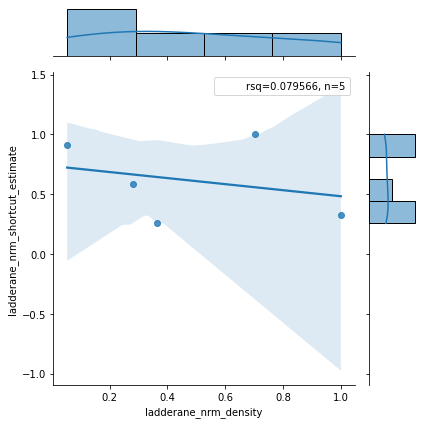

<Figure size 432x288 with 0 Axes>

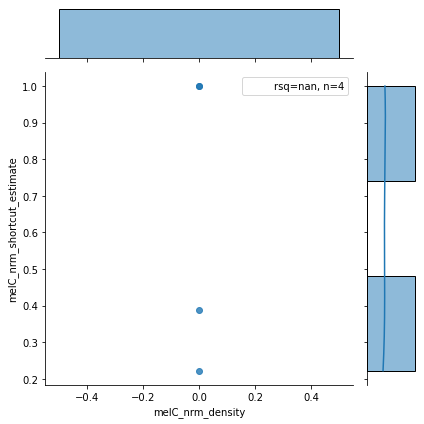

<Figure size 432x288 with 0 Axes>

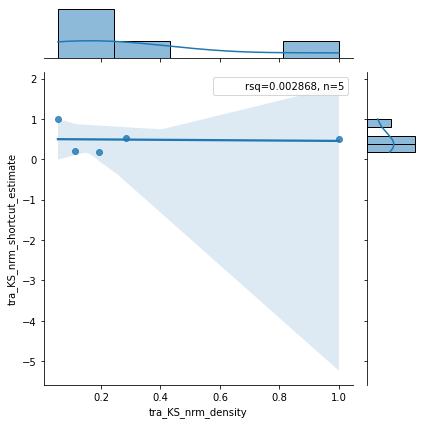

<Figure size 432x288 with 0 Axes>

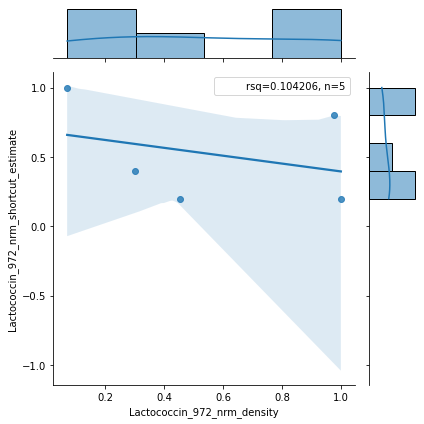

<Figure size 432x288 with 0 Axes>

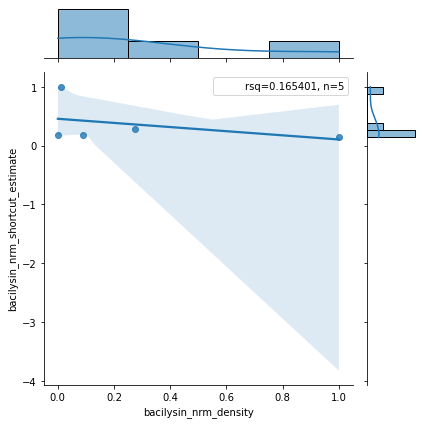

<Figure size 432x288 with 0 Axes>

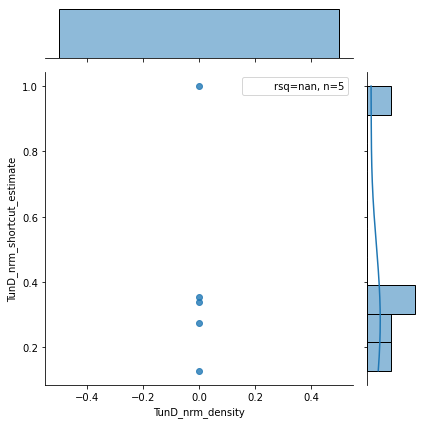

<Figure size 432x288 with 0 Axes>

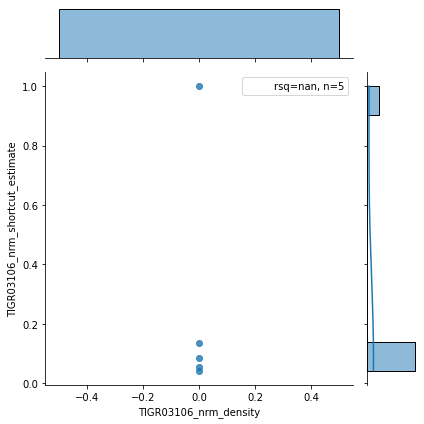

<Figure size 432x288 with 0 Axes>

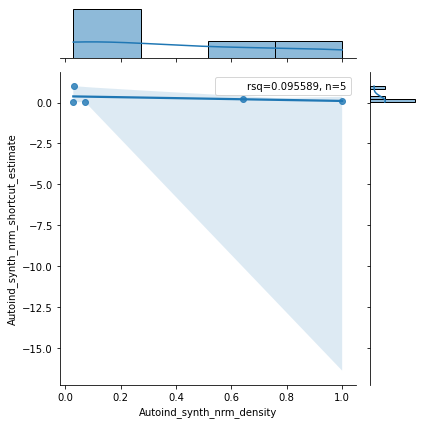

<Figure size 432x288 with 0 Axes>

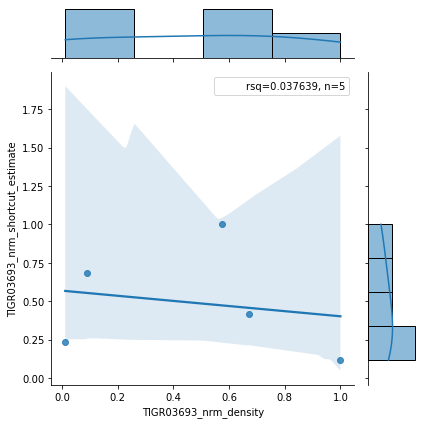

<Figure size 432x288 with 0 Axes>

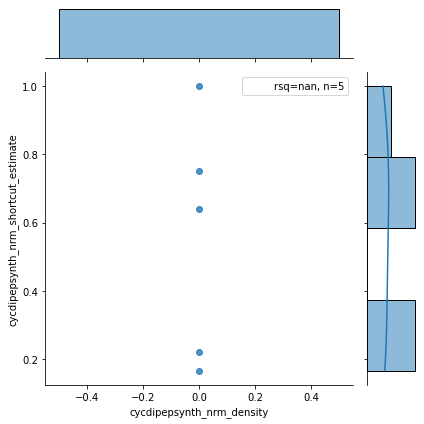

<Figure size 432x288 with 0 Axes>

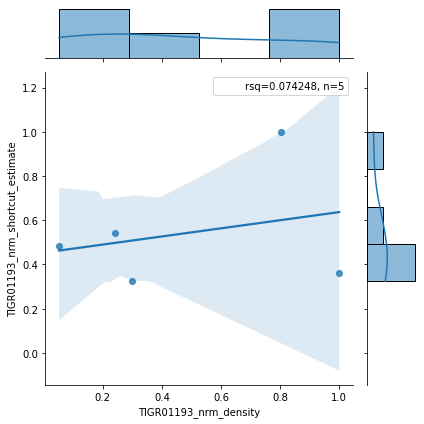

<Figure size 432x288 with 0 Axes>

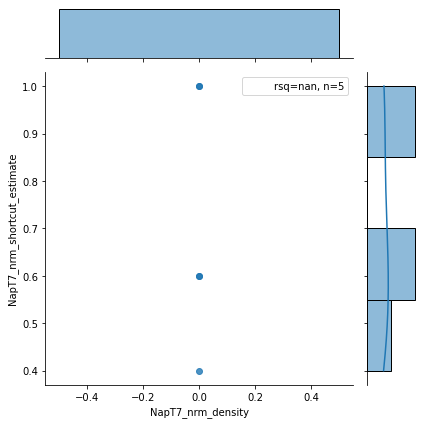

<Figure size 432x288 with 0 Axes>

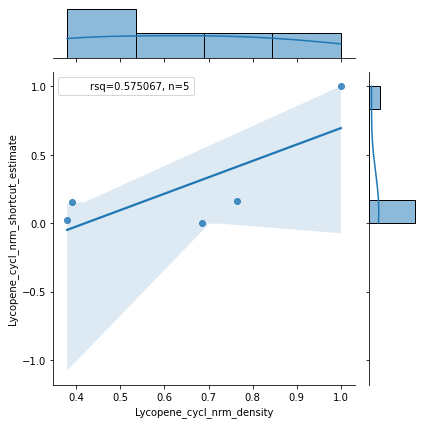

<Figure size 432x288 with 0 Axes>

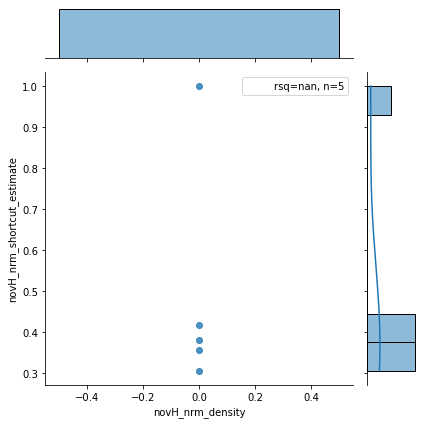

<Figure size 432x288 with 0 Axes>

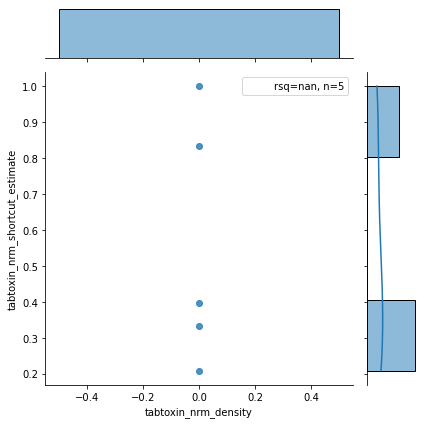

<Figure size 432x288 with 0 Axes>

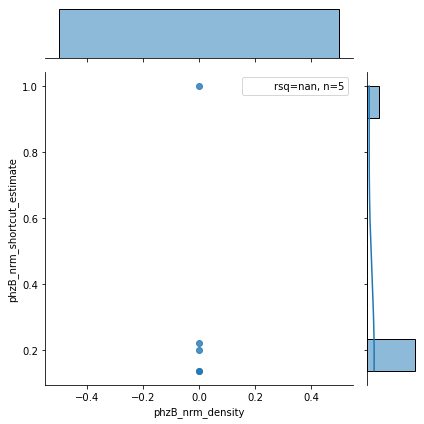

<Figure size 432x288 with 0 Axes>

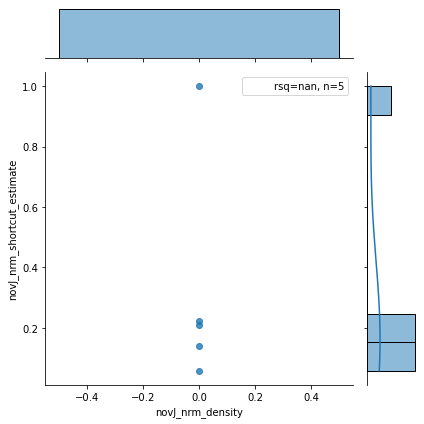

<Figure size 432x288 with 0 Axes>

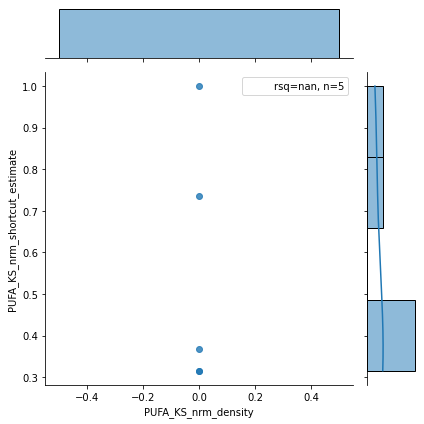

<Figure size 432x288 with 0 Axes>

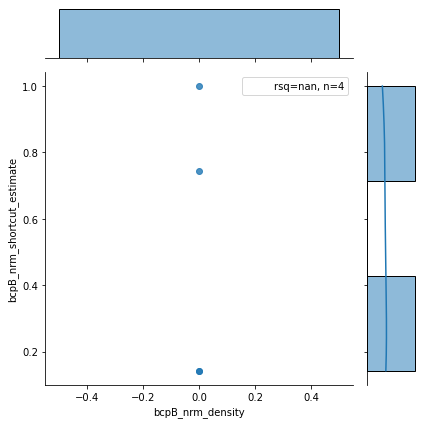

<Figure size 432x288 with 0 Axes>

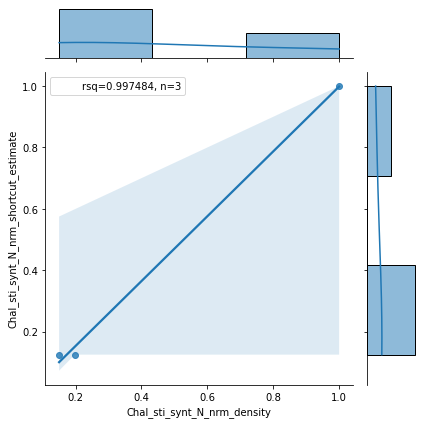

<Figure size 432x288 with 0 Axes>

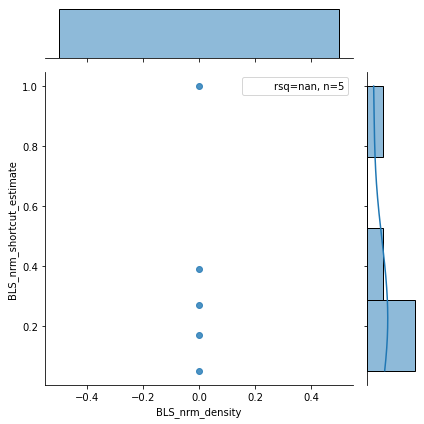

<Figure size 432x288 with 0 Axes>

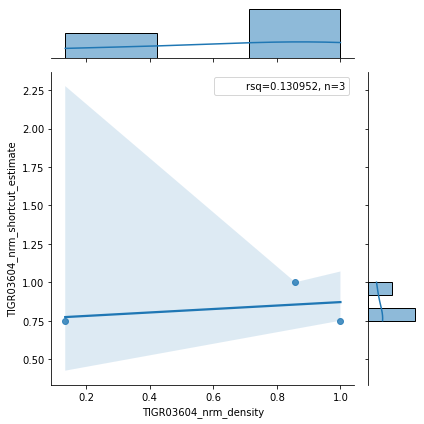

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot amount of above threshold reads against sum of biosynthetic abundance column in coverage tables

coverage_table_dir=set_wd+'/testing_coverage_tables'
# coverage_table_dir='/media/locblankma@vuw.ac.nz/RP/validation_refseq/250_coverage_tables'
# Full validation metagenome collection
# biosynthetic_reads_dir=set_wd+'/99_validation_biosynthetic_reads'
# Tutorial validation metagenome collection
biosynthetic_reads_dir=set_wd+'/70_test_validation_biosynthetic_reads'
# Full validation metagenome collection
# output_dir=set_wd+'/99_validation_joined_hits_nrm'
# Tutorial validation metagenome collection
output_dir=set_wd+'/70_test_validation_joined_hits'

# make an output dir
if os.path.isdir(output_dir):
    print(output_dir,'exists already')
else:
    print('Making', output_dir)
    os.mkdir(output_dir)

# make an plots dir
if os.path.isdir(output_dir+'/plots'):
    print(output_dir+'/plots','exists already')
else:
    print('Making', output_dir+'/plots')
    os.mkdir(output_dir+'/plots')


                
# Read in read_count_df, manually, to normalise the hit_count by the amount of reads in the metagenome
read_count_df = pd.read_csv('/media/locblankma@vuw.ac.nz/RP/shortcut_tutorial_dir/total_reads.csv', sep=',')
# Ideally, this df should be generated when synthesising the metagenomes. Here, it is from slurm logs


# A snippet that generates a dictionary with the calculated read counts. It's currently not used downstream
read_count_dict = {}
for file in os.listdir(coverage_table_dir):
    if re.findall('^metagenome', file):
        mg_name = file.split('.')[0]
        mg_df = pd.read_csv(coverage_table_dir+'/'+mg_name+'.csv')
        read_count_dict[mg_name] = mg_df.loc[:,'calc_reads'].sum()


# print(read_count_dict)
read_count_df = pd.DataFrame.from_dict(read_count_dict, orient='index', columns=['reads'])
read_count_df = read_count_df.reset_index().rename(columns={"index": "sample"})
read_count_df.to_csv(output_dir+'/read_count_df.tsv', sep='\t', index=None)

    
# join all above threshold hits in one df per metagenome
hit_dict = {} # key is: translated_metagenome_0_1
for outdir in os.listdir(biosynthetic_reads_dir):
    hit_list = []
    if re.findall('^translated_metagenome_', outdir):
        for file in os.listdir(biosynthetic_reads_dir+'/'+outdir+'/above_threshold/'):
            test_df = pd.read_csv(biosynthetic_reads_dir+'/'+outdir+'/above_threshold/'+file, sep='\t')
            hit_list.append(test_df)
        hit_dict[outdir] = hit_list


# export that concatenated per-metagenome df to a tsv file
for k,v in hit_dict.items():
    joined_df = pd.concat(v)
    joined_df.to_csv(output_dir+'/'+k+'.tsv', sep='\t', index=False)


# Concatename 1 and 2 files from the same metagenome
mg_list = []
for file in os.listdir(output_dir):
    if re.findall('^translated_metagenome_', file):
        metagenome_basename = '_'.join(file.split('_')[0:3])
        if metagenome_basename not in mg_list:
            mg_list.append(metagenome_basename)


# Export to tsv file as well
# Split file by values in hmm column for hmm resolved plots
# This is a bit of a retrofit to the initially not hmm_resolved version, so hits from fwd/rev read hits are 
# initially concatenated, but then split again and the subset dfs saved in new dirs, respectively.
hmm_resolved_plot_dict = {} # key is: translated_metagenome_4

for i in mg_list:
    if os.path.isdir(output_dir+'/hmm_resolved_'+i):
        continue
    else:
        print('Making', output_dir+'/hmm_resolved_'+i)
        os.mkdir(output_dir+'/hmm_resolved_'+i)
    df_1 = pd.read_csv(output_dir+'/'+i+'_1.tsv', sep='\t')
    df_2 = pd.read_csv(output_dir+'/'+i+'_2.tsv', sep='\t')
    concat_mg_df = pd.concat([df_1, df_2])
    concat_mg_df.to_csv(output_dir+'/concat_'+i+'.tsv', sep='\t', index=False)
    mg_hmm_list = concat_mg_df.loc[:,'hmm'].unique()
    # need to get all unique values from hmm column
    for hmm_name in mg_hmm_list:
        subset_df = concat_mg_df[ (concat_mg_df["hmm"] == hmm_name)]
        subset_df.to_csv(output_dir+'/hmm_resolved_'+i+'/concat_'+i+'_'+hmm_name+'.tsv', sep='\t', index=False)
    hmm_resolved_plot_dict[i] = mg_hmm_list


# # This works for the not hmm_resolved version. Keep this as I still want it.
# plot_dict = {} # key is: concat_translated_metagenome_0
# for file in os.listdir(output_dir):
#     if re.findall('^concat', file):
#         mg_name = '_'.join(file.split('.')[0].split('_')[0:4])
#         mg_df = pd.read_csv(output_dir+'/'+file)
#         plot_dict[mg_name]=len(mg_df)


# print(plot_dict) # {'concat_translated_metagenome_163': 68233, ...}
# Need to generate a plot_dict that is as the one above, matching hit_count to biosynthetic_abundance,
# but additionally matches hit_count of each individual hmm to the respectively matching biosynthetic_abundance
# Don't need to concatenate files for this. can use the individual above threshold hmm count outputs

# # biosynthetic_abundance
# for file in os.listdir(coverage_table_dir):
#     mg_name = 'concat_translated_'+file.split('.')[0]
#     mg_df = pd.read_csv(coverage_table_dir+'/'+file, sep=',')
#     if mg_name in plot_dict.keys():
#         mg_biosynthetic_abundance = mg_df['biosynthetic_abundance'].sum()
#         plot_dict[mg_name]=[plot_dict[mg_name], mg_biosynthetic_abundance]


### modify from biosynthetic abundance to weighted density
        
# Need to match that to the hmm_resolved version as well
# Sortdict has metagenome + hmm as key and a list of the amount of hmm hits and sum of weighted density as values

sortdict = {}
hmm_list = []
for file in os.listdir(coverage_table_dir):
    mg_name = 'translated_'+file.split('.')[0]
    mg_df = pd.read_csv(coverage_table_dir+'/'+file, sep=',')
    if mg_name in hmm_resolved_plot_dict.keys():
        for hmm in hmm_resolved_plot_dict[mg_name]:
            if not hmm in hmm_list:
                hmm_list.append(hmm)
            hmm_hit_len = pd.read_csv(output_dir+'/hmm_resolved_'+mg_name+'/concat_'+mg_name+'_'+hmm+'.tsv', sep='\t')
            
            # Accounting for cases where hmm hits are found against reads, but none were in the input metagenomes
            try:
                sortdict[mg_name+'_'+hmm] = [len(hmm_hit_len), mg_df.loc[:,hmm+'_weighted_density'].sum()]
            except KeyError:
                sortdict[mg_name+'_'+hmm] = [len(hmm_hit_len), 0]
                
                
# generating individual dictionaries resolved by hmm, containing values for all metagenomes pertaining
# to that hmm, then plotting them and outputting that plot
rsq_dict = {}
for hmm in hmm_list:
    indiv_plot_dict = {}
    for k, v in sortdict.items():
        if hmm in k:
            indiv_plot_dict[k] = v


    indiv_corr_df = pd.DataFrame.from_dict(indiv_plot_dict, orient='index', columns=[hmm+'_hit_count', hmm+'_weighted_density'])
    indiv_corr_df.sort_values(by=[hmm+'_weighted_density'], inplace=True)


    # rename columns to merge indiv_corr_df with read_count_df
    indiv_corr_df = indiv_corr_df.reset_index().rename(columns={"index": "sample_hmm"})
    indiv_corr_df['sample'] = indiv_corr_df.apply(lambda row: '_'.join(row.sample_hmm.split('_')[1:3]), axis=1)
    indiv_corr_df['hmm'] = indiv_corr_df.apply(lambda row: '_'.join(row.sample_hmm.split('_')[3:]), axis=1)
#     indiv_corr_df.to_csv(output_dir+'/'+hmm+'_indiv_corr_df.tsv', sep='\t', index=None)

    
    merged_df = pd.merge(indiv_corr_df,
             read_count_df,
             on='sample',
             how='inner',
             left_index=False,
             right_index=False)
    
#     merged_df.to_csv(output_dir+'/'+hmm+'_merged_df.tsv', sep='\t', index=None)
    
    # This is the table that Jeremy sent me as an example but with some extra columns in it
    # Modify the code below to reflect this change
    merged_df.rename(columns={hmm+'_hit_count': hmm+'_shortcut_estimate'}, inplace=True)
    merged_df.rename(columns={hmm+'_weighted_density': hmm+'_summed_density'}, inplace=True)
    #normalise the shortcut estimate by the largest value in the column
    merged_df[hmm+'_nrm_shortcut_estimate'] = merged_df[hmm+'_shortcut_estimate'] / merged_df[hmm+'_shortcut_estimate'].max()
    merged_df[hmm+'_nrm_density'] = merged_df[hmm+'_summed_density'] / merged_df[hmm+'_summed_density'].max()
    indiv_corr_df = merged_df.iloc[:,[0,6,7]]
    indiv_corr_df.set_index('sample_hmm', inplace=True)
    indiv_corr_df[hmm+'_nrm_density'] = indiv_corr_df[hmm+'_nrm_density'].fillna(0)
#     indiv_corr_df.to_csv(output_dir+'/'+hmm+'_indiv_corr_df.tsv', sep='\t')

    
    plt.figure()
    if len(indiv_corr_df[hmm+'_nrm_shortcut_estimate']) >=2:
        print('building biosynthetic capacity dict for:', hmm, 'n=', len(indiv_corr_df[hmm+'_nrm_shortcut_estimate']))
        r, p = stats.pearsonr(x=indiv_corr_df[hmm+'_nrm_density'], y=indiv_corr_df[hmm+'_nrm_shortcut_estimate'])
        graph = sns.jointplot(x=indiv_corr_df[hmm+'_nrm_density'], y=indiv_corr_df[hmm+'_nrm_shortcut_estimate'], kind='reg')
        phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
        graph.ax_joint.legend([phantom],['rsq={:f}, n={:s}'.format(r**2, str(len(indiv_corr_df[hmm+'_nrm_shortcut_estimate'])))])
        plt.tight_layout()
        plt.savefig(output_dir+'/plots/'+hmm+'.png')
        rsq_dict[hmm] = [len(indiv_corr_df[hmm+'_nrm_shortcut_estimate']), r**2]
    else:
        print(hmm, 'only found once, no plot generated')


        
# corr_df = pd.DataFrame.from_dict(plot_dict, orient='index', columns=['hit_count', 'biosynthetic_abundance'])
# corr_df.sort_values(by=['biosynthetic_abundance'], inplace=True)


# corr_df = corr_df.reset_index().rename(columns={"index": "sample_name"})
# corr_df['sample'] = corr_df.apply(lambda row: '_'.join(row.sample_name.split('_')[1:4]), axis=1)


# merged_df = pd.merge(corr_df,
#          read_count_df,
#          on='sample',
#          how='inner',
#          left_index=False,
#          right_index=False)

# # normalise biosynthetic_abundance by read_count in the metagenomes
# merged_df['nrm_hit_count'] = merged_df.apply(lambda row: row.hit_count/row.reads, axis=1)

# corr_df = merged_df.iloc[:,[0,2,5]]
# corr_df.set_index('sample_name', inplace=True)



# plt.figure()
# r, p = stats.pearsonr(x=corr_df['biosynthetic_abundance'], y=corr_df['nrm_hit_count'])
# total_graph = sns.jointplot(x=corr_df['biosynthetic_abundance'], y=corr_df['nrm_hit_count'], kind='reg')
# phantom, = total_graph.ax_joint.plot([], [], linestyle="", alpha=0)
# # total_graph.ax_joint.legend([phantom],['rsq={:f}'.format(r**2)])
# total_graph.ax_joint.legend([phantom],['rsq={:f}, n={:s}'.format(r**2, str(len(corr_df)))])
# plt.tight_layout()
# plt.savefig(output_dir+'/plots/'+'total_comparison'+'.png')

# Export df with rsq values of all hmms
rsq_df = pd.DataFrame.from_dict(rsq_dict, orient='index', columns=['n','rsq'])
rsq_df = rsq_df.reset_index().rename(columns={"index": "hmm"})
rsq_df.sort_values(by=['rsq'], inplace=True, ascending=False)
rsq_df.to_csv(output_dir+'/rsq_df.tsv', sep='\t', index=None)

print('Done')
